In [1]:
import keras
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from keras.callbacks import ModelCheckpoint, EarlyStopping
# %reload_ext mermaid
# import IPython
# IPython.load_ipython_extensions(["nb-mermaid/nb-mermaid"]);

Using TensorFlow backend.


In [2]:
import tensorflow  as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dropout,UpSampling2D, Dense, MaxPooling2D, BatchNormalization, Input, Flatten, Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import Adadelta, SGD, Adam
from keras.utils import to_categorical
import keras.backend as K

In [3]:
tf_config = tf.ConfigProto(allow_soft_placement=False)
tf_config.gpu_options.allow_growth = True
s = tf.Session(config=tf_config)
K.set_session(s)

In [4]:
csv_data = pd.read_csv('15features.csv')
display(csv_data.head()), display(csv_data.shape)
train_path = 'seen-dataset/TrainingSet/'
train_images = os.listdir(train_path)

val_path = 'seen-dataset/ValidationSet/'
val_images = os.listdir(val_path)
len(train_images)+len(val_images)

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2


(13570, 16)

13798

In [5]:
# len(list(set(list(x[:4] for x in images['image'])))), len(list(set(list(x[:4] for x in csv_data['ImageId']))))

In [6]:
dataset_columns = csv_data.columns
csv_data['imagename'] = csv_data['imagename'].astype('str')
display(csv_data.head(20))
csv_data.shape

,imagename,pen_pressure,letter_spacing,size,dimension,is_lowercase,is_continuous,slantness,tilt,entry_stroke_a,staff_of_a,formation_n,staff_of_d,exit_stroke_d,word_formation,constancy
0,0968c_num1.png,2,2,2,1,2,2,3,2,1,2,2,3,2,2,1
1,0809c_num2.png,2,2,2,2,2,2,3,1,1,2,2,3,1,2,2
2,0237b_num6.png,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2
3,0069b_num2.png,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1
4,0966c_num4.png,2,2,2,2,2,2,2,1,1,2,2,2,2,2,2
5,1316a_num2.png,2,2,1,1,2,2,3,1,1,2,2,2,3,2,2
6,1503c_num2.png,2,1,2,2,2,2,2,1,1,3,2,2,3,2,2
7,0113c_num1.png,2,3,2,2,2,1,2,1,1,1,2,2,2,2,2
8,0221a_num6.png,2,2,2,2,2,1,1,1,1,4,1,2,3,1,2
9,0068a_num4.png,1,1,2,2,2,2,1,1,1,2,2,2,2,2,2


(13570, 16)

In [7]:
# train_csv_data =  csv_data[:700]
# val_csv_data =  csv_data[700:]
# train_csv_data.shape, val_csv_data.shape

In [8]:
f = []
for col in dataset_columns[1:]:
    f.append(csv_data[col].unique().shape[0])
f,len(f)

([2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2], 15)

In [9]:
input_img = Input(shape=(64, 64, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoded')(x)
# encoded = GlobalAveragePooling2D()(x)

# encoder = Model(input_img, encoded)
# encoder.summary()
# print(encoded.shape)
# encoded = Flatten()(x)
# encoded = Dense(8*8*8)(encoded)
# # model = Model(input_img,encoded)
# # print(model.summary())
# # at this point the representation is (4, 4, 8) i.e. 128-dimensional
# r = Reshape(target_shape=(8,8,8))(encoded)
x = Conv2D(512, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='output')(x)

autoencoder = Model(input_img, decoded)
autoencoder.load_weights('weights/simple_ae_maxpool_seen_weights_v1.h5')

In [10]:
encoder = Model(autoencoder.input,autoencoder.get_layer('encoded').output)
encoder.summary()
# for layer in encoder.layers:
#     layer.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [11]:

# # model = Sequential()
# input_layer = Input((64,64,1))
# model = BatchNormalization()(input_layer)

# model = Conv2D(activation='relu',filters=32, kernel_size=(32,32), padding='same')(model)
# model = Conv2D(activation='relu',filters=64, kernel_size=(32,32), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)

# model = Conv2D(activation='relu',filters=128, kernel_size=(16,16), padding='same')(model)
# model = Conv2D(activation='relu',filters=256, kernel_size=(16,16), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)

# model = Conv2D(activation='relu',filters=128, kernel_size=(8,8), padding='same')(model)
# model = Conv2D(activation='relu',filters=256, kernel_size=(8,8), strides=(1,1), padding='same')(model)
# model = MaxPool2D((2,2))(model)
# model = Dropout(0.25)(model)
# # model = Flatten()(model)

# dense_layer = Dense(512, activation='relu')(model)
# dense_layer = Dropout(0.5)(dense_layer)
dense_layer = encoder.get_layer('encoded').output
out_dense_layer=[]
for i in range(1,len(f)+1):
    out_dense_layer.append(Dense(f[i-1] , activation='softmax', name = 'out_feature_'+str(i))(Dense(128 , activation='relu', name = 'dense_layer_'+str(i))(Flatten(name='flatten_'+str(i))((dense_layer)))))

human_features = Model(inputs=encoder.input, outputs=out_dense_layer)
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

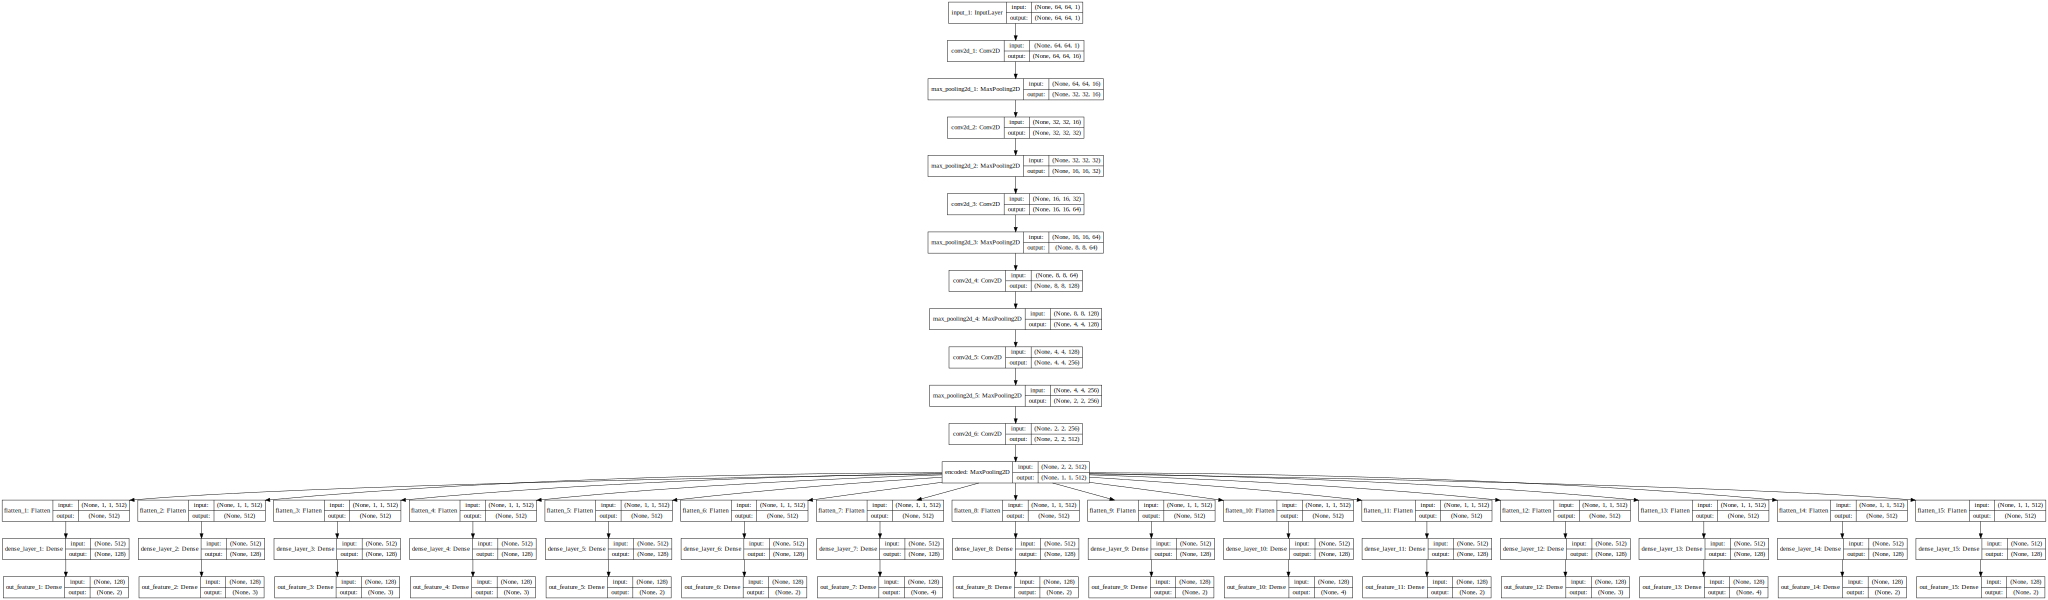

In [12]:
SVG(model_to_dot(human_features, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
feature_lengths = {}
for col in dataset_columns[1:]:
    feature_lengths[col] = len(csv_data[col].unique())
feature_lengths = list(feature_lengths.values())
feature_lengths

[2, 3, 3, 3, 2, 2, 4, 2, 2, 4, 2, 3, 4, 2, 2]

In [14]:
# df_data[df_data['f8']==2]

In [15]:
# im = images[images['image'].str.match('1229b')]
# im.iloc[0]['image']

In [16]:

# stop_at = 20
# identitycounter = 1
# unique_writers = list(set(list(x[:4] for x in df_data['ImageId'])))
# for writer in unique_writers:
#     print(identitycounter*100/stop_at, end='\r')
#     writer_samples = list(images[images['image'].str.match(writer)]['image'])
# #     print('lne',len(writer_samples))
#     f,ax = plt.subplots(1,len(writer_samples))
#     f.subplots_adjust(hspace = .5, wspace=.15)
#     f.set_size_inches(15,15)
#     imgcounter = 0
#     for sample in writer_samples:
#         imagepath = os.path.join(image_path,sample)
#         raw_img = cv2.imread(imagepath)
#         if len(writer_samples)>1:
#             ax[imgcounter].imshow(raw_img)
#             ax[imgcounter].set_title(writer+'\n'+sample)
#         else:
#             ax.imshow(raw_img)
#             ax.set_title(writer+'\n'+sample)
# #         ax[imgcounter].axis('off')
#         imgcounter+=1
#         if imgcounter == stop_at:
#             break
#     imgcounter=0
#     identitycounter += 1
#     if identitycounter == stop_at+1:
#         break

In [17]:
# csv_data[csv_data['ImageId'].str.match('1302c')]

In [18]:

def datagen(batch_size,image_path,list_of_writers, vshift = (-64,64) ,vis=False):
    counter = 0
    w_ids,ids,x,y,imagenames, feature_list = [],[],[],[],[],[]
    while True:
#         counter = 0
        # for writer in unique_writers:
        #     print(identitycounter*100/stop_at, end='\r')
        
        writer_index = np.random.randint(0,len(list_of_writers))
        
#         for writer_index in writer_indexes:
#             class_vectors = []
#             features = None
        imagename = list_of_writers[writer_index]
#             print('-->',csv_data['imagename'][0],imagename)
#             display(csv_data[csv_data['imagename']==imagename].values[0][1:])
        features = csv_data[csv_data['imagename']==imagename].values
        if len(features)==0:
#             print('no features', imagename)
            continue
        features = features[0][1:]-1
#             print(features)
#             print(writer)
#             writer_samples = list(images[images['image'].str.match(writer)]['image'])
#             print('writer:',writer,', writer_samples:',writer_samples)
#             if len(writer_samples) == 0:
#                 continue
#             writer_sample_index = np.random.randint(0,len(writer_samples))

#             #     unique_writers_count[writer] = len(writer_samples)
# #             print('writer_sample_index:',writer_sample_index)
#             csv_writer = writer_samples[writer_sample_index][:5]


        loaded_image = cv2.imread(os.path.join(image_path,imagename),0)
        rand = np.random.randint(vshift[0],vshift[1])
        loaded_image_shifted=np.roll(axis=0,a=loaded_image,shift=rand)

        x.append(255.0-loaded_image_shifted.reshape((64,64,1)))
        y.append(255.0-loaded_image.reshape((64,64,1)))
        w_ids.append(imagename[:4])
        imagenames.append(imagename)
        ids.append(writer_index)
        feature_list.append(features)
#         print(imagename)
        counter+=1
#         print('counter:', counter, end='\r')
        if counter == batch_size:
            counter=0
            feature_list = np.array(feature_list)
            feature_list = feature_list.transpose()
            out_cat_features = []
            for i in range(len(feature_list)):
#                 print(feature_list[1])
                out_cat_features.append(to_categorical(feature_list[i],num_classes=feature_lengths[i]))
            if vis== True:
                yield np.array(x)/255.0,[np.array(w_ids),np.array(imagenames)]
            else:
                yield np.array(x)/255.0,out_cat_features
            w_ids,ids,x,y,imagenames,feature_list =[], [],[], [],[],[]    

In [19]:

batch_size = 64

tg = datagen(batch_size,image_path=train_path,vshift=(-10,10),list_of_writers=train_images)
vg = datagen(batch_size,image_path=val_path,vshift=(-10,10), list_of_writers=val_images)


In [20]:
# images
inputs,o = next(tg)
print(inputs.shape)
for op in o:
    print((np.argmax(op, axis=1)+1)[0])
#     print('------')
# feature_list

(64, 64, 64, 1)
2
2
2
2
2
1
1
1
1
2
2
2
2
2
2


In [21]:
csv_data[csv_data['imagename']=='0066c_num3.png'].values[0][1:]

array([2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1], dtype=object)

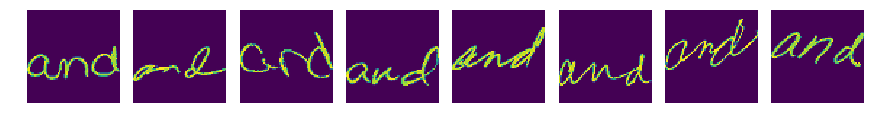

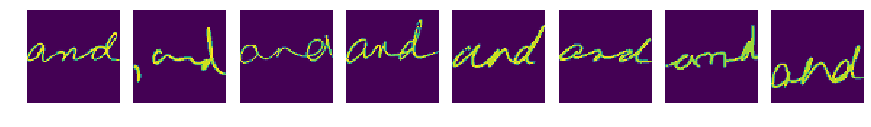

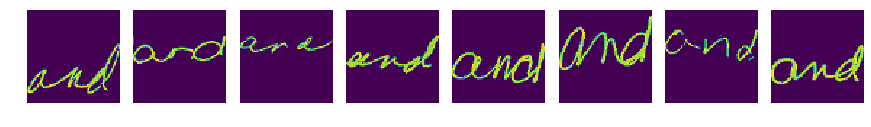

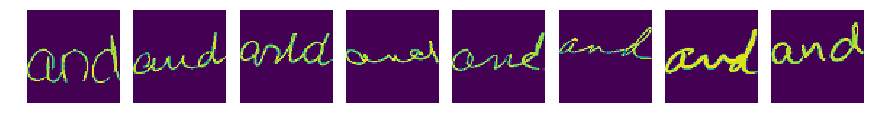

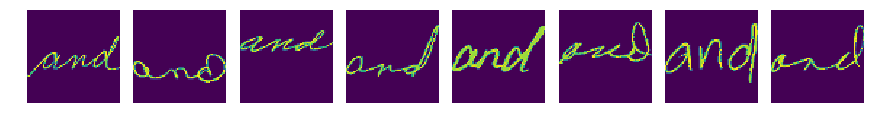

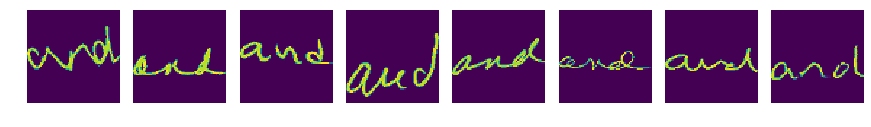

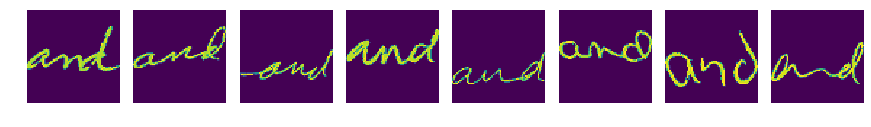

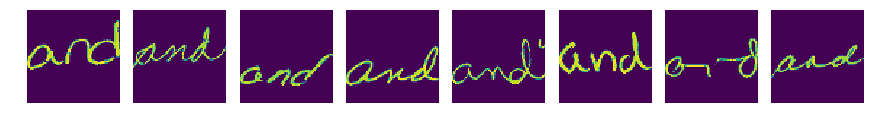

In [22]:
for r in range(8):
    f,ax = plt.subplots(1,8)
    f.subplots_adjust(hspace = .00, wspace=.15)
    f.set_size_inches(15,5)
    for c in range (8):
        ax[c].imshow(inputs[c+r*8].reshape((64,64)))
        ax[c].axis('off')

In [23]:
losses = {}
lossWeights = {}
for i in range(1,16):
    losses["out_feature_"+str(i)] = "categorical_crossentropy"
    lossWeights["out_feature_"+str(i)] = 1.0
# lossWeights["out_feature_1"] = 10.0
# lossWeights["out_feature_2"] = 8.0
# lossWeights["out_feature_3"] = 0.1
# lossWeights["out_feature_4"] = 8.0
# lossWeights["out_feature_5"] = 1.0
# lossWeights["out_feature_6"] = 5.0
# lossWeights["out_feature_7"] = 5.0
# lossWeights["out_feature_8"] = 10.0


In [24]:
mc = ModelCheckpoint(filepath='weights/15-Multitask-TrainableEncoder-seen_v2.h5', monitor='val_loss',period=1,save_best_only=True,save_weights_only=True,mode='auto',verbose=3)
es = EarlyStopping(patience=10000, monitor='val_loss', min_delta=0.0005, mode='auto')

In [25]:
EPOCHS = 50000
INIT_LR = 0.0001
opt = SGD(lr=INIT_LR, decay=1e-6, momentum=0.95, nesterov=True)
# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# opt = Adadelta(lr=INIT_LR, decay=1e-04)

# feat_extractor.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])


human_features.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=["accuracy"])
human_features.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   4640        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [26]:
# human_features.load_weights('human_features_weights_v3.h5')
# inputs,o = next(vg)
# for i in range(64):
#     print(i)
#     f_probs = human_features.predict(np.expand_dims(inputs[i],0))
# #     print(f_probs)
#     for prob in f_probs:
#         print(np.argmax(prob),end=',')
#     print('++++++++++++')
# human_features.load_weights('15_human_features_weights_seen_v1.h5')

In [27]:
# human_features.load_weights('weights/15-Multitask-TrainableEncoder-seen_v1.h5')
hist = human_features.fit_generator(tg, callbacks=[mc,es]
                                    , epochs=EPOCHS
                                    , steps_per_epoch = 1
                                    , validation_data = vg
                                    , validation_steps = 1
                                    , verbose = 3
                                    
                                   )

Epoch 1/50000

Epoch 00001: val_loss improved from inf to 16.04842, saving model to weights/15-Multitask-TrainableEncoder-seen_v2.h5
Epoch 2/50000

Epoch 00002: val_loss improved from 16.04842 to 16.01743, saving model to weights/15-Multitask-TrainableEncoder-seen_v2.h5
Epoch 3/50000

Epoch 00003: val_loss improved from 16.01743 to 15.60061, saving model to weights/15-Multitask-TrainableEncoder-seen_v2.h5
Epoch 4/50000

Epoch 00004: val_loss improved from 15.60061 to 15.43673, saving model to weights/15-Multitask-TrainableEncoder-seen_v2.h5
Epoch 5/50000

Epoch 00005: val_loss did not improve from 15.43673
Epoch 6/50000

Epoch 00006: val_loss did not improve from 15.43673
Epoch 7/50000

Epoch 00007: val_loss did not improve from 15.43673
Epoch 8/50000

Epoch 00008: val_loss improved from 15.43673 to 14.75072, saving model to weights/15-Multitask-TrainableEncoder-seen_v2.h5
Epoch 9/50000

Epoch 00009: val_loss improved from 14.75072 to 14.68856, saving model to weights/15-Multitask-Trai


Epoch 00090: val_loss did not improve from 10.10717
Epoch 91/50000

Epoch 00091: val_loss improved from 10.10717 to 9.91504, saving model to weights/15-Multitask-TrainableEncoder-seen_v2.h5
Epoch 92/50000

Epoch 00092: val_loss did not improve from 9.91504
Epoch 93/50000

Epoch 00093: val_loss did not improve from 9.91504
Epoch 94/50000

Epoch 00094: val_loss improved from 9.91504 to 9.81909, saving model to weights/15-Multitask-TrainableEncoder-seen_v2.h5
Epoch 95/50000

Epoch 00095: val_loss did not improve from 9.81909
Epoch 96/50000

Epoch 00096: val_loss did not improve from 9.81909
Epoch 97/50000

Epoch 00097: val_loss did not improve from 9.81909
Epoch 98/50000

Epoch 00098: val_loss did not improve from 9.81909
Epoch 99/50000

Epoch 00099: val_loss did not improve from 9.81909
Epoch 100/50000

Epoch 00100: val_loss did not improve from 9.81909
Epoch 101/50000

Epoch 00101: val_loss did not improve from 9.81909
Epoch 102/50000

Epoch 00102: val_loss did not improve from 9.81909


Epoch 00201: val_loss did not improve from 8.74981
Epoch 202/50000

Epoch 00202: val_loss did not improve from 8.74981
Epoch 203/50000

Epoch 00203: val_loss did not improve from 8.74981
Epoch 204/50000

Epoch 00204: val_loss did not improve from 8.74981
Epoch 205/50000

Epoch 00205: val_loss did not improve from 8.74981
Epoch 206/50000

Epoch 00206: val_loss did not improve from 8.74981
Epoch 207/50000

Epoch 00207: val_loss did not improve from 8.74981
Epoch 208/50000

Epoch 00208: val_loss did not improve from 8.74981
Epoch 209/50000

Epoch 00209: val_loss did not improve from 8.74981
Epoch 210/50000

Epoch 00210: val_loss did not improve from 8.74981
Epoch 211/50000

Epoch 00211: val_loss did not improve from 8.74981
Epoch 212/50000

Epoch 00212: val_loss did not improve from 8.74981
Epoch 213/50000

Epoch 00213: val_loss did not improve from 8.74981
Epoch 214/50000

Epoch 00214: val_loss did not improve from 8.74981
Epoch 215/50000

Epoch 00215: val_loss did not improve from 8.74


Epoch 00317: val_loss did not improve from 8.13441
Epoch 318/50000

Epoch 00318: val_loss did not improve from 8.13441
Epoch 319/50000

Epoch 00319: val_loss did not improve from 8.13441
Epoch 320/50000

Epoch 00320: val_loss did not improve from 8.13441
Epoch 321/50000

Epoch 00321: val_loss did not improve from 8.13441
Epoch 322/50000

Epoch 00322: val_loss did not improve from 8.13441
Epoch 323/50000

Epoch 00323: val_loss did not improve from 8.13441
Epoch 324/50000

Epoch 00324: val_loss did not improve from 8.13441
Epoch 325/50000

Epoch 00325: val_loss did not improve from 8.13441
Epoch 326/50000

Epoch 00326: val_loss did not improve from 8.13441
Epoch 327/50000

Epoch 00327: val_loss did not improve from 8.13441
Epoch 328/50000

Epoch 00328: val_loss did not improve from 8.13441
Epoch 329/50000

Epoch 00329: val_loss did not improve from 8.13441
Epoch 330/50000

Epoch 00330: val_loss did not improve from 8.13441
Epoch 331/50000

Epoch 00331: val_loss did not improve from 8.13


Epoch 00435: val_loss did not improve from 7.79326
Epoch 436/50000

Epoch 00436: val_loss did not improve from 7.79326
Epoch 437/50000

Epoch 00437: val_loss did not improve from 7.79326
Epoch 438/50000

Epoch 00438: val_loss did not improve from 7.79326
Epoch 439/50000

Epoch 00439: val_loss did not improve from 7.79326
Epoch 440/50000

Epoch 00440: val_loss did not improve from 7.79326
Epoch 441/50000

Epoch 00441: val_loss did not improve from 7.79326
Epoch 442/50000

Epoch 00442: val_loss did not improve from 7.79326
Epoch 443/50000

Epoch 00443: val_loss did not improve from 7.79326
Epoch 444/50000

Epoch 00444: val_loss did not improve from 7.79326
Epoch 445/50000

Epoch 00445: val_loss did not improve from 7.79326
Epoch 446/50000

Epoch 00446: val_loss did not improve from 7.79326
Epoch 447/50000

Epoch 00447: val_loss did not improve from 7.79326
Epoch 448/50000

Epoch 00448: val_loss did not improve from 7.79326
Epoch 449/50000

Epoch 00449: val_loss did not improve from 7.79


Epoch 00554: val_loss did not improve from 7.21702
Epoch 555/50000

Epoch 00555: val_loss did not improve from 7.21702
Epoch 556/50000

Epoch 00556: val_loss did not improve from 7.21702
Epoch 557/50000

Epoch 00557: val_loss did not improve from 7.21702
Epoch 558/50000

Epoch 00558: val_loss did not improve from 7.21702
Epoch 559/50000

Epoch 00559: val_loss did not improve from 7.21702
Epoch 560/50000

Epoch 00560: val_loss did not improve from 7.21702
Epoch 561/50000

Epoch 00561: val_loss did not improve from 7.21702
Epoch 562/50000

Epoch 00562: val_loss did not improve from 7.21702
Epoch 563/50000

Epoch 00563: val_loss did not improve from 7.21702
Epoch 564/50000

Epoch 00564: val_loss did not improve from 7.21702
Epoch 565/50000

Epoch 00565: val_loss did not improve from 7.21702
Epoch 566/50000

Epoch 00566: val_loss did not improve from 7.21702
Epoch 567/50000

Epoch 00567: val_loss did not improve from 7.21702
Epoch 568/50000

Epoch 00568: val_loss did not improve from 7.21


Epoch 00674: val_loss did not improve from 7.13475
Epoch 675/50000

Epoch 00675: val_loss did not improve from 7.13475
Epoch 676/50000

Epoch 00676: val_loss did not improve from 7.13475
Epoch 677/50000

Epoch 00677: val_loss did not improve from 7.13475
Epoch 678/50000

Epoch 00678: val_loss did not improve from 7.13475
Epoch 679/50000

Epoch 00679: val_loss did not improve from 7.13475
Epoch 680/50000

Epoch 00680: val_loss did not improve from 7.13475
Epoch 681/50000

Epoch 00681: val_loss did not improve from 7.13475
Epoch 682/50000

Epoch 00682: val_loss did not improve from 7.13475
Epoch 683/50000

Epoch 00683: val_loss did not improve from 7.13475
Epoch 684/50000

Epoch 00684: val_loss did not improve from 7.13475
Epoch 685/50000

Epoch 00685: val_loss did not improve from 7.13475
Epoch 686/50000

Epoch 00686: val_loss did not improve from 7.13475
Epoch 687/50000

Epoch 00687: val_loss did not improve from 7.13475
Epoch 688/50000

Epoch 00688: val_loss did not improve from 7.13


Epoch 00794: val_loss did not improve from 6.96066
Epoch 795/50000

Epoch 00795: val_loss improved from 6.96066 to 6.95619, saving model to weights/15-Multitask-TrainableEncoder-seen_v2.h5
Epoch 796/50000

Epoch 00796: val_loss did not improve from 6.95619
Epoch 797/50000

Epoch 00797: val_loss did not improve from 6.95619
Epoch 798/50000

Epoch 00798: val_loss did not improve from 6.95619
Epoch 799/50000

Epoch 00799: val_loss did not improve from 6.95619
Epoch 800/50000

Epoch 00800: val_loss did not improve from 6.95619
Epoch 801/50000

Epoch 00801: val_loss did not improve from 6.95619
Epoch 802/50000

Epoch 00802: val_loss did not improve from 6.95619
Epoch 803/50000

Epoch 00803: val_loss did not improve from 6.95619
Epoch 804/50000

Epoch 00804: val_loss did not improve from 6.95619
Epoch 805/50000

Epoch 00805: val_loss did not improve from 6.95619
Epoch 806/50000

Epoch 00806: val_loss did not improve from 6.95619
Epoch 807/50000

Epoch 00807: val_loss did not improve from 6.


Epoch 00912: val_loss did not improve from 6.82762
Epoch 913/50000

Epoch 00913: val_loss did not improve from 6.82762
Epoch 914/50000

Epoch 00914: val_loss did not improve from 6.82762
Epoch 915/50000

Epoch 00915: val_loss did not improve from 6.82762
Epoch 916/50000

Epoch 00916: val_loss did not improve from 6.82762
Epoch 917/50000

Epoch 00917: val_loss did not improve from 6.82762
Epoch 918/50000

Epoch 00918: val_loss did not improve from 6.82762
Epoch 919/50000

Epoch 00919: val_loss did not improve from 6.82762
Epoch 920/50000

Epoch 00920: val_loss did not improve from 6.82762
Epoch 921/50000

Epoch 00921: val_loss did not improve from 6.82762
Epoch 922/50000

Epoch 00922: val_loss did not improve from 6.82762
Epoch 923/50000

Epoch 00923: val_loss did not improve from 6.82762
Epoch 924/50000

Epoch 00924: val_loss did not improve from 6.82762
Epoch 925/50000

Epoch 00925: val_loss did not improve from 6.82762
Epoch 926/50000

Epoch 00926: val_loss did not improve from 6.82


Epoch 01032: val_loss did not improve from 6.82762
Epoch 1033/50000

Epoch 01033: val_loss did not improve from 6.82762
Epoch 1034/50000

Epoch 01034: val_loss did not improve from 6.82762
Epoch 1035/50000

Epoch 01035: val_loss did not improve from 6.82762
Epoch 1036/50000

Epoch 01036: val_loss did not improve from 6.82762
Epoch 1037/50000

Epoch 01037: val_loss did not improve from 6.82762
Epoch 1038/50000

Epoch 01038: val_loss improved from 6.82762 to 6.68986, saving model to weights/15-Multitask-TrainableEncoder-seen_v2.h5
Epoch 1039/50000

Epoch 01039: val_loss did not improve from 6.68986
Epoch 1040/50000

Epoch 01040: val_loss did not improve from 6.68986
Epoch 1041/50000

Epoch 01041: val_loss did not improve from 6.68986
Epoch 1042/50000

Epoch 01042: val_loss did not improve from 6.68986
Epoch 1043/50000

Epoch 01043: val_loss did not improve from 6.68986
Epoch 1044/50000

Epoch 01044: val_loss did not improve from 6.68986
Epoch 1045/50000

Epoch 01045: val_loss did not im


Epoch 01150: val_loss did not improve from 6.68986
Epoch 1151/50000

Epoch 01151: val_loss did not improve from 6.68986
Epoch 1152/50000

Epoch 01152: val_loss did not improve from 6.68986
Epoch 1153/50000

Epoch 01153: val_loss did not improve from 6.68986
Epoch 1154/50000

Epoch 01154: val_loss did not improve from 6.68986
Epoch 1155/50000

Epoch 01155: val_loss did not improve from 6.68986
Epoch 1156/50000

Epoch 01156: val_loss did not improve from 6.68986
Epoch 1157/50000

Epoch 01157: val_loss did not improve from 6.68986
Epoch 1158/50000

Epoch 01158: val_loss did not improve from 6.68986
Epoch 1159/50000

Epoch 01159: val_loss did not improve from 6.68986
Epoch 1160/50000

Epoch 01160: val_loss did not improve from 6.68986
Epoch 1161/50000

Epoch 01161: val_loss did not improve from 6.68986
Epoch 1162/50000

Epoch 01162: val_loss did not improve from 6.68986
Epoch 1163/50000

Epoch 01163: val_loss did not improve from 6.68986
Epoch 1164/50000

Epoch 01164: val_loss did not imp


Epoch 01267: val_loss did not improve from 6.56772
Epoch 1268/50000

Epoch 01268: val_loss did not improve from 6.56772
Epoch 1269/50000

Epoch 01269: val_loss did not improve from 6.56772
Epoch 1270/50000

Epoch 01270: val_loss did not improve from 6.56772
Epoch 1271/50000

Epoch 01271: val_loss did not improve from 6.56772
Epoch 1272/50000

Epoch 01272: val_loss did not improve from 6.56772
Epoch 1273/50000

Epoch 01273: val_loss did not improve from 6.56772
Epoch 1274/50000

Epoch 01274: val_loss did not improve from 6.56772
Epoch 1275/50000

Epoch 01275: val_loss did not improve from 6.56772
Epoch 1276/50000

Epoch 01276: val_loss did not improve from 6.56772
Epoch 1277/50000

Epoch 01277: val_loss did not improve from 6.56772
Epoch 1278/50000

Epoch 01278: val_loss did not improve from 6.56772
Epoch 1279/50000

Epoch 01279: val_loss did not improve from 6.56772
Epoch 1280/50000

Epoch 01280: val_loss did not improve from 6.56772
Epoch 1281/50000

Epoch 01281: val_loss did not imp


Epoch 01386: val_loss did not improve from 6.56772
Epoch 1387/50000

Epoch 01387: val_loss did not improve from 6.56772
Epoch 1388/50000

Epoch 01388: val_loss did not improve from 6.56772
Epoch 1389/50000

Epoch 01389: val_loss did not improve from 6.56772
Epoch 1390/50000

Epoch 01390: val_loss did not improve from 6.56772
Epoch 1391/50000

Epoch 01391: val_loss did not improve from 6.56772
Epoch 1392/50000

Epoch 01392: val_loss did not improve from 6.56772
Epoch 1393/50000

Epoch 01393: val_loss did not improve from 6.56772
Epoch 1394/50000

Epoch 01394: val_loss did not improve from 6.56772
Epoch 1395/50000

Epoch 01395: val_loss did not improve from 6.56772
Epoch 1396/50000

Epoch 01396: val_loss did not improve from 6.56772
Epoch 1397/50000

Epoch 01397: val_loss did not improve from 6.56772
Epoch 1398/50000

Epoch 01398: val_loss did not improve from 6.56772
Epoch 1399/50000

Epoch 01399: val_loss did not improve from 6.56772
Epoch 1400/50000

Epoch 01400: val_loss did not imp


Epoch 01503: val_loss did not improve from 6.51714
Epoch 1504/50000

Epoch 01504: val_loss did not improve from 6.51714
Epoch 1505/50000

Epoch 01505: val_loss did not improve from 6.51714
Epoch 1506/50000

Epoch 01506: val_loss did not improve from 6.51714
Epoch 1507/50000

Epoch 01507: val_loss did not improve from 6.51714
Epoch 1508/50000

Epoch 01508: val_loss did not improve from 6.51714
Epoch 1509/50000

Epoch 01509: val_loss did not improve from 6.51714
Epoch 1510/50000

Epoch 01510: val_loss did not improve from 6.51714
Epoch 1511/50000

Epoch 01511: val_loss did not improve from 6.51714
Epoch 1512/50000

Epoch 01512: val_loss did not improve from 6.51714
Epoch 1513/50000

Epoch 01513: val_loss did not improve from 6.51714
Epoch 1514/50000

Epoch 01514: val_loss did not improve from 6.51714
Epoch 1515/50000

Epoch 01515: val_loss did not improve from 6.51714
Epoch 1516/50000

Epoch 01516: val_loss did not improve from 6.51714
Epoch 1517/50000

Epoch 01517: val_loss did not imp


Epoch 01619: val_loss did not improve from 6.45463
Epoch 1620/50000

Epoch 01620: val_loss did not improve from 6.45463
Epoch 1621/50000

Epoch 01621: val_loss did not improve from 6.45463
Epoch 1622/50000

Epoch 01622: val_loss did not improve from 6.45463
Epoch 1623/50000

Epoch 01623: val_loss did not improve from 6.45463
Epoch 1624/50000

Epoch 01624: val_loss did not improve from 6.45463
Epoch 1625/50000

Epoch 01625: val_loss did not improve from 6.45463
Epoch 1626/50000

Epoch 01626: val_loss did not improve from 6.45463
Epoch 1627/50000

Epoch 01627: val_loss did not improve from 6.45463
Epoch 1628/50000

Epoch 01628: val_loss did not improve from 6.45463
Epoch 1629/50000

Epoch 01629: val_loss did not improve from 6.45463
Epoch 1630/50000

Epoch 01630: val_loss did not improve from 6.45463
Epoch 1631/50000

Epoch 01631: val_loss did not improve from 6.45463
Epoch 1632/50000

Epoch 01632: val_loss did not improve from 6.45463
Epoch 1633/50000

Epoch 01633: val_loss did not imp


Epoch 01737: val_loss did not improve from 6.45410
Epoch 1738/50000

Epoch 01738: val_loss did not improve from 6.45410
Epoch 1739/50000

Epoch 01739: val_loss did not improve from 6.45410
Epoch 1740/50000

Epoch 01740: val_loss did not improve from 6.45410
Epoch 1741/50000

Epoch 01741: val_loss did not improve from 6.45410
Epoch 1742/50000

Epoch 01742: val_loss did not improve from 6.45410
Epoch 1743/50000

Epoch 01743: val_loss did not improve from 6.45410
Epoch 1744/50000

Epoch 01744: val_loss did not improve from 6.45410
Epoch 1745/50000

Epoch 01745: val_loss did not improve from 6.45410
Epoch 1746/50000

Epoch 01746: val_loss did not improve from 6.45410
Epoch 1747/50000

Epoch 01747: val_loss did not improve from 6.45410
Epoch 1748/50000

Epoch 01748: val_loss did not improve from 6.45410
Epoch 1749/50000

Epoch 01749: val_loss did not improve from 6.45410
Epoch 1750/50000

Epoch 01750: val_loss did not improve from 6.45410
Epoch 1751/50000

Epoch 01751: val_loss did not imp


Epoch 01855: val_loss did not improve from 6.20477
Epoch 1856/50000

Epoch 01856: val_loss did not improve from 6.20477
Epoch 1857/50000

Epoch 01857: val_loss did not improve from 6.20477
Epoch 1858/50000

Epoch 01858: val_loss did not improve from 6.20477
Epoch 1859/50000

Epoch 01859: val_loss did not improve from 6.20477
Epoch 1860/50000

Epoch 01860: val_loss did not improve from 6.20477
Epoch 1861/50000

Epoch 01861: val_loss did not improve from 6.20477
Epoch 1862/50000

Epoch 01862: val_loss did not improve from 6.20477
Epoch 1863/50000

Epoch 01863: val_loss did not improve from 6.20477
Epoch 1864/50000

Epoch 01864: val_loss did not improve from 6.20477
Epoch 1865/50000

Epoch 01865: val_loss did not improve from 6.20477
Epoch 1866/50000

Epoch 01866: val_loss did not improve from 6.20477
Epoch 1867/50000

Epoch 01867: val_loss did not improve from 6.20477
Epoch 1868/50000

Epoch 01868: val_loss did not improve from 6.20477
Epoch 1869/50000

Epoch 01869: val_loss did not imp


Epoch 01974: val_loss did not improve from 6.20477
Epoch 1975/50000

Epoch 01975: val_loss did not improve from 6.20477
Epoch 1976/50000

Epoch 01976: val_loss did not improve from 6.20477
Epoch 1977/50000

Epoch 01977: val_loss did not improve from 6.20477
Epoch 1978/50000

Epoch 01978: val_loss did not improve from 6.20477
Epoch 1979/50000

Epoch 01979: val_loss did not improve from 6.20477
Epoch 1980/50000

Epoch 01980: val_loss did not improve from 6.20477
Epoch 1981/50000

Epoch 01981: val_loss did not improve from 6.20477
Epoch 1982/50000

Epoch 01982: val_loss did not improve from 6.20477
Epoch 1983/50000

Epoch 01983: val_loss did not improve from 6.20477
Epoch 1984/50000

Epoch 01984: val_loss did not improve from 6.20477
Epoch 1985/50000

Epoch 01985: val_loss did not improve from 6.20477
Epoch 1986/50000

Epoch 01986: val_loss did not improve from 6.20477
Epoch 1987/50000

Epoch 01987: val_loss did not improve from 6.20477
Epoch 1988/50000

Epoch 01988: val_loss did not imp


Epoch 02093: val_loss did not improve from 6.20477
Epoch 2094/50000

Epoch 02094: val_loss did not improve from 6.20477
Epoch 2095/50000

Epoch 02095: val_loss did not improve from 6.20477
Epoch 2096/50000

Epoch 02096: val_loss did not improve from 6.20477
Epoch 2097/50000

Epoch 02097: val_loss did not improve from 6.20477
Epoch 2098/50000

Epoch 02098: val_loss did not improve from 6.20477
Epoch 2099/50000

Epoch 02099: val_loss did not improve from 6.20477
Epoch 2100/50000

Epoch 02100: val_loss did not improve from 6.20477
Epoch 2101/50000

Epoch 02101: val_loss did not improve from 6.20477
Epoch 2102/50000

Epoch 02102: val_loss did not improve from 6.20477
Epoch 2103/50000

Epoch 02103: val_loss did not improve from 6.20477
Epoch 2104/50000

Epoch 02104: val_loss did not improve from 6.20477
Epoch 2105/50000

Epoch 02105: val_loss did not improve from 6.20477
Epoch 2106/50000

Epoch 02106: val_loss did not improve from 6.20477
Epoch 2107/50000

Epoch 02107: val_loss did not imp


Epoch 02212: val_loss did not improve from 6.20477
Epoch 2213/50000

Epoch 02213: val_loss did not improve from 6.20477
Epoch 2214/50000

Epoch 02214: val_loss did not improve from 6.20477
Epoch 2215/50000

Epoch 02215: val_loss did not improve from 6.20477
Epoch 2216/50000

Epoch 02216: val_loss did not improve from 6.20477
Epoch 2217/50000

Epoch 02217: val_loss did not improve from 6.20477
Epoch 2218/50000

Epoch 02218: val_loss did not improve from 6.20477
Epoch 2219/50000

Epoch 02219: val_loss did not improve from 6.20477
Epoch 2220/50000

Epoch 02220: val_loss did not improve from 6.20477
Epoch 2221/50000

Epoch 02221: val_loss did not improve from 6.20477
Epoch 2222/50000

Epoch 02222: val_loss did not improve from 6.20477
Epoch 2223/50000

Epoch 02223: val_loss did not improve from 6.20477
Epoch 2224/50000

Epoch 02224: val_loss did not improve from 6.20477
Epoch 2225/50000

Epoch 02225: val_loss did not improve from 6.20477
Epoch 2226/50000

Epoch 02226: val_loss did not imp


Epoch 02330: val_loss did not improve from 6.14230
Epoch 2331/50000

Epoch 02331: val_loss did not improve from 6.14230
Epoch 2332/50000

Epoch 02332: val_loss did not improve from 6.14230
Epoch 2333/50000

Epoch 02333: val_loss did not improve from 6.14230
Epoch 2334/50000

Epoch 02334: val_loss did not improve from 6.14230
Epoch 2335/50000

Epoch 02335: val_loss did not improve from 6.14230
Epoch 2336/50000

Epoch 02336: val_loss did not improve from 6.14230
Epoch 2337/50000

Epoch 02337: val_loss did not improve from 6.14230
Epoch 2338/50000

Epoch 02338: val_loss did not improve from 6.14230
Epoch 2339/50000

Epoch 02339: val_loss did not improve from 6.14230
Epoch 2340/50000

Epoch 02340: val_loss did not improve from 6.14230
Epoch 2341/50000

Epoch 02341: val_loss did not improve from 6.14230
Epoch 2342/50000

Epoch 02342: val_loss did not improve from 6.14230
Epoch 2343/50000

Epoch 02343: val_loss did not improve from 6.14230
Epoch 2344/50000

Epoch 02344: val_loss did not imp


Epoch 02449: val_loss did not improve from 6.14230
Epoch 2450/50000

Epoch 02450: val_loss did not improve from 6.14230
Epoch 2451/50000

Epoch 02451: val_loss did not improve from 6.14230
Epoch 2452/50000

Epoch 02452: val_loss did not improve from 6.14230
Epoch 2453/50000

Epoch 02453: val_loss did not improve from 6.14230
Epoch 2454/50000

Epoch 02454: val_loss did not improve from 6.14230
Epoch 2455/50000

Epoch 02455: val_loss did not improve from 6.14230
Epoch 2456/50000

Epoch 02456: val_loss did not improve from 6.14230
Epoch 2457/50000

Epoch 02457: val_loss did not improve from 6.14230
Epoch 2458/50000

Epoch 02458: val_loss did not improve from 6.14230
Epoch 2459/50000

Epoch 02459: val_loss did not improve from 6.14230
Epoch 2460/50000

Epoch 02460: val_loss did not improve from 6.14230
Epoch 2461/50000

Epoch 02461: val_loss did not improve from 6.14230
Epoch 2462/50000

Epoch 02462: val_loss did not improve from 6.14230
Epoch 2463/50000

Epoch 02463: val_loss did not imp


Epoch 02567: val_loss did not improve from 6.09761
Epoch 2568/50000

Epoch 02568: val_loss did not improve from 6.09761
Epoch 2569/50000

Epoch 02569: val_loss did not improve from 6.09761
Epoch 2570/50000

Epoch 02570: val_loss did not improve from 6.09761
Epoch 2571/50000

Epoch 02571: val_loss did not improve from 6.09761
Epoch 2572/50000

Epoch 02572: val_loss did not improve from 6.09761
Epoch 2573/50000

Epoch 02573: val_loss did not improve from 6.09761
Epoch 2574/50000

Epoch 02574: val_loss did not improve from 6.09761
Epoch 2575/50000

Epoch 02575: val_loss did not improve from 6.09761
Epoch 2576/50000

Epoch 02576: val_loss did not improve from 6.09761
Epoch 2577/50000

Epoch 02577: val_loss did not improve from 6.09761
Epoch 2578/50000

Epoch 02578: val_loss did not improve from 6.09761
Epoch 2579/50000

Epoch 02579: val_loss did not improve from 6.09761
Epoch 2580/50000

Epoch 02580: val_loss did not improve from 6.09761
Epoch 2581/50000

Epoch 02581: val_loss did not imp


Epoch 02686: val_loss did not improve from 6.09761
Epoch 2687/50000

Epoch 02687: val_loss did not improve from 6.09761
Epoch 2688/50000

Epoch 02688: val_loss did not improve from 6.09761
Epoch 2689/50000

Epoch 02689: val_loss did not improve from 6.09761
Epoch 2690/50000

Epoch 02690: val_loss did not improve from 6.09761
Epoch 2691/50000

Epoch 02691: val_loss did not improve from 6.09761
Epoch 2692/50000

Epoch 02692: val_loss did not improve from 6.09761
Epoch 2693/50000

Epoch 02693: val_loss did not improve from 6.09761
Epoch 2694/50000

Epoch 02694: val_loss did not improve from 6.09761
Epoch 2695/50000

Epoch 02695: val_loss did not improve from 6.09761
Epoch 2696/50000

Epoch 02696: val_loss did not improve from 6.09761
Epoch 2697/50000

Epoch 02697: val_loss did not improve from 6.09761
Epoch 2698/50000

Epoch 02698: val_loss did not improve from 6.09761
Epoch 2699/50000

Epoch 02699: val_loss did not improve from 6.09761
Epoch 2700/50000

Epoch 02700: val_loss did not imp


Epoch 02805: val_loss did not improve from 6.09761
Epoch 2806/50000

Epoch 02806: val_loss improved from 6.09761 to 5.85698, saving model to weights/15-Multitask-TrainableEncoder-seen_v2.h5
Epoch 2807/50000

Epoch 02807: val_loss did not improve from 5.85698
Epoch 2808/50000

Epoch 02808: val_loss did not improve from 5.85698
Epoch 2809/50000

Epoch 02809: val_loss did not improve from 5.85698
Epoch 2810/50000

Epoch 02810: val_loss did not improve from 5.85698
Epoch 2811/50000

Epoch 02811: val_loss did not improve from 5.85698
Epoch 2812/50000

Epoch 02812: val_loss did not improve from 5.85698
Epoch 2813/50000

Epoch 02813: val_loss did not improve from 5.85698
Epoch 2814/50000

Epoch 02814: val_loss did not improve from 5.85698
Epoch 2815/50000

Epoch 02815: val_loss did not improve from 5.85698
Epoch 2816/50000

Epoch 02816: val_loss did not improve from 5.85698
Epoch 2817/50000

Epoch 02817: val_loss did not improve from 5.85698
Epoch 2818/50000

Epoch 02818: val_loss did not im


Epoch 02923: val_loss did not improve from 5.85698
Epoch 2924/50000

Epoch 02924: val_loss did not improve from 5.85698
Epoch 2925/50000

Epoch 02925: val_loss did not improve from 5.85698
Epoch 2926/50000

Epoch 02926: val_loss did not improve from 5.85698
Epoch 2927/50000

Epoch 02927: val_loss did not improve from 5.85698
Epoch 2928/50000

Epoch 02928: val_loss did not improve from 5.85698
Epoch 2929/50000

Epoch 02929: val_loss did not improve from 5.85698
Epoch 2930/50000

Epoch 02930: val_loss did not improve from 5.85698
Epoch 2931/50000

Epoch 02931: val_loss did not improve from 5.85698
Epoch 2932/50000

Epoch 02932: val_loss did not improve from 5.85698
Epoch 2933/50000

Epoch 02933: val_loss did not improve from 5.85698
Epoch 2934/50000

Epoch 02934: val_loss did not improve from 5.85698
Epoch 2935/50000

Epoch 02935: val_loss did not improve from 5.85698
Epoch 2936/50000

Epoch 02936: val_loss did not improve from 5.85698
Epoch 2937/50000

Epoch 02937: val_loss did not imp


Epoch 03042: val_loss did not improve from 5.85698
Epoch 3043/50000

Epoch 03043: val_loss did not improve from 5.85698
Epoch 3044/50000

Epoch 03044: val_loss did not improve from 5.85698
Epoch 3045/50000

Epoch 03045: val_loss did not improve from 5.85698
Epoch 3046/50000

Epoch 03046: val_loss did not improve from 5.85698
Epoch 3047/50000

Epoch 03047: val_loss did not improve from 5.85698
Epoch 3048/50000

Epoch 03048: val_loss did not improve from 5.85698
Epoch 3049/50000

Epoch 03049: val_loss did not improve from 5.85698
Epoch 3050/50000

Epoch 03050: val_loss did not improve from 5.85698
Epoch 3051/50000

Epoch 03051: val_loss did not improve from 5.85698
Epoch 3052/50000

Epoch 03052: val_loss did not improve from 5.85698
Epoch 3053/50000

Epoch 03053: val_loss did not improve from 5.85698
Epoch 3054/50000

Epoch 03054: val_loss did not improve from 5.85698
Epoch 3055/50000

Epoch 03055: val_loss did not improve from 5.85698
Epoch 3056/50000

Epoch 03056: val_loss did not imp


Epoch 03161: val_loss did not improve from 5.85698
Epoch 3162/50000

Epoch 03162: val_loss did not improve from 5.85698
Epoch 3163/50000

Epoch 03163: val_loss did not improve from 5.85698
Epoch 3164/50000

Epoch 03164: val_loss did not improve from 5.85698
Epoch 3165/50000

Epoch 03165: val_loss did not improve from 5.85698
Epoch 3166/50000

Epoch 03166: val_loss did not improve from 5.85698
Epoch 3167/50000

Epoch 03167: val_loss did not improve from 5.85698
Epoch 3168/50000

Epoch 03168: val_loss did not improve from 5.85698
Epoch 3169/50000

Epoch 03169: val_loss did not improve from 5.85698
Epoch 3170/50000

Epoch 03170: val_loss did not improve from 5.85698
Epoch 3171/50000

Epoch 03171: val_loss did not improve from 5.85698
Epoch 3172/50000

Epoch 03172: val_loss did not improve from 5.85698
Epoch 3173/50000

Epoch 03173: val_loss did not improve from 5.85698
Epoch 3174/50000

Epoch 03174: val_loss did not improve from 5.85698
Epoch 3175/50000

Epoch 03175: val_loss did not imp


Epoch 03280: val_loss did not improve from 5.85698
Epoch 3281/50000

Epoch 03281: val_loss did not improve from 5.85698
Epoch 3282/50000

Epoch 03282: val_loss did not improve from 5.85698
Epoch 3283/50000

Epoch 03283: val_loss did not improve from 5.85698
Epoch 3284/50000

Epoch 03284: val_loss did not improve from 5.85698
Epoch 3285/50000

Epoch 03285: val_loss did not improve from 5.85698
Epoch 3286/50000

Epoch 03286: val_loss did not improve from 5.85698
Epoch 3287/50000

Epoch 03287: val_loss did not improve from 5.85698
Epoch 3288/50000

Epoch 03288: val_loss did not improve from 5.85698
Epoch 3289/50000

Epoch 03289: val_loss did not improve from 5.85698
Epoch 3290/50000

Epoch 03290: val_loss did not improve from 5.85698
Epoch 3291/50000

Epoch 03291: val_loss did not improve from 5.85698
Epoch 3292/50000

Epoch 03292: val_loss did not improve from 5.85698
Epoch 3293/50000

Epoch 03293: val_loss did not improve from 5.85698
Epoch 3294/50000

Epoch 03294: val_loss did not imp


Epoch 03399: val_loss did not improve from 5.85698
Epoch 3400/50000

Epoch 03400: val_loss did not improve from 5.85698
Epoch 3401/50000

Epoch 03401: val_loss did not improve from 5.85698
Epoch 3402/50000

Epoch 03402: val_loss did not improve from 5.85698
Epoch 3403/50000

Epoch 03403: val_loss did not improve from 5.85698
Epoch 3404/50000

Epoch 03404: val_loss did not improve from 5.85698
Epoch 3405/50000

Epoch 03405: val_loss did not improve from 5.85698
Epoch 3406/50000

Epoch 03406: val_loss did not improve from 5.85698
Epoch 3407/50000

Epoch 03407: val_loss did not improve from 5.85698
Epoch 3408/50000

Epoch 03408: val_loss did not improve from 5.85698
Epoch 3409/50000

Epoch 03409: val_loss did not improve from 5.85698
Epoch 3410/50000

Epoch 03410: val_loss did not improve from 5.85698
Epoch 3411/50000

Epoch 03411: val_loss did not improve from 5.85698
Epoch 3412/50000

Epoch 03412: val_loss did not improve from 5.85698
Epoch 3413/50000

Epoch 03413: val_loss did not imp


Epoch 03518: val_loss did not improve from 5.85698
Epoch 3519/50000

Epoch 03519: val_loss did not improve from 5.85698
Epoch 3520/50000

Epoch 03520: val_loss did not improve from 5.85698
Epoch 3521/50000

Epoch 03521: val_loss did not improve from 5.85698
Epoch 3522/50000

Epoch 03522: val_loss did not improve from 5.85698
Epoch 3523/50000

Epoch 03523: val_loss did not improve from 5.85698
Epoch 3524/50000

Epoch 03524: val_loss did not improve from 5.85698
Epoch 3525/50000

Epoch 03525: val_loss did not improve from 5.85698
Epoch 3526/50000

Epoch 03526: val_loss did not improve from 5.85698
Epoch 3527/50000

Epoch 03527: val_loss did not improve from 5.85698
Epoch 3528/50000

Epoch 03528: val_loss did not improve from 5.85698
Epoch 3529/50000

Epoch 03529: val_loss did not improve from 5.85698
Epoch 3530/50000

Epoch 03530: val_loss did not improve from 5.85698
Epoch 3531/50000

Epoch 03531: val_loss did not improve from 5.85698
Epoch 3532/50000

Epoch 03532: val_loss did not imp


Epoch 03637: val_loss did not improve from 5.85698
Epoch 3638/50000

Epoch 03638: val_loss did not improve from 5.85698
Epoch 3639/50000

Epoch 03639: val_loss did not improve from 5.85698
Epoch 3640/50000

Epoch 03640: val_loss did not improve from 5.85698
Epoch 3641/50000

Epoch 03641: val_loss did not improve from 5.85698
Epoch 3642/50000

Epoch 03642: val_loss did not improve from 5.85698
Epoch 3643/50000

Epoch 03643: val_loss did not improve from 5.85698
Epoch 3644/50000

Epoch 03644: val_loss did not improve from 5.85698
Epoch 3645/50000

Epoch 03645: val_loss did not improve from 5.85698
Epoch 3646/50000

Epoch 03646: val_loss did not improve from 5.85698
Epoch 3647/50000

Epoch 03647: val_loss did not improve from 5.85698
Epoch 3648/50000

Epoch 03648: val_loss did not improve from 5.85698
Epoch 3649/50000

Epoch 03649: val_loss did not improve from 5.85698
Epoch 3650/50000

Epoch 03650: val_loss did not improve from 5.85698
Epoch 3651/50000

Epoch 03651: val_loss did not imp


Epoch 03756: val_loss did not improve from 5.85698
Epoch 3757/50000

Epoch 03757: val_loss did not improve from 5.85698
Epoch 3758/50000

Epoch 03758: val_loss did not improve from 5.85698
Epoch 3759/50000

Epoch 03759: val_loss did not improve from 5.85698
Epoch 3760/50000

Epoch 03760: val_loss did not improve from 5.85698
Epoch 3761/50000

Epoch 03761: val_loss did not improve from 5.85698
Epoch 3762/50000

Epoch 03762: val_loss did not improve from 5.85698
Epoch 3763/50000

Epoch 03763: val_loss did not improve from 5.85698
Epoch 3764/50000

Epoch 03764: val_loss did not improve from 5.85698
Epoch 3765/50000

Epoch 03765: val_loss did not improve from 5.85698
Epoch 3766/50000

Epoch 03766: val_loss did not improve from 5.85698
Epoch 3767/50000

Epoch 03767: val_loss did not improve from 5.85698
Epoch 3768/50000

Epoch 03768: val_loss did not improve from 5.85698
Epoch 3769/50000

Epoch 03769: val_loss did not improve from 5.85698
Epoch 3770/50000

Epoch 03770: val_loss did not imp


Epoch 03874: val_loss did not improve from 5.72046
Epoch 3875/50000

Epoch 03875: val_loss did not improve from 5.72046
Epoch 3876/50000

Epoch 03876: val_loss did not improve from 5.72046
Epoch 3877/50000

Epoch 03877: val_loss did not improve from 5.72046
Epoch 3878/50000

Epoch 03878: val_loss did not improve from 5.72046
Epoch 3879/50000

Epoch 03879: val_loss did not improve from 5.72046
Epoch 3880/50000

Epoch 03880: val_loss did not improve from 5.72046
Epoch 3881/50000

Epoch 03881: val_loss did not improve from 5.72046
Epoch 3882/50000

Epoch 03882: val_loss did not improve from 5.72046
Epoch 3883/50000

Epoch 03883: val_loss did not improve from 5.72046
Epoch 3884/50000

Epoch 03884: val_loss did not improve from 5.72046
Epoch 3885/50000

Epoch 03885: val_loss did not improve from 5.72046
Epoch 3886/50000

Epoch 03886: val_loss did not improve from 5.72046
Epoch 3887/50000

Epoch 03887: val_loss did not improve from 5.72046
Epoch 3888/50000

Epoch 03888: val_loss did not imp


Epoch 03993: val_loss did not improve from 5.72046
Epoch 3994/50000

Epoch 03994: val_loss did not improve from 5.72046
Epoch 3995/50000

Epoch 03995: val_loss did not improve from 5.72046
Epoch 3996/50000

Epoch 03996: val_loss did not improve from 5.72046
Epoch 3997/50000

Epoch 03997: val_loss did not improve from 5.72046
Epoch 3998/50000

Epoch 03998: val_loss did not improve from 5.72046
Epoch 3999/50000

Epoch 03999: val_loss did not improve from 5.72046
Epoch 4000/50000

Epoch 04000: val_loss did not improve from 5.72046
Epoch 4001/50000

Epoch 04001: val_loss did not improve from 5.72046
Epoch 4002/50000

Epoch 04002: val_loss did not improve from 5.72046
Epoch 4003/50000

Epoch 04003: val_loss did not improve from 5.72046
Epoch 4004/50000

Epoch 04004: val_loss did not improve from 5.72046
Epoch 4005/50000

Epoch 04005: val_loss did not improve from 5.72046
Epoch 4006/50000

Epoch 04006: val_loss did not improve from 5.72046
Epoch 4007/50000

Epoch 04007: val_loss did not imp


Epoch 04112: val_loss did not improve from 5.72046
Epoch 4113/50000

Epoch 04113: val_loss did not improve from 5.72046
Epoch 4114/50000

Epoch 04114: val_loss did not improve from 5.72046
Epoch 4115/50000

Epoch 04115: val_loss did not improve from 5.72046
Epoch 4116/50000

Epoch 04116: val_loss did not improve from 5.72046
Epoch 4117/50000

Epoch 04117: val_loss did not improve from 5.72046
Epoch 4118/50000

Epoch 04118: val_loss did not improve from 5.72046
Epoch 4119/50000

Epoch 04119: val_loss did not improve from 5.72046
Epoch 4120/50000

Epoch 04120: val_loss did not improve from 5.72046
Epoch 4121/50000

Epoch 04121: val_loss did not improve from 5.72046
Epoch 4122/50000

Epoch 04122: val_loss did not improve from 5.72046
Epoch 4123/50000

Epoch 04123: val_loss did not improve from 5.72046
Epoch 4124/50000

Epoch 04124: val_loss did not improve from 5.72046
Epoch 4125/50000

Epoch 04125: val_loss did not improve from 5.72046
Epoch 4126/50000

Epoch 04126: val_loss did not imp


Epoch 04231: val_loss did not improve from 5.72046
Epoch 4232/50000

Epoch 04232: val_loss did not improve from 5.72046
Epoch 4233/50000

Epoch 04233: val_loss did not improve from 5.72046
Epoch 4234/50000

Epoch 04234: val_loss did not improve from 5.72046
Epoch 4235/50000

Epoch 04235: val_loss did not improve from 5.72046
Epoch 4236/50000

Epoch 04236: val_loss did not improve from 5.72046
Epoch 4237/50000

Epoch 04237: val_loss did not improve from 5.72046
Epoch 4238/50000

Epoch 04238: val_loss did not improve from 5.72046
Epoch 4239/50000

Epoch 04239: val_loss did not improve from 5.72046
Epoch 4240/50000

Epoch 04240: val_loss did not improve from 5.72046
Epoch 4241/50000

Epoch 04241: val_loss did not improve from 5.72046
Epoch 4242/50000

Epoch 04242: val_loss did not improve from 5.72046
Epoch 4243/50000

Epoch 04243: val_loss did not improve from 5.72046
Epoch 4244/50000

Epoch 04244: val_loss did not improve from 5.72046
Epoch 4245/50000

Epoch 04245: val_loss did not imp


Epoch 04350: val_loss did not improve from 5.72046
Epoch 4351/50000

Epoch 04351: val_loss did not improve from 5.72046
Epoch 4352/50000

Epoch 04352: val_loss did not improve from 5.72046
Epoch 4353/50000

Epoch 04353: val_loss did not improve from 5.72046
Epoch 4354/50000

Epoch 04354: val_loss did not improve from 5.72046
Epoch 4355/50000

Epoch 04355: val_loss did not improve from 5.72046
Epoch 4356/50000

Epoch 04356: val_loss did not improve from 5.72046
Epoch 4357/50000

Epoch 04357: val_loss did not improve from 5.72046
Epoch 4358/50000

Epoch 04358: val_loss did not improve from 5.72046
Epoch 4359/50000

Epoch 04359: val_loss did not improve from 5.72046
Epoch 4360/50000

Epoch 04360: val_loss did not improve from 5.72046
Epoch 4361/50000

Epoch 04361: val_loss did not improve from 5.72046
Epoch 4362/50000

Epoch 04362: val_loss did not improve from 5.72046
Epoch 4363/50000

Epoch 04363: val_loss did not improve from 5.72046
Epoch 4364/50000

Epoch 04364: val_loss did not imp


Epoch 04469: val_loss did not improve from 5.72046
Epoch 4470/50000

Epoch 04470: val_loss did not improve from 5.72046
Epoch 4471/50000

Epoch 04471: val_loss did not improve from 5.72046
Epoch 4472/50000

Epoch 04472: val_loss did not improve from 5.72046
Epoch 4473/50000

Epoch 04473: val_loss did not improve from 5.72046
Epoch 4474/50000

Epoch 04474: val_loss did not improve from 5.72046
Epoch 4475/50000

Epoch 04475: val_loss did not improve from 5.72046
Epoch 4476/50000

Epoch 04476: val_loss did not improve from 5.72046
Epoch 4477/50000

Epoch 04477: val_loss did not improve from 5.72046
Epoch 4478/50000

Epoch 04478: val_loss did not improve from 5.72046
Epoch 4479/50000

Epoch 04479: val_loss did not improve from 5.72046
Epoch 4480/50000

Epoch 04480: val_loss did not improve from 5.72046
Epoch 4481/50000

Epoch 04481: val_loss did not improve from 5.72046
Epoch 4482/50000

Epoch 04482: val_loss did not improve from 5.72046
Epoch 4483/50000

Epoch 04483: val_loss did not imp


Epoch 04588: val_loss did not improve from 5.72046
Epoch 4589/50000

Epoch 04589: val_loss did not improve from 5.72046
Epoch 4590/50000

Epoch 04590: val_loss did not improve from 5.72046
Epoch 4591/50000

Epoch 04591: val_loss did not improve from 5.72046
Epoch 4592/50000

Epoch 04592: val_loss did not improve from 5.72046
Epoch 4593/50000

Epoch 04593: val_loss did not improve from 5.72046
Epoch 4594/50000

Epoch 04594: val_loss did not improve from 5.72046
Epoch 4595/50000

Epoch 04595: val_loss did not improve from 5.72046
Epoch 4596/50000

Epoch 04596: val_loss did not improve from 5.72046
Epoch 4597/50000

Epoch 04597: val_loss did not improve from 5.72046
Epoch 4598/50000

Epoch 04598: val_loss did not improve from 5.72046
Epoch 4599/50000

Epoch 04599: val_loss did not improve from 5.72046
Epoch 4600/50000

Epoch 04600: val_loss did not improve from 5.72046
Epoch 4601/50000

Epoch 04601: val_loss did not improve from 5.72046
Epoch 4602/50000

Epoch 04602: val_loss did not imp


Epoch 04707: val_loss did not improve from 5.72046
Epoch 4708/50000

Epoch 04708: val_loss did not improve from 5.72046
Epoch 4709/50000

Epoch 04709: val_loss did not improve from 5.72046
Epoch 4710/50000

Epoch 04710: val_loss did not improve from 5.72046
Epoch 4711/50000

Epoch 04711: val_loss did not improve from 5.72046
Epoch 4712/50000

Epoch 04712: val_loss did not improve from 5.72046
Epoch 4713/50000

Epoch 04713: val_loss did not improve from 5.72046
Epoch 4714/50000

Epoch 04714: val_loss did not improve from 5.72046
Epoch 4715/50000

Epoch 04715: val_loss did not improve from 5.72046
Epoch 4716/50000

Epoch 04716: val_loss did not improve from 5.72046
Epoch 4717/50000

Epoch 04717: val_loss did not improve from 5.72046
Epoch 4718/50000

Epoch 04718: val_loss did not improve from 5.72046
Epoch 4719/50000

Epoch 04719: val_loss did not improve from 5.72046
Epoch 4720/50000

Epoch 04720: val_loss did not improve from 5.72046
Epoch 4721/50000

Epoch 04721: val_loss did not imp


Epoch 04826: val_loss did not improve from 5.72046
Epoch 4827/50000

Epoch 04827: val_loss did not improve from 5.72046
Epoch 4828/50000

Epoch 04828: val_loss did not improve from 5.72046
Epoch 4829/50000

Epoch 04829: val_loss did not improve from 5.72046
Epoch 4830/50000

Epoch 04830: val_loss did not improve from 5.72046
Epoch 4831/50000

Epoch 04831: val_loss did not improve from 5.72046
Epoch 4832/50000

Epoch 04832: val_loss did not improve from 5.72046
Epoch 4833/50000

Epoch 04833: val_loss did not improve from 5.72046
Epoch 4834/50000

Epoch 04834: val_loss did not improve from 5.72046
Epoch 4835/50000

Epoch 04835: val_loss did not improve from 5.72046
Epoch 4836/50000

Epoch 04836: val_loss did not improve from 5.72046
Epoch 4837/50000

Epoch 04837: val_loss did not improve from 5.72046
Epoch 4838/50000

Epoch 04838: val_loss did not improve from 5.72046
Epoch 4839/50000

Epoch 04839: val_loss did not improve from 5.72046
Epoch 4840/50000

Epoch 04840: val_loss did not imp


Epoch 04944: val_loss did not improve from 5.64341
Epoch 4945/50000

Epoch 04945: val_loss did not improve from 5.64341
Epoch 4946/50000

Epoch 04946: val_loss did not improve from 5.64341
Epoch 4947/50000

Epoch 04947: val_loss did not improve from 5.64341
Epoch 4948/50000

Epoch 04948: val_loss did not improve from 5.64341
Epoch 4949/50000

Epoch 04949: val_loss did not improve from 5.64341
Epoch 4950/50000

Epoch 04950: val_loss did not improve from 5.64341
Epoch 4951/50000

Epoch 04951: val_loss did not improve from 5.64341
Epoch 4952/50000

Epoch 04952: val_loss did not improve from 5.64341
Epoch 4953/50000

Epoch 04953: val_loss did not improve from 5.64341
Epoch 4954/50000

Epoch 04954: val_loss did not improve from 5.64341
Epoch 4955/50000

Epoch 04955: val_loss did not improve from 5.64341
Epoch 4956/50000

Epoch 04956: val_loss did not improve from 5.64341
Epoch 4957/50000

Epoch 04957: val_loss did not improve from 5.64341
Epoch 4958/50000

Epoch 04958: val_loss did not imp


Epoch 05063: val_loss did not improve from 5.64341
Epoch 5064/50000

Epoch 05064: val_loss did not improve from 5.64341
Epoch 5065/50000

Epoch 05065: val_loss did not improve from 5.64341
Epoch 5066/50000

Epoch 05066: val_loss did not improve from 5.64341
Epoch 5067/50000

Epoch 05067: val_loss did not improve from 5.64341
Epoch 5068/50000

Epoch 05068: val_loss did not improve from 5.64341
Epoch 5069/50000

Epoch 05069: val_loss did not improve from 5.64341
Epoch 5070/50000

Epoch 05070: val_loss did not improve from 5.64341
Epoch 5071/50000

Epoch 05071: val_loss did not improve from 5.64341
Epoch 5072/50000

Epoch 05072: val_loss did not improve from 5.64341
Epoch 5073/50000

Epoch 05073: val_loss did not improve from 5.64341
Epoch 5074/50000

Epoch 05074: val_loss did not improve from 5.64341
Epoch 5075/50000

Epoch 05075: val_loss did not improve from 5.64341
Epoch 5076/50000

Epoch 05076: val_loss did not improve from 5.64341
Epoch 5077/50000

Epoch 05077: val_loss did not imp


Epoch 05182: val_loss did not improve from 5.64341
Epoch 5183/50000

Epoch 05183: val_loss did not improve from 5.64341
Epoch 5184/50000

Epoch 05184: val_loss did not improve from 5.64341
Epoch 5185/50000

Epoch 05185: val_loss did not improve from 5.64341
Epoch 5186/50000

Epoch 05186: val_loss did not improve from 5.64341
Epoch 5187/50000

Epoch 05187: val_loss did not improve from 5.64341
Epoch 5188/50000

Epoch 05188: val_loss did not improve from 5.64341
Epoch 5189/50000

Epoch 05189: val_loss did not improve from 5.64341
Epoch 5190/50000

Epoch 05190: val_loss did not improve from 5.64341
Epoch 5191/50000

Epoch 05191: val_loss did not improve from 5.64341
Epoch 5192/50000

Epoch 05192: val_loss did not improve from 5.64341
Epoch 5193/50000

Epoch 05193: val_loss did not improve from 5.64341
Epoch 5194/50000

Epoch 05194: val_loss did not improve from 5.64341
Epoch 5195/50000

Epoch 05195: val_loss did not improve from 5.64341
Epoch 5196/50000

Epoch 05196: val_loss did not imp


Epoch 05301: val_loss did not improve from 5.64341
Epoch 5302/50000

Epoch 05302: val_loss did not improve from 5.64341
Epoch 5303/50000

Epoch 05303: val_loss did not improve from 5.64341
Epoch 5304/50000

Epoch 05304: val_loss did not improve from 5.64341
Epoch 5305/50000

Epoch 05305: val_loss did not improve from 5.64341
Epoch 5306/50000

Epoch 05306: val_loss did not improve from 5.64341
Epoch 5307/50000

Epoch 05307: val_loss did not improve from 5.64341
Epoch 5308/50000

Epoch 05308: val_loss did not improve from 5.64341
Epoch 5309/50000

Epoch 05309: val_loss did not improve from 5.64341
Epoch 5310/50000

Epoch 05310: val_loss did not improve from 5.64341
Epoch 5311/50000

Epoch 05311: val_loss did not improve from 5.64341
Epoch 5312/50000

Epoch 05312: val_loss did not improve from 5.64341
Epoch 5313/50000

Epoch 05313: val_loss did not improve from 5.64341
Epoch 5314/50000

Epoch 05314: val_loss did not improve from 5.64341
Epoch 5315/50000

Epoch 05315: val_loss did not imp


Epoch 05420: val_loss did not improve from 5.64341
Epoch 5421/50000

Epoch 05421: val_loss did not improve from 5.64341
Epoch 5422/50000

Epoch 05422: val_loss did not improve from 5.64341
Epoch 5423/50000

Epoch 05423: val_loss did not improve from 5.64341
Epoch 5424/50000

Epoch 05424: val_loss did not improve from 5.64341
Epoch 5425/50000

Epoch 05425: val_loss did not improve from 5.64341
Epoch 5426/50000

Epoch 05426: val_loss did not improve from 5.64341
Epoch 5427/50000

Epoch 05427: val_loss did not improve from 5.64341
Epoch 5428/50000

Epoch 05428: val_loss did not improve from 5.64341
Epoch 5429/50000

Epoch 05429: val_loss did not improve from 5.64341
Epoch 5430/50000

Epoch 05430: val_loss did not improve from 5.64341
Epoch 5431/50000

Epoch 05431: val_loss did not improve from 5.64341
Epoch 5432/50000

Epoch 05432: val_loss did not improve from 5.64341
Epoch 5433/50000

Epoch 05433: val_loss did not improve from 5.64341
Epoch 5434/50000

Epoch 05434: val_loss did not imp


Epoch 05539: val_loss did not improve from 5.64341
Epoch 5540/50000

Epoch 05540: val_loss did not improve from 5.64341
Epoch 5541/50000

Epoch 05541: val_loss did not improve from 5.64341
Epoch 5542/50000

Epoch 05542: val_loss did not improve from 5.64341
Epoch 5543/50000

Epoch 05543: val_loss did not improve from 5.64341
Epoch 5544/50000

Epoch 05544: val_loss did not improve from 5.64341
Epoch 5545/50000

Epoch 05545: val_loss did not improve from 5.64341
Epoch 5546/50000

Epoch 05546: val_loss did not improve from 5.64341
Epoch 5547/50000

Epoch 05547: val_loss did not improve from 5.64341
Epoch 5548/50000

Epoch 05548: val_loss did not improve from 5.64341
Epoch 5549/50000

Epoch 05549: val_loss did not improve from 5.64341
Epoch 5550/50000

Epoch 05550: val_loss did not improve from 5.64341
Epoch 5551/50000

Epoch 05551: val_loss did not improve from 5.64341
Epoch 5552/50000

Epoch 05552: val_loss did not improve from 5.64341
Epoch 5553/50000

Epoch 05553: val_loss did not imp


Epoch 05658: val_loss did not improve from 5.64341
Epoch 5659/50000

Epoch 05659: val_loss did not improve from 5.64341
Epoch 5660/50000

Epoch 05660: val_loss did not improve from 5.64341
Epoch 5661/50000

Epoch 05661: val_loss did not improve from 5.64341
Epoch 5662/50000

Epoch 05662: val_loss did not improve from 5.64341
Epoch 5663/50000

Epoch 05663: val_loss did not improve from 5.64341
Epoch 5664/50000

Epoch 05664: val_loss did not improve from 5.64341
Epoch 5665/50000

Epoch 05665: val_loss did not improve from 5.64341
Epoch 5666/50000

Epoch 05666: val_loss did not improve from 5.64341
Epoch 5667/50000

Epoch 05667: val_loss did not improve from 5.64341
Epoch 5668/50000

Epoch 05668: val_loss did not improve from 5.64341
Epoch 5669/50000

Epoch 05669: val_loss did not improve from 5.64341
Epoch 5670/50000

Epoch 05670: val_loss did not improve from 5.64341
Epoch 5671/50000

Epoch 05671: val_loss did not improve from 5.64341
Epoch 5672/50000

Epoch 05672: val_loss did not imp


Epoch 05777: val_loss did not improve from 5.64341
Epoch 5778/50000

Epoch 05778: val_loss did not improve from 5.64341
Epoch 5779/50000

Epoch 05779: val_loss did not improve from 5.64341
Epoch 5780/50000

Epoch 05780: val_loss did not improve from 5.64341
Epoch 5781/50000

Epoch 05781: val_loss did not improve from 5.64341
Epoch 5782/50000

Epoch 05782: val_loss did not improve from 5.64341
Epoch 5783/50000

Epoch 05783: val_loss did not improve from 5.64341
Epoch 5784/50000

Epoch 05784: val_loss did not improve from 5.64341
Epoch 5785/50000

Epoch 05785: val_loss did not improve from 5.64341
Epoch 5786/50000

Epoch 05786: val_loss did not improve from 5.64341
Epoch 5787/50000

Epoch 05787: val_loss did not improve from 5.64341
Epoch 5788/50000

Epoch 05788: val_loss did not improve from 5.64341
Epoch 5789/50000

Epoch 05789: val_loss did not improve from 5.64341
Epoch 5790/50000

Epoch 05790: val_loss did not improve from 5.64341
Epoch 5791/50000

Epoch 05791: val_loss did not imp


Epoch 05896: val_loss did not improve from 5.64341
Epoch 5897/50000

Epoch 05897: val_loss did not improve from 5.64341
Epoch 5898/50000

Epoch 05898: val_loss did not improve from 5.64341
Epoch 5899/50000

Epoch 05899: val_loss did not improve from 5.64341
Epoch 5900/50000

Epoch 05900: val_loss did not improve from 5.64341
Epoch 5901/50000

Epoch 05901: val_loss did not improve from 5.64341
Epoch 5902/50000

Epoch 05902: val_loss did not improve from 5.64341
Epoch 5903/50000

Epoch 05903: val_loss did not improve from 5.64341
Epoch 5904/50000

Epoch 05904: val_loss did not improve from 5.64341
Epoch 5905/50000

Epoch 05905: val_loss did not improve from 5.64341
Epoch 5906/50000

Epoch 05906: val_loss did not improve from 5.64341
Epoch 5907/50000

Epoch 05907: val_loss did not improve from 5.64341
Epoch 5908/50000

Epoch 05908: val_loss did not improve from 5.64341
Epoch 5909/50000

Epoch 05909: val_loss did not improve from 5.64341
Epoch 5910/50000

Epoch 05910: val_loss did not imp


Epoch 06015: val_loss did not improve from 5.64341
Epoch 6016/50000

Epoch 06016: val_loss did not improve from 5.64341
Epoch 6017/50000

Epoch 06017: val_loss did not improve from 5.64341
Epoch 6018/50000

Epoch 06018: val_loss did not improve from 5.64341
Epoch 6019/50000

Epoch 06019: val_loss did not improve from 5.64341
Epoch 6020/50000

Epoch 06020: val_loss did not improve from 5.64341
Epoch 6021/50000

Epoch 06021: val_loss did not improve from 5.64341
Epoch 6022/50000

Epoch 06022: val_loss did not improve from 5.64341
Epoch 6023/50000

Epoch 06023: val_loss did not improve from 5.64341
Epoch 6024/50000

Epoch 06024: val_loss did not improve from 5.64341
Epoch 6025/50000

Epoch 06025: val_loss did not improve from 5.64341
Epoch 6026/50000

Epoch 06026: val_loss did not improve from 5.64341
Epoch 6027/50000

Epoch 06027: val_loss did not improve from 5.64341
Epoch 6028/50000

Epoch 06028: val_loss did not improve from 5.64341
Epoch 6029/50000

Epoch 06029: val_loss did not imp


Epoch 06134: val_loss did not improve from 5.64341
Epoch 6135/50000

Epoch 06135: val_loss did not improve from 5.64341
Epoch 6136/50000

Epoch 06136: val_loss did not improve from 5.64341
Epoch 6137/50000

Epoch 06137: val_loss did not improve from 5.64341
Epoch 6138/50000

Epoch 06138: val_loss did not improve from 5.64341
Epoch 6139/50000

Epoch 06139: val_loss did not improve from 5.64341
Epoch 6140/50000

Epoch 06140: val_loss did not improve from 5.64341
Epoch 6141/50000

Epoch 06141: val_loss did not improve from 5.64341
Epoch 6142/50000

Epoch 06142: val_loss did not improve from 5.64341
Epoch 6143/50000

Epoch 06143: val_loss did not improve from 5.64341
Epoch 6144/50000

Epoch 06144: val_loss did not improve from 5.64341
Epoch 6145/50000

Epoch 06145: val_loss did not improve from 5.64341
Epoch 6146/50000

Epoch 06146: val_loss did not improve from 5.64341
Epoch 6147/50000

Epoch 06147: val_loss did not improve from 5.64341
Epoch 6148/50000

Epoch 06148: val_loss did not imp


Epoch 06253: val_loss did not improve from 5.64341
Epoch 6254/50000

Epoch 06254: val_loss did not improve from 5.64341
Epoch 6255/50000

Epoch 06255: val_loss did not improve from 5.64341
Epoch 6256/50000

Epoch 06256: val_loss did not improve from 5.64341
Epoch 6257/50000

Epoch 06257: val_loss did not improve from 5.64341
Epoch 6258/50000

Epoch 06258: val_loss did not improve from 5.64341
Epoch 6259/50000

Epoch 06259: val_loss did not improve from 5.64341
Epoch 6260/50000

Epoch 06260: val_loss did not improve from 5.64341
Epoch 6261/50000

Epoch 06261: val_loss did not improve from 5.64341
Epoch 6262/50000

Epoch 06262: val_loss did not improve from 5.64341
Epoch 6263/50000

Epoch 06263: val_loss did not improve from 5.64341
Epoch 6264/50000

Epoch 06264: val_loss did not improve from 5.64341
Epoch 6265/50000

Epoch 06265: val_loss did not improve from 5.64341
Epoch 6266/50000

Epoch 06266: val_loss did not improve from 5.64341
Epoch 6267/50000

Epoch 06267: val_loss did not imp


Epoch 06372: val_loss did not improve from 5.64341
Epoch 6373/50000

Epoch 06373: val_loss did not improve from 5.64341
Epoch 6374/50000

Epoch 06374: val_loss did not improve from 5.64341
Epoch 6375/50000

Epoch 06375: val_loss did not improve from 5.64341
Epoch 6376/50000

Epoch 06376: val_loss did not improve from 5.64341
Epoch 6377/50000

Epoch 06377: val_loss did not improve from 5.64341
Epoch 6378/50000

Epoch 06378: val_loss did not improve from 5.64341
Epoch 6379/50000

Epoch 06379: val_loss did not improve from 5.64341
Epoch 6380/50000

Epoch 06380: val_loss did not improve from 5.64341
Epoch 6381/50000

Epoch 06381: val_loss did not improve from 5.64341
Epoch 6382/50000

Epoch 06382: val_loss did not improve from 5.64341
Epoch 6383/50000

Epoch 06383: val_loss did not improve from 5.64341
Epoch 6384/50000

Epoch 06384: val_loss did not improve from 5.64341
Epoch 6385/50000

Epoch 06385: val_loss did not improve from 5.64341
Epoch 6386/50000

Epoch 06386: val_loss did not imp


Epoch 06491: val_loss did not improve from 5.64341
Epoch 6492/50000

Epoch 06492: val_loss did not improve from 5.64341
Epoch 6493/50000

Epoch 06493: val_loss did not improve from 5.64341
Epoch 6494/50000

Epoch 06494: val_loss did not improve from 5.64341
Epoch 6495/50000

Epoch 06495: val_loss did not improve from 5.64341
Epoch 6496/50000

Epoch 06496: val_loss did not improve from 5.64341
Epoch 6497/50000

Epoch 06497: val_loss did not improve from 5.64341
Epoch 6498/50000

Epoch 06498: val_loss did not improve from 5.64341
Epoch 6499/50000

Epoch 06499: val_loss did not improve from 5.64341
Epoch 6500/50000

Epoch 06500: val_loss did not improve from 5.64341
Epoch 6501/50000

Epoch 06501: val_loss did not improve from 5.64341
Epoch 6502/50000

Epoch 06502: val_loss did not improve from 5.64341
Epoch 6503/50000

Epoch 06503: val_loss did not improve from 5.64341
Epoch 6504/50000

Epoch 06504: val_loss did not improve from 5.64341
Epoch 6505/50000

Epoch 06505: val_loss did not imp


Epoch 06610: val_loss did not improve from 5.64341
Epoch 6611/50000

Epoch 06611: val_loss did not improve from 5.64341
Epoch 6612/50000

Epoch 06612: val_loss did not improve from 5.64341
Epoch 6613/50000

Epoch 06613: val_loss did not improve from 5.64341
Epoch 6614/50000

Epoch 06614: val_loss did not improve from 5.64341
Epoch 6615/50000

Epoch 06615: val_loss did not improve from 5.64341
Epoch 6616/50000

Epoch 06616: val_loss did not improve from 5.64341
Epoch 6617/50000

Epoch 06617: val_loss did not improve from 5.64341
Epoch 6618/50000

Epoch 06618: val_loss did not improve from 5.64341
Epoch 6619/50000

Epoch 06619: val_loss did not improve from 5.64341
Epoch 6620/50000

Epoch 06620: val_loss did not improve from 5.64341
Epoch 6621/50000

Epoch 06621: val_loss did not improve from 5.64341
Epoch 6622/50000

Epoch 06622: val_loss did not improve from 5.64341
Epoch 6623/50000

Epoch 06623: val_loss did not improve from 5.64341
Epoch 6624/50000

Epoch 06624: val_loss did not imp


Epoch 06729: val_loss did not improve from 5.64341
Epoch 6730/50000

Epoch 06730: val_loss did not improve from 5.64341
Epoch 6731/50000

Epoch 06731: val_loss did not improve from 5.64341
Epoch 6732/50000

Epoch 06732: val_loss did not improve from 5.64341
Epoch 6733/50000

Epoch 06733: val_loss did not improve from 5.64341
Epoch 6734/50000

Epoch 06734: val_loss did not improve from 5.64341
Epoch 6735/50000

Epoch 06735: val_loss did not improve from 5.64341
Epoch 6736/50000

Epoch 06736: val_loss did not improve from 5.64341
Epoch 6737/50000

Epoch 06737: val_loss did not improve from 5.64341
Epoch 6738/50000

Epoch 06738: val_loss did not improve from 5.64341
Epoch 6739/50000

Epoch 06739: val_loss did not improve from 5.64341
Epoch 6740/50000

Epoch 06740: val_loss did not improve from 5.64341
Epoch 6741/50000

Epoch 06741: val_loss did not improve from 5.64341
Epoch 6742/50000

Epoch 06742: val_loss did not improve from 5.64341
Epoch 6743/50000

Epoch 06743: val_loss did not imp


Epoch 06848: val_loss did not improve from 5.64341
Epoch 6849/50000

Epoch 06849: val_loss did not improve from 5.64341
Epoch 6850/50000

Epoch 06850: val_loss did not improve from 5.64341
Epoch 6851/50000

Epoch 06851: val_loss did not improve from 5.64341
Epoch 6852/50000

Epoch 06852: val_loss did not improve from 5.64341
Epoch 6853/50000

Epoch 06853: val_loss did not improve from 5.64341
Epoch 6854/50000

Epoch 06854: val_loss did not improve from 5.64341
Epoch 6855/50000

Epoch 06855: val_loss did not improve from 5.64341
Epoch 6856/50000

Epoch 06856: val_loss did not improve from 5.64341
Epoch 6857/50000

Epoch 06857: val_loss did not improve from 5.64341
Epoch 6858/50000

Epoch 06858: val_loss did not improve from 5.64341
Epoch 6859/50000

Epoch 06859: val_loss did not improve from 5.64341
Epoch 6860/50000

Epoch 06860: val_loss did not improve from 5.64341
Epoch 6861/50000

Epoch 06861: val_loss did not improve from 5.64341
Epoch 6862/50000

Epoch 06862: val_loss did not imp


Epoch 06967: val_loss did not improve from 5.64341
Epoch 6968/50000

Epoch 06968: val_loss did not improve from 5.64341
Epoch 6969/50000

Epoch 06969: val_loss did not improve from 5.64341
Epoch 6970/50000

Epoch 06970: val_loss did not improve from 5.64341
Epoch 6971/50000

Epoch 06971: val_loss did not improve from 5.64341
Epoch 6972/50000

Epoch 06972: val_loss did not improve from 5.64341
Epoch 6973/50000

Epoch 06973: val_loss did not improve from 5.64341
Epoch 6974/50000

Epoch 06974: val_loss did not improve from 5.64341
Epoch 6975/50000

Epoch 06975: val_loss did not improve from 5.64341
Epoch 6976/50000

Epoch 06976: val_loss did not improve from 5.64341
Epoch 6977/50000

Epoch 06977: val_loss did not improve from 5.64341
Epoch 6978/50000

Epoch 06978: val_loss did not improve from 5.64341
Epoch 6979/50000

Epoch 06979: val_loss did not improve from 5.64341
Epoch 6980/50000

Epoch 06980: val_loss did not improve from 5.64341
Epoch 6981/50000

Epoch 06981: val_loss did not imp


Epoch 07086: val_loss did not improve from 5.64341
Epoch 7087/50000

Epoch 07087: val_loss did not improve from 5.64341
Epoch 7088/50000

Epoch 07088: val_loss did not improve from 5.64341
Epoch 7089/50000

Epoch 07089: val_loss did not improve from 5.64341
Epoch 7090/50000

Epoch 07090: val_loss did not improve from 5.64341
Epoch 7091/50000

Epoch 07091: val_loss did not improve from 5.64341
Epoch 7092/50000

Epoch 07092: val_loss did not improve from 5.64341
Epoch 7093/50000

Epoch 07093: val_loss did not improve from 5.64341
Epoch 7094/50000

Epoch 07094: val_loss did not improve from 5.64341
Epoch 7095/50000

Epoch 07095: val_loss did not improve from 5.64341
Epoch 7096/50000

Epoch 07096: val_loss did not improve from 5.64341
Epoch 7097/50000

Epoch 07097: val_loss did not improve from 5.64341
Epoch 7098/50000

Epoch 07098: val_loss did not improve from 5.64341
Epoch 7099/50000

Epoch 07099: val_loss did not improve from 5.64341
Epoch 7100/50000

Epoch 07100: val_loss did not imp


Epoch 07205: val_loss did not improve from 5.64341
Epoch 7206/50000

Epoch 07206: val_loss did not improve from 5.64341
Epoch 7207/50000

Epoch 07207: val_loss did not improve from 5.64341
Epoch 7208/50000

Epoch 07208: val_loss did not improve from 5.64341
Epoch 7209/50000

Epoch 07209: val_loss did not improve from 5.64341
Epoch 7210/50000

Epoch 07210: val_loss did not improve from 5.64341
Epoch 7211/50000

Epoch 07211: val_loss did not improve from 5.64341
Epoch 7212/50000

Epoch 07212: val_loss did not improve from 5.64341
Epoch 7213/50000

Epoch 07213: val_loss did not improve from 5.64341
Epoch 7214/50000

Epoch 07214: val_loss did not improve from 5.64341
Epoch 7215/50000

Epoch 07215: val_loss did not improve from 5.64341
Epoch 7216/50000

Epoch 07216: val_loss did not improve from 5.64341
Epoch 7217/50000

Epoch 07217: val_loss did not improve from 5.64341
Epoch 7218/50000

Epoch 07218: val_loss did not improve from 5.64341
Epoch 7219/50000

Epoch 07219: val_loss did not imp


Epoch 07323: val_loss did not improve from 5.55543
Epoch 7324/50000

Epoch 07324: val_loss did not improve from 5.55543
Epoch 7325/50000

Epoch 07325: val_loss did not improve from 5.55543
Epoch 7326/50000

Epoch 07326: val_loss did not improve from 5.55543
Epoch 7327/50000

Epoch 07327: val_loss did not improve from 5.55543
Epoch 7328/50000

Epoch 07328: val_loss did not improve from 5.55543
Epoch 7329/50000

Epoch 07329: val_loss did not improve from 5.55543
Epoch 7330/50000

Epoch 07330: val_loss did not improve from 5.55543
Epoch 7331/50000

Epoch 07331: val_loss did not improve from 5.55543
Epoch 7332/50000

Epoch 07332: val_loss did not improve from 5.55543
Epoch 7333/50000

Epoch 07333: val_loss did not improve from 5.55543
Epoch 7334/50000

Epoch 07334: val_loss did not improve from 5.55543
Epoch 7335/50000

Epoch 07335: val_loss did not improve from 5.55543
Epoch 7336/50000

Epoch 07336: val_loss did not improve from 5.55543
Epoch 7337/50000

Epoch 07337: val_loss did not imp


Epoch 07442: val_loss did not improve from 5.55543
Epoch 7443/50000

Epoch 07443: val_loss did not improve from 5.55543
Epoch 7444/50000

Epoch 07444: val_loss did not improve from 5.55543
Epoch 7445/50000

Epoch 07445: val_loss did not improve from 5.55543
Epoch 7446/50000

Epoch 07446: val_loss did not improve from 5.55543
Epoch 7447/50000

Epoch 07447: val_loss did not improve from 5.55543
Epoch 7448/50000

Epoch 07448: val_loss did not improve from 5.55543
Epoch 7449/50000

Epoch 07449: val_loss did not improve from 5.55543
Epoch 7450/50000

Epoch 07450: val_loss did not improve from 5.55543
Epoch 7451/50000

Epoch 07451: val_loss did not improve from 5.55543
Epoch 7452/50000

Epoch 07452: val_loss did not improve from 5.55543
Epoch 7453/50000

Epoch 07453: val_loss did not improve from 5.55543
Epoch 7454/50000

Epoch 07454: val_loss did not improve from 5.55543
Epoch 7455/50000

Epoch 07455: val_loss did not improve from 5.55543
Epoch 7456/50000

Epoch 07456: val_loss did not imp


Epoch 07561: val_loss did not improve from 5.55543
Epoch 7562/50000

Epoch 07562: val_loss did not improve from 5.55543
Epoch 7563/50000

Epoch 07563: val_loss did not improve from 5.55543
Epoch 7564/50000

Epoch 07564: val_loss did not improve from 5.55543
Epoch 7565/50000

Epoch 07565: val_loss did not improve from 5.55543
Epoch 7566/50000

Epoch 07566: val_loss did not improve from 5.55543
Epoch 7567/50000

Epoch 07567: val_loss did not improve from 5.55543
Epoch 7568/50000

Epoch 07568: val_loss did not improve from 5.55543
Epoch 7569/50000

Epoch 07569: val_loss did not improve from 5.55543
Epoch 7570/50000

Epoch 07570: val_loss did not improve from 5.55543
Epoch 7571/50000

Epoch 07571: val_loss did not improve from 5.55543
Epoch 7572/50000

Epoch 07572: val_loss did not improve from 5.55543
Epoch 7573/50000

Epoch 07573: val_loss did not improve from 5.55543
Epoch 7574/50000

Epoch 07574: val_loss did not improve from 5.55543
Epoch 7575/50000

Epoch 07575: val_loss did not imp


Epoch 07680: val_loss did not improve from 5.55543
Epoch 7681/50000

Epoch 07681: val_loss did not improve from 5.55543
Epoch 7682/50000

Epoch 07682: val_loss did not improve from 5.55543
Epoch 7683/50000

Epoch 07683: val_loss did not improve from 5.55543
Epoch 7684/50000

Epoch 07684: val_loss did not improve from 5.55543
Epoch 7685/50000

Epoch 07685: val_loss did not improve from 5.55543
Epoch 7686/50000

Epoch 07686: val_loss did not improve from 5.55543
Epoch 7687/50000

Epoch 07687: val_loss did not improve from 5.55543
Epoch 7688/50000

Epoch 07688: val_loss did not improve from 5.55543
Epoch 7689/50000

Epoch 07689: val_loss did not improve from 5.55543
Epoch 7690/50000

Epoch 07690: val_loss did not improve from 5.55543
Epoch 7691/50000

Epoch 07691: val_loss did not improve from 5.55543
Epoch 7692/50000

Epoch 07692: val_loss did not improve from 5.55543
Epoch 7693/50000

Epoch 07693: val_loss did not improve from 5.55543
Epoch 7694/50000

Epoch 07694: val_loss did not imp


Epoch 07799: val_loss did not improve from 5.55543
Epoch 7800/50000

Epoch 07800: val_loss did not improve from 5.55543
Epoch 7801/50000

Epoch 07801: val_loss did not improve from 5.55543
Epoch 7802/50000

Epoch 07802: val_loss did not improve from 5.55543
Epoch 7803/50000

Epoch 07803: val_loss did not improve from 5.55543
Epoch 7804/50000

Epoch 07804: val_loss did not improve from 5.55543
Epoch 7805/50000

Epoch 07805: val_loss did not improve from 5.55543
Epoch 7806/50000

Epoch 07806: val_loss did not improve from 5.55543
Epoch 7807/50000

Epoch 07807: val_loss did not improve from 5.55543
Epoch 7808/50000

Epoch 07808: val_loss did not improve from 5.55543
Epoch 7809/50000

Epoch 07809: val_loss did not improve from 5.55543
Epoch 7810/50000

Epoch 07810: val_loss did not improve from 5.55543
Epoch 7811/50000

Epoch 07811: val_loss did not improve from 5.55543
Epoch 7812/50000

Epoch 07812: val_loss did not improve from 5.55543
Epoch 7813/50000

Epoch 07813: val_loss did not imp


Epoch 07918: val_loss did not improve from 5.55543
Epoch 7919/50000

Epoch 07919: val_loss did not improve from 5.55543
Epoch 7920/50000

Epoch 07920: val_loss did not improve from 5.55543
Epoch 7921/50000

Epoch 07921: val_loss did not improve from 5.55543
Epoch 7922/50000

Epoch 07922: val_loss did not improve from 5.55543
Epoch 7923/50000

Epoch 07923: val_loss did not improve from 5.55543
Epoch 7924/50000

Epoch 07924: val_loss did not improve from 5.55543
Epoch 7925/50000

Epoch 07925: val_loss did not improve from 5.55543
Epoch 7926/50000

Epoch 07926: val_loss did not improve from 5.55543
Epoch 7927/50000

Epoch 07927: val_loss did not improve from 5.55543
Epoch 7928/50000

Epoch 07928: val_loss did not improve from 5.55543
Epoch 7929/50000

Epoch 07929: val_loss did not improve from 5.55543
Epoch 7930/50000

Epoch 07930: val_loss did not improve from 5.55543
Epoch 7931/50000

Epoch 07931: val_loss did not improve from 5.55543
Epoch 7932/50000

Epoch 07932: val_loss did not imp


Epoch 08037: val_loss did not improve from 5.55543
Epoch 8038/50000

Epoch 08038: val_loss did not improve from 5.55543
Epoch 8039/50000

Epoch 08039: val_loss did not improve from 5.55543
Epoch 8040/50000

Epoch 08040: val_loss did not improve from 5.55543
Epoch 8041/50000

Epoch 08041: val_loss did not improve from 5.55543
Epoch 8042/50000

Epoch 08042: val_loss did not improve from 5.55543
Epoch 8043/50000

Epoch 08043: val_loss did not improve from 5.55543
Epoch 8044/50000

Epoch 08044: val_loss did not improve from 5.55543
Epoch 8045/50000

Epoch 08045: val_loss did not improve from 5.55543
Epoch 8046/50000

Epoch 08046: val_loss did not improve from 5.55543
Epoch 8047/50000

Epoch 08047: val_loss did not improve from 5.55543
Epoch 8048/50000

Epoch 08048: val_loss did not improve from 5.55543
Epoch 8049/50000

Epoch 08049: val_loss did not improve from 5.55543
Epoch 8050/50000

Epoch 08050: val_loss did not improve from 5.55543
Epoch 8051/50000

Epoch 08051: val_loss did not imp


Epoch 08156: val_loss did not improve from 5.55543
Epoch 8157/50000

Epoch 08157: val_loss did not improve from 5.55543
Epoch 8158/50000

Epoch 08158: val_loss did not improve from 5.55543
Epoch 8159/50000

Epoch 08159: val_loss did not improve from 5.55543
Epoch 8160/50000

Epoch 08160: val_loss did not improve from 5.55543
Epoch 8161/50000

Epoch 08161: val_loss did not improve from 5.55543
Epoch 8162/50000

Epoch 08162: val_loss did not improve from 5.55543
Epoch 8163/50000

Epoch 08163: val_loss did not improve from 5.55543
Epoch 8164/50000

Epoch 08164: val_loss did not improve from 5.55543
Epoch 8165/50000

Epoch 08165: val_loss did not improve from 5.55543
Epoch 8166/50000

Epoch 08166: val_loss did not improve from 5.55543
Epoch 8167/50000

Epoch 08167: val_loss did not improve from 5.55543
Epoch 8168/50000

Epoch 08168: val_loss did not improve from 5.55543
Epoch 8169/50000

Epoch 08169: val_loss did not improve from 5.55543
Epoch 8170/50000

Epoch 08170: val_loss did not imp


Epoch 08275: val_loss did not improve from 5.55543
Epoch 8276/50000

Epoch 08276: val_loss did not improve from 5.55543
Epoch 8277/50000

Epoch 08277: val_loss did not improve from 5.55543
Epoch 8278/50000

Epoch 08278: val_loss did not improve from 5.55543
Epoch 8279/50000

Epoch 08279: val_loss did not improve from 5.55543
Epoch 8280/50000

Epoch 08280: val_loss did not improve from 5.55543
Epoch 8281/50000

Epoch 08281: val_loss did not improve from 5.55543
Epoch 8282/50000

Epoch 08282: val_loss did not improve from 5.55543
Epoch 8283/50000

Epoch 08283: val_loss did not improve from 5.55543
Epoch 8284/50000

Epoch 08284: val_loss did not improve from 5.55543
Epoch 8285/50000

Epoch 08285: val_loss did not improve from 5.55543
Epoch 8286/50000

Epoch 08286: val_loss did not improve from 5.55543
Epoch 8287/50000

Epoch 08287: val_loss did not improve from 5.55543
Epoch 8288/50000

Epoch 08288: val_loss did not improve from 5.55543
Epoch 8289/50000

Epoch 08289: val_loss did not imp


Epoch 08394: val_loss did not improve from 5.55543
Epoch 8395/50000

Epoch 08395: val_loss did not improve from 5.55543
Epoch 8396/50000

Epoch 08396: val_loss did not improve from 5.55543
Epoch 8397/50000

Epoch 08397: val_loss did not improve from 5.55543
Epoch 8398/50000

Epoch 08398: val_loss did not improve from 5.55543
Epoch 8399/50000

Epoch 08399: val_loss did not improve from 5.55543
Epoch 8400/50000

Epoch 08400: val_loss did not improve from 5.55543
Epoch 8401/50000

Epoch 08401: val_loss did not improve from 5.55543
Epoch 8402/50000

Epoch 08402: val_loss did not improve from 5.55543
Epoch 8403/50000

Epoch 08403: val_loss did not improve from 5.55543
Epoch 8404/50000

Epoch 08404: val_loss did not improve from 5.55543
Epoch 8405/50000

Epoch 08405: val_loss did not improve from 5.55543
Epoch 8406/50000

Epoch 08406: val_loss did not improve from 5.55543
Epoch 8407/50000

Epoch 08407: val_loss did not improve from 5.55543
Epoch 8408/50000

Epoch 08408: val_loss did not imp


Epoch 08513: val_loss did not improve from 5.55543
Epoch 8514/50000

Epoch 08514: val_loss did not improve from 5.55543
Epoch 8515/50000

Epoch 08515: val_loss did not improve from 5.55543
Epoch 8516/50000

Epoch 08516: val_loss did not improve from 5.55543
Epoch 8517/50000

Epoch 08517: val_loss did not improve from 5.55543
Epoch 8518/50000

Epoch 08518: val_loss did not improve from 5.55543
Epoch 8519/50000

Epoch 08519: val_loss did not improve from 5.55543
Epoch 8520/50000

Epoch 08520: val_loss did not improve from 5.55543
Epoch 8521/50000

Epoch 08521: val_loss did not improve from 5.55543
Epoch 8522/50000

Epoch 08522: val_loss did not improve from 5.55543
Epoch 8523/50000

Epoch 08523: val_loss did not improve from 5.55543
Epoch 8524/50000

Epoch 08524: val_loss did not improve from 5.55543
Epoch 8525/50000

Epoch 08525: val_loss did not improve from 5.55543
Epoch 8526/50000

Epoch 08526: val_loss did not improve from 5.55543
Epoch 8527/50000

Epoch 08527: val_loss did not imp


Epoch 08632: val_loss did not improve from 5.55543
Epoch 8633/50000

Epoch 08633: val_loss did not improve from 5.55543
Epoch 8634/50000

Epoch 08634: val_loss did not improve from 5.55543
Epoch 8635/50000

Epoch 08635: val_loss did not improve from 5.55543
Epoch 8636/50000

Epoch 08636: val_loss did not improve from 5.55543
Epoch 8637/50000

Epoch 08637: val_loss did not improve from 5.55543
Epoch 8638/50000

Epoch 08638: val_loss did not improve from 5.55543
Epoch 8639/50000

Epoch 08639: val_loss did not improve from 5.55543
Epoch 8640/50000

Epoch 08640: val_loss did not improve from 5.55543
Epoch 8641/50000

Epoch 08641: val_loss did not improve from 5.55543
Epoch 8642/50000

Epoch 08642: val_loss did not improve from 5.55543
Epoch 8643/50000

Epoch 08643: val_loss did not improve from 5.55543
Epoch 8644/50000

Epoch 08644: val_loss did not improve from 5.55543
Epoch 8645/50000

Epoch 08645: val_loss did not improve from 5.55543
Epoch 8646/50000

Epoch 08646: val_loss did not imp


Epoch 08751: val_loss did not improve from 5.55543
Epoch 8752/50000

Epoch 08752: val_loss did not improve from 5.55543
Epoch 8753/50000

Epoch 08753: val_loss did not improve from 5.55543
Epoch 8754/50000

Epoch 08754: val_loss did not improve from 5.55543
Epoch 8755/50000

Epoch 08755: val_loss did not improve from 5.55543
Epoch 8756/50000

Epoch 08756: val_loss did not improve from 5.55543
Epoch 8757/50000

Epoch 08757: val_loss did not improve from 5.55543
Epoch 8758/50000

Epoch 08758: val_loss did not improve from 5.55543
Epoch 8759/50000

Epoch 08759: val_loss did not improve from 5.55543
Epoch 8760/50000

Epoch 08760: val_loss did not improve from 5.55543
Epoch 8761/50000

Epoch 08761: val_loss did not improve from 5.55543
Epoch 8762/50000

Epoch 08762: val_loss did not improve from 5.55543
Epoch 8763/50000

Epoch 08763: val_loss did not improve from 5.55543
Epoch 8764/50000

Epoch 08764: val_loss did not improve from 5.55543
Epoch 8765/50000

Epoch 08765: val_loss did not imp


Epoch 08870: val_loss did not improve from 5.55543
Epoch 8871/50000

Epoch 08871: val_loss did not improve from 5.55543
Epoch 8872/50000

Epoch 08872: val_loss did not improve from 5.55543
Epoch 8873/50000

Epoch 08873: val_loss did not improve from 5.55543
Epoch 8874/50000

Epoch 08874: val_loss did not improve from 5.55543
Epoch 8875/50000

Epoch 08875: val_loss did not improve from 5.55543
Epoch 8876/50000

Epoch 08876: val_loss did not improve from 5.55543
Epoch 8877/50000

Epoch 08877: val_loss did not improve from 5.55543
Epoch 8878/50000

Epoch 08878: val_loss did not improve from 5.55543
Epoch 8879/50000

Epoch 08879: val_loss did not improve from 5.55543
Epoch 8880/50000

Epoch 08880: val_loss did not improve from 5.55543
Epoch 8881/50000

Epoch 08881: val_loss did not improve from 5.55543
Epoch 8882/50000

Epoch 08882: val_loss did not improve from 5.55543
Epoch 8883/50000

Epoch 08883: val_loss did not improve from 5.55543
Epoch 8884/50000

Epoch 08884: val_loss did not imp


Epoch 08989: val_loss did not improve from 5.55543
Epoch 8990/50000

Epoch 08990: val_loss did not improve from 5.55543
Epoch 8991/50000

Epoch 08991: val_loss did not improve from 5.55543
Epoch 8992/50000

Epoch 08992: val_loss did not improve from 5.55543
Epoch 8993/50000

Epoch 08993: val_loss did not improve from 5.55543
Epoch 8994/50000

Epoch 08994: val_loss did not improve from 5.55543
Epoch 8995/50000

Epoch 08995: val_loss did not improve from 5.55543
Epoch 8996/50000

Epoch 08996: val_loss did not improve from 5.55543
Epoch 8997/50000

Epoch 08997: val_loss did not improve from 5.55543
Epoch 8998/50000

Epoch 08998: val_loss did not improve from 5.55543
Epoch 8999/50000

Epoch 08999: val_loss did not improve from 5.55543
Epoch 9000/50000

Epoch 09000: val_loss did not improve from 5.55543
Epoch 9001/50000

Epoch 09001: val_loss did not improve from 5.55543
Epoch 9002/50000

Epoch 09002: val_loss did not improve from 5.55543
Epoch 9003/50000

Epoch 09003: val_loss did not imp


Epoch 09108: val_loss did not improve from 5.55543
Epoch 9109/50000

Epoch 09109: val_loss did not improve from 5.55543
Epoch 9110/50000

Epoch 09110: val_loss did not improve from 5.55543
Epoch 9111/50000

Epoch 09111: val_loss did not improve from 5.55543
Epoch 9112/50000

Epoch 09112: val_loss did not improve from 5.55543
Epoch 9113/50000

Epoch 09113: val_loss did not improve from 5.55543
Epoch 9114/50000

Epoch 09114: val_loss did not improve from 5.55543
Epoch 9115/50000

Epoch 09115: val_loss did not improve from 5.55543
Epoch 9116/50000

Epoch 09116: val_loss did not improve from 5.55543
Epoch 9117/50000

Epoch 09117: val_loss did not improve from 5.55543
Epoch 9118/50000

Epoch 09118: val_loss did not improve from 5.55543
Epoch 9119/50000

Epoch 09119: val_loss did not improve from 5.55543
Epoch 9120/50000

Epoch 09120: val_loss did not improve from 5.55543
Epoch 9121/50000

Epoch 09121: val_loss did not improve from 5.55543
Epoch 9122/50000

Epoch 09122: val_loss did not imp


Epoch 09227: val_loss did not improve from 5.55543
Epoch 9228/50000

Epoch 09228: val_loss did not improve from 5.55543
Epoch 9229/50000

Epoch 09229: val_loss did not improve from 5.55543
Epoch 9230/50000

Epoch 09230: val_loss did not improve from 5.55543
Epoch 9231/50000

Epoch 09231: val_loss did not improve from 5.55543
Epoch 9232/50000

Epoch 09232: val_loss did not improve from 5.55543
Epoch 9233/50000

Epoch 09233: val_loss did not improve from 5.55543
Epoch 9234/50000

Epoch 09234: val_loss did not improve from 5.55543
Epoch 9235/50000

Epoch 09235: val_loss did not improve from 5.55543
Epoch 9236/50000

Epoch 09236: val_loss did not improve from 5.55543
Epoch 9237/50000

Epoch 09237: val_loss did not improve from 5.55543
Epoch 9238/50000

Epoch 09238: val_loss did not improve from 5.55543
Epoch 9239/50000

Epoch 09239: val_loss did not improve from 5.55543
Epoch 9240/50000

Epoch 09240: val_loss did not improve from 5.55543
Epoch 9241/50000

Epoch 09241: val_loss did not imp


Epoch 09346: val_loss did not improve from 5.55543
Epoch 9347/50000

Epoch 09347: val_loss did not improve from 5.55543
Epoch 9348/50000

Epoch 09348: val_loss did not improve from 5.55543
Epoch 9349/50000

Epoch 09349: val_loss did not improve from 5.55543
Epoch 9350/50000

Epoch 09350: val_loss did not improve from 5.55543
Epoch 9351/50000

Epoch 09351: val_loss did not improve from 5.55543
Epoch 9352/50000

Epoch 09352: val_loss did not improve from 5.55543
Epoch 9353/50000

Epoch 09353: val_loss did not improve from 5.55543
Epoch 9354/50000

Epoch 09354: val_loss did not improve from 5.55543
Epoch 9355/50000

Epoch 09355: val_loss did not improve from 5.55543
Epoch 9356/50000

Epoch 09356: val_loss did not improve from 5.55543
Epoch 9357/50000

Epoch 09357: val_loss did not improve from 5.55543
Epoch 9358/50000

Epoch 09358: val_loss did not improve from 5.55543
Epoch 9359/50000

Epoch 09359: val_loss did not improve from 5.55543
Epoch 9360/50000

Epoch 09360: val_loss did not imp


Epoch 09465: val_loss did not improve from 5.55543
Epoch 9466/50000

Epoch 09466: val_loss did not improve from 5.55543
Epoch 9467/50000

Epoch 09467: val_loss did not improve from 5.55543
Epoch 9468/50000

Epoch 09468: val_loss did not improve from 5.55543
Epoch 9469/50000

Epoch 09469: val_loss did not improve from 5.55543
Epoch 9470/50000

Epoch 09470: val_loss did not improve from 5.55543
Epoch 9471/50000

Epoch 09471: val_loss did not improve from 5.55543
Epoch 9472/50000

Epoch 09472: val_loss did not improve from 5.55543
Epoch 9473/50000

Epoch 09473: val_loss did not improve from 5.55543
Epoch 9474/50000

Epoch 09474: val_loss did not improve from 5.55543
Epoch 9475/50000

Epoch 09475: val_loss did not improve from 5.55543
Epoch 9476/50000

Epoch 09476: val_loss did not improve from 5.55543
Epoch 9477/50000

Epoch 09477: val_loss did not improve from 5.55543
Epoch 9478/50000

Epoch 09478: val_loss did not improve from 5.55543
Epoch 9479/50000

Epoch 09479: val_loss did not imp


Epoch 09584: val_loss did not improve from 5.55543
Epoch 9585/50000

Epoch 09585: val_loss did not improve from 5.55543
Epoch 9586/50000

Epoch 09586: val_loss did not improve from 5.55543
Epoch 9587/50000

Epoch 09587: val_loss did not improve from 5.55543
Epoch 9588/50000

Epoch 09588: val_loss did not improve from 5.55543
Epoch 9589/50000

Epoch 09589: val_loss did not improve from 5.55543
Epoch 9590/50000

Epoch 09590: val_loss did not improve from 5.55543
Epoch 9591/50000

Epoch 09591: val_loss did not improve from 5.55543
Epoch 9592/50000

Epoch 09592: val_loss did not improve from 5.55543
Epoch 9593/50000

Epoch 09593: val_loss did not improve from 5.55543
Epoch 9594/50000

Epoch 09594: val_loss did not improve from 5.55543
Epoch 9595/50000

Epoch 09595: val_loss did not improve from 5.55543
Epoch 9596/50000

Epoch 09596: val_loss did not improve from 5.55543
Epoch 9597/50000

Epoch 09597: val_loss did not improve from 5.55543
Epoch 9598/50000

Epoch 09598: val_loss did not imp


Epoch 09703: val_loss did not improve from 5.55543
Epoch 9704/50000

Epoch 09704: val_loss did not improve from 5.55543
Epoch 9705/50000

Epoch 09705: val_loss did not improve from 5.55543
Epoch 9706/50000

Epoch 09706: val_loss did not improve from 5.55543
Epoch 9707/50000

Epoch 09707: val_loss did not improve from 5.55543
Epoch 9708/50000

Epoch 09708: val_loss did not improve from 5.55543
Epoch 9709/50000

Epoch 09709: val_loss did not improve from 5.55543
Epoch 9710/50000

Epoch 09710: val_loss did not improve from 5.55543
Epoch 9711/50000

Epoch 09711: val_loss did not improve from 5.55543
Epoch 9712/50000

Epoch 09712: val_loss did not improve from 5.55543
Epoch 9713/50000

Epoch 09713: val_loss did not improve from 5.55543
Epoch 9714/50000

Epoch 09714: val_loss did not improve from 5.55543
Epoch 9715/50000

Epoch 09715: val_loss did not improve from 5.55543
Epoch 9716/50000

Epoch 09716: val_loss did not improve from 5.55543
Epoch 9717/50000

Epoch 09717: val_loss did not imp


Epoch 09822: val_loss did not improve from 5.55543
Epoch 9823/50000

Epoch 09823: val_loss did not improve from 5.55543
Epoch 9824/50000

Epoch 09824: val_loss did not improve from 5.55543
Epoch 9825/50000

Epoch 09825: val_loss did not improve from 5.55543
Epoch 9826/50000

Epoch 09826: val_loss did not improve from 5.55543
Epoch 9827/50000

Epoch 09827: val_loss did not improve from 5.55543
Epoch 9828/50000

Epoch 09828: val_loss did not improve from 5.55543
Epoch 9829/50000

Epoch 09829: val_loss did not improve from 5.55543
Epoch 9830/50000

Epoch 09830: val_loss did not improve from 5.55543
Epoch 9831/50000

Epoch 09831: val_loss did not improve from 5.55543
Epoch 9832/50000

Epoch 09832: val_loss did not improve from 5.55543
Epoch 9833/50000

Epoch 09833: val_loss did not improve from 5.55543
Epoch 9834/50000

Epoch 09834: val_loss did not improve from 5.55543
Epoch 9835/50000

Epoch 09835: val_loss did not improve from 5.55543
Epoch 9836/50000

Epoch 09836: val_loss did not imp


Epoch 09941: val_loss did not improve from 5.55543
Epoch 9942/50000

Epoch 09942: val_loss did not improve from 5.55543
Epoch 9943/50000

Epoch 09943: val_loss did not improve from 5.55543
Epoch 9944/50000

Epoch 09944: val_loss did not improve from 5.55543
Epoch 9945/50000

Epoch 09945: val_loss did not improve from 5.55543
Epoch 9946/50000

Epoch 09946: val_loss did not improve from 5.55543
Epoch 9947/50000

Epoch 09947: val_loss did not improve from 5.55543
Epoch 9948/50000

Epoch 09948: val_loss did not improve from 5.55543
Epoch 9949/50000

Epoch 09949: val_loss did not improve from 5.55543
Epoch 9950/50000

Epoch 09950: val_loss did not improve from 5.55543
Epoch 9951/50000

Epoch 09951: val_loss did not improve from 5.55543
Epoch 9952/50000

Epoch 09952: val_loss did not improve from 5.55543
Epoch 9953/50000

Epoch 09953: val_loss did not improve from 5.55543
Epoch 9954/50000

Epoch 09954: val_loss did not improve from 5.55543
Epoch 9955/50000

Epoch 09955: val_loss did not imp


Epoch 10059: val_loss did not improve from 5.55543
Epoch 10060/50000

Epoch 10060: val_loss did not improve from 5.55543
Epoch 10061/50000

Epoch 10061: val_loss did not improve from 5.55543
Epoch 10062/50000

Epoch 10062: val_loss did not improve from 5.55543
Epoch 10063/50000

Epoch 10063: val_loss did not improve from 5.55543
Epoch 10064/50000

Epoch 10064: val_loss did not improve from 5.55543
Epoch 10065/50000

Epoch 10065: val_loss did not improve from 5.55543
Epoch 10066/50000

Epoch 10066: val_loss did not improve from 5.55543
Epoch 10067/50000

Epoch 10067: val_loss did not improve from 5.55543
Epoch 10068/50000

Epoch 10068: val_loss did not improve from 5.55543
Epoch 10069/50000

Epoch 10069: val_loss did not improve from 5.55543
Epoch 10070/50000

Epoch 10070: val_loss did not improve from 5.55543
Epoch 10071/50000

Epoch 10071: val_loss did not improve from 5.55543
Epoch 10072/50000

Epoch 10072: val_loss did not improve from 5.55543
Epoch 10073/50000

Epoch 10073: val_lo


Epoch 10177: val_loss did not improve from 5.55543
Epoch 10178/50000

Epoch 10178: val_loss did not improve from 5.55543
Epoch 10179/50000

Epoch 10179: val_loss did not improve from 5.55543
Epoch 10180/50000

Epoch 10180: val_loss did not improve from 5.55543
Epoch 10181/50000

Epoch 10181: val_loss did not improve from 5.55543
Epoch 10182/50000

Epoch 10182: val_loss did not improve from 5.55543
Epoch 10183/50000

Epoch 10183: val_loss did not improve from 5.55543
Epoch 10184/50000

Epoch 10184: val_loss did not improve from 5.55543
Epoch 10185/50000

Epoch 10185: val_loss did not improve from 5.55543
Epoch 10186/50000

Epoch 10186: val_loss did not improve from 5.55543
Epoch 10187/50000

Epoch 10187: val_loss did not improve from 5.55543
Epoch 10188/50000

Epoch 10188: val_loss did not improve from 5.55543
Epoch 10189/50000

Epoch 10189: val_loss did not improve from 5.55543
Epoch 10190/50000

Epoch 10190: val_loss did not improve from 5.55543
Epoch 10191/50000

Epoch 10191: val_lo


Epoch 10295: val_loss did not improve from 5.55543
Epoch 10296/50000

Epoch 10296: val_loss did not improve from 5.55543
Epoch 10297/50000

Epoch 10297: val_loss did not improve from 5.55543
Epoch 10298/50000

Epoch 10298: val_loss did not improve from 5.55543
Epoch 10299/50000

Epoch 10299: val_loss did not improve from 5.55543
Epoch 10300/50000

Epoch 10300: val_loss did not improve from 5.55543
Epoch 10301/50000

Epoch 10301: val_loss did not improve from 5.55543
Epoch 10302/50000

Epoch 10302: val_loss did not improve from 5.55543
Epoch 10303/50000

Epoch 10303: val_loss did not improve from 5.55543
Epoch 10304/50000

Epoch 10304: val_loss did not improve from 5.55543
Epoch 10305/50000

Epoch 10305: val_loss did not improve from 5.55543
Epoch 10306/50000

Epoch 10306: val_loss did not improve from 5.55543
Epoch 10307/50000

Epoch 10307: val_loss did not improve from 5.55543
Epoch 10308/50000

Epoch 10308: val_loss did not improve from 5.55543
Epoch 10309/50000

Epoch 10309: val_lo


Epoch 10413: val_loss did not improve from 5.55543
Epoch 10414/50000

Epoch 10414: val_loss did not improve from 5.55543
Epoch 10415/50000

Epoch 10415: val_loss did not improve from 5.55543
Epoch 10416/50000

Epoch 10416: val_loss did not improve from 5.55543
Epoch 10417/50000

Epoch 10417: val_loss did not improve from 5.55543
Epoch 10418/50000

Epoch 10418: val_loss did not improve from 5.55543
Epoch 10419/50000

Epoch 10419: val_loss did not improve from 5.55543
Epoch 10420/50000

Epoch 10420: val_loss did not improve from 5.55543
Epoch 10421/50000

Epoch 10421: val_loss did not improve from 5.55543
Epoch 10422/50000

Epoch 10422: val_loss did not improve from 5.55543
Epoch 10423/50000

Epoch 10423: val_loss did not improve from 5.55543
Epoch 10424/50000

Epoch 10424: val_loss did not improve from 5.55543
Epoch 10425/50000

Epoch 10425: val_loss did not improve from 5.55543
Epoch 10426/50000

Epoch 10426: val_loss did not improve from 5.55543
Epoch 10427/50000

Epoch 10427: val_lo


Epoch 10531: val_loss did not improve from 5.55543
Epoch 10532/50000

Epoch 10532: val_loss did not improve from 5.55543
Epoch 10533/50000

Epoch 10533: val_loss did not improve from 5.55543
Epoch 10534/50000

Epoch 10534: val_loss did not improve from 5.55543
Epoch 10535/50000

Epoch 10535: val_loss did not improve from 5.55543
Epoch 10536/50000

Epoch 10536: val_loss did not improve from 5.55543
Epoch 10537/50000

Epoch 10537: val_loss did not improve from 5.55543
Epoch 10538/50000

Epoch 10538: val_loss did not improve from 5.55543
Epoch 10539/50000

Epoch 10539: val_loss did not improve from 5.55543
Epoch 10540/50000

Epoch 10540: val_loss did not improve from 5.55543
Epoch 10541/50000

Epoch 10541: val_loss did not improve from 5.55543
Epoch 10542/50000

Epoch 10542: val_loss did not improve from 5.55543
Epoch 10543/50000

Epoch 10543: val_loss did not improve from 5.55543
Epoch 10544/50000

Epoch 10544: val_loss did not improve from 5.55543
Epoch 10545/50000

Epoch 10545: val_lo


Epoch 10649: val_loss did not improve from 5.55543
Epoch 10650/50000

Epoch 10650: val_loss did not improve from 5.55543
Epoch 10651/50000

Epoch 10651: val_loss did not improve from 5.55543
Epoch 10652/50000

Epoch 10652: val_loss did not improve from 5.55543
Epoch 10653/50000

Epoch 10653: val_loss did not improve from 5.55543
Epoch 10654/50000

Epoch 10654: val_loss did not improve from 5.55543
Epoch 10655/50000

Epoch 10655: val_loss did not improve from 5.55543
Epoch 10656/50000

Epoch 10656: val_loss did not improve from 5.55543
Epoch 10657/50000

Epoch 10657: val_loss did not improve from 5.55543
Epoch 10658/50000

Epoch 10658: val_loss did not improve from 5.55543
Epoch 10659/50000

Epoch 10659: val_loss did not improve from 5.55543
Epoch 10660/50000

Epoch 10660: val_loss did not improve from 5.55543
Epoch 10661/50000

Epoch 10661: val_loss did not improve from 5.55543
Epoch 10662/50000

Epoch 10662: val_loss did not improve from 5.55543
Epoch 10663/50000

Epoch 10663: val_lo


Epoch 10767: val_loss did not improve from 5.55543
Epoch 10768/50000

Epoch 10768: val_loss did not improve from 5.55543
Epoch 10769/50000

Epoch 10769: val_loss did not improve from 5.55543
Epoch 10770/50000

Epoch 10770: val_loss did not improve from 5.55543
Epoch 10771/50000

Epoch 10771: val_loss did not improve from 5.55543
Epoch 10772/50000

Epoch 10772: val_loss did not improve from 5.55543
Epoch 10773/50000

Epoch 10773: val_loss did not improve from 5.55543
Epoch 10774/50000

Epoch 10774: val_loss did not improve from 5.55543
Epoch 10775/50000

Epoch 10775: val_loss did not improve from 5.55543
Epoch 10776/50000

Epoch 10776: val_loss did not improve from 5.55543
Epoch 10777/50000

Epoch 10777: val_loss did not improve from 5.55543
Epoch 10778/50000

Epoch 10778: val_loss did not improve from 5.55543
Epoch 10779/50000

Epoch 10779: val_loss did not improve from 5.55543
Epoch 10780/50000

Epoch 10780: val_loss did not improve from 5.55543
Epoch 10781/50000

Epoch 10781: val_lo


Epoch 10885: val_loss did not improve from 5.55543
Epoch 10886/50000

Epoch 10886: val_loss did not improve from 5.55543
Epoch 10887/50000

Epoch 10887: val_loss did not improve from 5.55543
Epoch 10888/50000

Epoch 10888: val_loss did not improve from 5.55543
Epoch 10889/50000

Epoch 10889: val_loss did not improve from 5.55543
Epoch 10890/50000

Epoch 10890: val_loss did not improve from 5.55543
Epoch 10891/50000

Epoch 10891: val_loss did not improve from 5.55543
Epoch 10892/50000

Epoch 10892: val_loss did not improve from 5.55543
Epoch 10893/50000

Epoch 10893: val_loss did not improve from 5.55543
Epoch 10894/50000

Epoch 10894: val_loss did not improve from 5.55543
Epoch 10895/50000

Epoch 10895: val_loss did not improve from 5.55543
Epoch 10896/50000

Epoch 10896: val_loss did not improve from 5.55543
Epoch 10897/50000

Epoch 10897: val_loss did not improve from 5.55543
Epoch 10898/50000

Epoch 10898: val_loss did not improve from 5.55543
Epoch 10899/50000

Epoch 10899: val_lo


Epoch 11003: val_loss did not improve from 5.55543
Epoch 11004/50000

Epoch 11004: val_loss did not improve from 5.55543
Epoch 11005/50000

Epoch 11005: val_loss did not improve from 5.55543
Epoch 11006/50000

Epoch 11006: val_loss did not improve from 5.55543
Epoch 11007/50000

Epoch 11007: val_loss did not improve from 5.55543
Epoch 11008/50000

Epoch 11008: val_loss did not improve from 5.55543
Epoch 11009/50000

Epoch 11009: val_loss did not improve from 5.55543
Epoch 11010/50000

Epoch 11010: val_loss did not improve from 5.55543
Epoch 11011/50000

Epoch 11011: val_loss did not improve from 5.55543
Epoch 11012/50000

Epoch 11012: val_loss did not improve from 5.55543
Epoch 11013/50000

Epoch 11013: val_loss did not improve from 5.55543
Epoch 11014/50000

Epoch 11014: val_loss did not improve from 5.55543
Epoch 11015/50000

Epoch 11015: val_loss did not improve from 5.55543
Epoch 11016/50000

Epoch 11016: val_loss did not improve from 5.55543
Epoch 11017/50000

Epoch 11017: val_lo


Epoch 11121: val_loss did not improve from 5.55543
Epoch 11122/50000

Epoch 11122: val_loss did not improve from 5.55543
Epoch 11123/50000

Epoch 11123: val_loss did not improve from 5.55543
Epoch 11124/50000

Epoch 11124: val_loss did not improve from 5.55543
Epoch 11125/50000

Epoch 11125: val_loss did not improve from 5.55543
Epoch 11126/50000

Epoch 11126: val_loss did not improve from 5.55543
Epoch 11127/50000

Epoch 11127: val_loss did not improve from 5.55543
Epoch 11128/50000

Epoch 11128: val_loss did not improve from 5.55543
Epoch 11129/50000

Epoch 11129: val_loss did not improve from 5.55543
Epoch 11130/50000

Epoch 11130: val_loss did not improve from 5.55543
Epoch 11131/50000

Epoch 11131: val_loss did not improve from 5.55543
Epoch 11132/50000

Epoch 11132: val_loss did not improve from 5.55543
Epoch 11133/50000

Epoch 11133: val_loss did not improve from 5.55543
Epoch 11134/50000

Epoch 11134: val_loss did not improve from 5.55543
Epoch 11135/50000

Epoch 11135: val_lo


Epoch 11239: val_loss did not improve from 5.55543
Epoch 11240/50000

Epoch 11240: val_loss did not improve from 5.55543
Epoch 11241/50000

Epoch 11241: val_loss did not improve from 5.55543
Epoch 11242/50000

Epoch 11242: val_loss did not improve from 5.55543
Epoch 11243/50000

Epoch 11243: val_loss did not improve from 5.55543
Epoch 11244/50000

Epoch 11244: val_loss did not improve from 5.55543
Epoch 11245/50000

Epoch 11245: val_loss did not improve from 5.55543
Epoch 11246/50000

Epoch 11246: val_loss did not improve from 5.55543
Epoch 11247/50000

Epoch 11247: val_loss did not improve from 5.55543
Epoch 11248/50000

Epoch 11248: val_loss did not improve from 5.55543
Epoch 11249/50000

Epoch 11249: val_loss did not improve from 5.55543
Epoch 11250/50000

Epoch 11250: val_loss did not improve from 5.55543
Epoch 11251/50000

Epoch 11251: val_loss did not improve from 5.55543
Epoch 11252/50000

Epoch 11252: val_loss did not improve from 5.55543
Epoch 11253/50000

Epoch 11253: val_lo


Epoch 11357: val_loss did not improve from 5.55543
Epoch 11358/50000

Epoch 11358: val_loss did not improve from 5.55543
Epoch 11359/50000

Epoch 11359: val_loss did not improve from 5.55543
Epoch 11360/50000

Epoch 11360: val_loss did not improve from 5.55543
Epoch 11361/50000

Epoch 11361: val_loss did not improve from 5.55543
Epoch 11362/50000

Epoch 11362: val_loss did not improve from 5.55543
Epoch 11363/50000

Epoch 11363: val_loss did not improve from 5.55543
Epoch 11364/50000

Epoch 11364: val_loss did not improve from 5.55543
Epoch 11365/50000

Epoch 11365: val_loss did not improve from 5.55543
Epoch 11366/50000

Epoch 11366: val_loss did not improve from 5.55543
Epoch 11367/50000

Epoch 11367: val_loss did not improve from 5.55543
Epoch 11368/50000

Epoch 11368: val_loss did not improve from 5.55543
Epoch 11369/50000

Epoch 11369: val_loss did not improve from 5.55543
Epoch 11370/50000

Epoch 11370: val_loss did not improve from 5.55543
Epoch 11371/50000

Epoch 11371: val_lo


Epoch 11475: val_loss did not improve from 5.55543
Epoch 11476/50000

Epoch 11476: val_loss did not improve from 5.55543
Epoch 11477/50000

Epoch 11477: val_loss did not improve from 5.55543
Epoch 11478/50000

Epoch 11478: val_loss did not improve from 5.55543
Epoch 11479/50000

Epoch 11479: val_loss did not improve from 5.55543
Epoch 11480/50000

Epoch 11480: val_loss did not improve from 5.55543
Epoch 11481/50000

Epoch 11481: val_loss did not improve from 5.55543
Epoch 11482/50000

Epoch 11482: val_loss did not improve from 5.55543
Epoch 11483/50000

Epoch 11483: val_loss did not improve from 5.55543
Epoch 11484/50000

Epoch 11484: val_loss did not improve from 5.55543
Epoch 11485/50000

Epoch 11485: val_loss did not improve from 5.55543
Epoch 11486/50000

Epoch 11486: val_loss did not improve from 5.55543
Epoch 11487/50000

Epoch 11487: val_loss did not improve from 5.55543
Epoch 11488/50000

Epoch 11488: val_loss did not improve from 5.55543
Epoch 11489/50000

Epoch 11489: val_lo


Epoch 11593: val_loss did not improve from 5.55543
Epoch 11594/50000

Epoch 11594: val_loss did not improve from 5.55543
Epoch 11595/50000

Epoch 11595: val_loss did not improve from 5.55543
Epoch 11596/50000

Epoch 11596: val_loss did not improve from 5.55543
Epoch 11597/50000

Epoch 11597: val_loss did not improve from 5.55543
Epoch 11598/50000

Epoch 11598: val_loss did not improve from 5.55543
Epoch 11599/50000

Epoch 11599: val_loss did not improve from 5.55543
Epoch 11600/50000

Epoch 11600: val_loss did not improve from 5.55543
Epoch 11601/50000

Epoch 11601: val_loss did not improve from 5.55543
Epoch 11602/50000

Epoch 11602: val_loss did not improve from 5.55543
Epoch 11603/50000

Epoch 11603: val_loss did not improve from 5.55543
Epoch 11604/50000

Epoch 11604: val_loss did not improve from 5.55543
Epoch 11605/50000

Epoch 11605: val_loss did not improve from 5.55543
Epoch 11606/50000

Epoch 11606: val_loss did not improve from 5.55543
Epoch 11607/50000

Epoch 11607: val_lo


Epoch 11711: val_loss did not improve from 5.55543
Epoch 11712/50000

Epoch 11712: val_loss did not improve from 5.55543
Epoch 11713/50000

Epoch 11713: val_loss did not improve from 5.55543
Epoch 11714/50000

Epoch 11714: val_loss did not improve from 5.55543
Epoch 11715/50000

Epoch 11715: val_loss did not improve from 5.55543
Epoch 11716/50000

Epoch 11716: val_loss did not improve from 5.55543
Epoch 11717/50000

Epoch 11717: val_loss did not improve from 5.55543
Epoch 11718/50000

Epoch 11718: val_loss did not improve from 5.55543
Epoch 11719/50000

Epoch 11719: val_loss did not improve from 5.55543
Epoch 11720/50000

Epoch 11720: val_loss did not improve from 5.55543
Epoch 11721/50000

Epoch 11721: val_loss did not improve from 5.55543
Epoch 11722/50000

Epoch 11722: val_loss did not improve from 5.55543
Epoch 11723/50000

Epoch 11723: val_loss did not improve from 5.55543
Epoch 11724/50000

Epoch 11724: val_loss did not improve from 5.55543
Epoch 11725/50000

Epoch 11725: val_lo


Epoch 11829: val_loss did not improve from 5.55543
Epoch 11830/50000

Epoch 11830: val_loss did not improve from 5.55543
Epoch 11831/50000

Epoch 11831: val_loss did not improve from 5.55543
Epoch 11832/50000

Epoch 11832: val_loss did not improve from 5.55543
Epoch 11833/50000

Epoch 11833: val_loss did not improve from 5.55543
Epoch 11834/50000

Epoch 11834: val_loss did not improve from 5.55543
Epoch 11835/50000

Epoch 11835: val_loss did not improve from 5.55543
Epoch 11836/50000

Epoch 11836: val_loss did not improve from 5.55543
Epoch 11837/50000

Epoch 11837: val_loss did not improve from 5.55543
Epoch 11838/50000

Epoch 11838: val_loss did not improve from 5.55543
Epoch 11839/50000

Epoch 11839: val_loss did not improve from 5.55543
Epoch 11840/50000

Epoch 11840: val_loss did not improve from 5.55543
Epoch 11841/50000

Epoch 11841: val_loss did not improve from 5.55543
Epoch 11842/50000

Epoch 11842: val_loss did not improve from 5.55543
Epoch 11843/50000

Epoch 11843: val_lo


Epoch 11947: val_loss did not improve from 5.55543
Epoch 11948/50000

Epoch 11948: val_loss did not improve from 5.55543
Epoch 11949/50000

Epoch 11949: val_loss did not improve from 5.55543
Epoch 11950/50000

Epoch 11950: val_loss did not improve from 5.55543
Epoch 11951/50000

Epoch 11951: val_loss did not improve from 5.55543
Epoch 11952/50000

Epoch 11952: val_loss did not improve from 5.55543
Epoch 11953/50000

Epoch 11953: val_loss did not improve from 5.55543
Epoch 11954/50000

Epoch 11954: val_loss did not improve from 5.55543
Epoch 11955/50000

Epoch 11955: val_loss did not improve from 5.55543
Epoch 11956/50000

Epoch 11956: val_loss did not improve from 5.55543
Epoch 11957/50000

Epoch 11957: val_loss did not improve from 5.55543
Epoch 11958/50000

Epoch 11958: val_loss did not improve from 5.55543
Epoch 11959/50000

Epoch 11959: val_loss did not improve from 5.55543
Epoch 11960/50000

Epoch 11960: val_loss did not improve from 5.55543
Epoch 11961/50000

Epoch 11961: val_lo


Epoch 12065: val_loss did not improve from 5.55543
Epoch 12066/50000

Epoch 12066: val_loss did not improve from 5.55543
Epoch 12067/50000

Epoch 12067: val_loss did not improve from 5.55543
Epoch 12068/50000

Epoch 12068: val_loss did not improve from 5.55543
Epoch 12069/50000

Epoch 12069: val_loss did not improve from 5.55543
Epoch 12070/50000

Epoch 12070: val_loss did not improve from 5.55543
Epoch 12071/50000

Epoch 12071: val_loss did not improve from 5.55543
Epoch 12072/50000

Epoch 12072: val_loss did not improve from 5.55543
Epoch 12073/50000

Epoch 12073: val_loss did not improve from 5.55543
Epoch 12074/50000

Epoch 12074: val_loss did not improve from 5.55543
Epoch 12075/50000

Epoch 12075: val_loss did not improve from 5.55543
Epoch 12076/50000

Epoch 12076: val_loss did not improve from 5.55543
Epoch 12077/50000

Epoch 12077: val_loss did not improve from 5.55543
Epoch 12078/50000

Epoch 12078: val_loss did not improve from 5.55543
Epoch 12079/50000

Epoch 12079: val_lo


Epoch 12183: val_loss did not improve from 5.55543
Epoch 12184/50000

Epoch 12184: val_loss did not improve from 5.55543
Epoch 12185/50000

Epoch 12185: val_loss did not improve from 5.55543
Epoch 12186/50000

Epoch 12186: val_loss did not improve from 5.55543
Epoch 12187/50000

Epoch 12187: val_loss did not improve from 5.55543
Epoch 12188/50000

Epoch 12188: val_loss did not improve from 5.55543
Epoch 12189/50000

Epoch 12189: val_loss did not improve from 5.55543
Epoch 12190/50000

Epoch 12190: val_loss did not improve from 5.55543
Epoch 12191/50000

Epoch 12191: val_loss did not improve from 5.55543
Epoch 12192/50000

Epoch 12192: val_loss did not improve from 5.55543
Epoch 12193/50000

Epoch 12193: val_loss did not improve from 5.55543
Epoch 12194/50000

Epoch 12194: val_loss did not improve from 5.55543
Epoch 12195/50000

Epoch 12195: val_loss did not improve from 5.55543
Epoch 12196/50000

Epoch 12196: val_loss did not improve from 5.55543
Epoch 12197/50000

Epoch 12197: val_lo


Epoch 12301: val_loss did not improve from 5.55543
Epoch 12302/50000

Epoch 12302: val_loss did not improve from 5.55543
Epoch 12303/50000

Epoch 12303: val_loss did not improve from 5.55543
Epoch 12304/50000

Epoch 12304: val_loss did not improve from 5.55543
Epoch 12305/50000

Epoch 12305: val_loss did not improve from 5.55543
Epoch 12306/50000

Epoch 12306: val_loss did not improve from 5.55543
Epoch 12307/50000

Epoch 12307: val_loss did not improve from 5.55543
Epoch 12308/50000

Epoch 12308: val_loss did not improve from 5.55543
Epoch 12309/50000

Epoch 12309: val_loss did not improve from 5.55543
Epoch 12310/50000

Epoch 12310: val_loss did not improve from 5.55543
Epoch 12311/50000

Epoch 12311: val_loss did not improve from 5.55543
Epoch 12312/50000

Epoch 12312: val_loss did not improve from 5.55543
Epoch 12313/50000

Epoch 12313: val_loss did not improve from 5.55543
Epoch 12314/50000

Epoch 12314: val_loss did not improve from 5.55543
Epoch 12315/50000

Epoch 12315: val_lo


Epoch 12419: val_loss did not improve from 5.55543
Epoch 12420/50000

Epoch 12420: val_loss did not improve from 5.55543
Epoch 12421/50000

Epoch 12421: val_loss did not improve from 5.55543
Epoch 12422/50000

Epoch 12422: val_loss did not improve from 5.55543
Epoch 12423/50000

Epoch 12423: val_loss did not improve from 5.55543
Epoch 12424/50000

Epoch 12424: val_loss did not improve from 5.55543
Epoch 12425/50000

Epoch 12425: val_loss did not improve from 5.55543
Epoch 12426/50000

Epoch 12426: val_loss did not improve from 5.55543
Epoch 12427/50000

Epoch 12427: val_loss did not improve from 5.55543
Epoch 12428/50000

Epoch 12428: val_loss did not improve from 5.55543
Epoch 12429/50000

Epoch 12429: val_loss did not improve from 5.55543
Epoch 12430/50000

Epoch 12430: val_loss did not improve from 5.55543
Epoch 12431/50000

Epoch 12431: val_loss did not improve from 5.55543
Epoch 12432/50000

Epoch 12432: val_loss did not improve from 5.55543
Epoch 12433/50000

Epoch 12433: val_lo


Epoch 12537: val_loss did not improve from 5.55543
Epoch 12538/50000

Epoch 12538: val_loss did not improve from 5.55543
Epoch 12539/50000

Epoch 12539: val_loss did not improve from 5.55543
Epoch 12540/50000

Epoch 12540: val_loss did not improve from 5.55543
Epoch 12541/50000

Epoch 12541: val_loss did not improve from 5.55543
Epoch 12542/50000

Epoch 12542: val_loss did not improve from 5.55543
Epoch 12543/50000

Epoch 12543: val_loss did not improve from 5.55543
Epoch 12544/50000

Epoch 12544: val_loss did not improve from 5.55543
Epoch 12545/50000

Epoch 12545: val_loss did not improve from 5.55543
Epoch 12546/50000

Epoch 12546: val_loss did not improve from 5.55543
Epoch 12547/50000

Epoch 12547: val_loss did not improve from 5.55543
Epoch 12548/50000

Epoch 12548: val_loss did not improve from 5.55543
Epoch 12549/50000

Epoch 12549: val_loss did not improve from 5.55543
Epoch 12550/50000

Epoch 12550: val_loss did not improve from 5.55543
Epoch 12551/50000

Epoch 12551: val_lo


Epoch 12655: val_loss did not improve from 5.55543
Epoch 12656/50000

Epoch 12656: val_loss did not improve from 5.55543
Epoch 12657/50000

Epoch 12657: val_loss did not improve from 5.55543
Epoch 12658/50000

Epoch 12658: val_loss did not improve from 5.55543
Epoch 12659/50000

Epoch 12659: val_loss did not improve from 5.55543
Epoch 12660/50000

Epoch 12660: val_loss did not improve from 5.55543
Epoch 12661/50000

Epoch 12661: val_loss did not improve from 5.55543
Epoch 12662/50000

Epoch 12662: val_loss did not improve from 5.55543
Epoch 12663/50000

Epoch 12663: val_loss did not improve from 5.55543
Epoch 12664/50000

Epoch 12664: val_loss did not improve from 5.55543
Epoch 12665/50000

Epoch 12665: val_loss did not improve from 5.55543
Epoch 12666/50000

Epoch 12666: val_loss did not improve from 5.55543
Epoch 12667/50000

Epoch 12667: val_loss did not improve from 5.55543
Epoch 12668/50000

Epoch 12668: val_loss did not improve from 5.55543
Epoch 12669/50000

Epoch 12669: val_lo


Epoch 12773: val_loss did not improve from 5.55543
Epoch 12774/50000

Epoch 12774: val_loss did not improve from 5.55543
Epoch 12775/50000

Epoch 12775: val_loss did not improve from 5.55543
Epoch 12776/50000

Epoch 12776: val_loss did not improve from 5.55543
Epoch 12777/50000

Epoch 12777: val_loss did not improve from 5.55543
Epoch 12778/50000

Epoch 12778: val_loss did not improve from 5.55543
Epoch 12779/50000

Epoch 12779: val_loss did not improve from 5.55543
Epoch 12780/50000

Epoch 12780: val_loss did not improve from 5.55543
Epoch 12781/50000

Epoch 12781: val_loss did not improve from 5.55543
Epoch 12782/50000

Epoch 12782: val_loss did not improve from 5.55543
Epoch 12783/50000

Epoch 12783: val_loss did not improve from 5.55543
Epoch 12784/50000

Epoch 12784: val_loss did not improve from 5.55543
Epoch 12785/50000

Epoch 12785: val_loss did not improve from 5.55543
Epoch 12786/50000

Epoch 12786: val_loss did not improve from 5.55543
Epoch 12787/50000

Epoch 12787: val_lo


Epoch 12891: val_loss did not improve from 5.55543
Epoch 12892/50000

Epoch 12892: val_loss did not improve from 5.55543
Epoch 12893/50000

Epoch 12893: val_loss did not improve from 5.55543
Epoch 12894/50000

Epoch 12894: val_loss did not improve from 5.55543
Epoch 12895/50000

Epoch 12895: val_loss did not improve from 5.55543
Epoch 12896/50000

Epoch 12896: val_loss did not improve from 5.55543
Epoch 12897/50000

Epoch 12897: val_loss did not improve from 5.55543
Epoch 12898/50000

Epoch 12898: val_loss did not improve from 5.55543
Epoch 12899/50000

Epoch 12899: val_loss did not improve from 5.55543
Epoch 12900/50000

Epoch 12900: val_loss did not improve from 5.55543
Epoch 12901/50000

Epoch 12901: val_loss did not improve from 5.55543
Epoch 12902/50000

Epoch 12902: val_loss did not improve from 5.55543
Epoch 12903/50000

Epoch 12903: val_loss did not improve from 5.55543
Epoch 12904/50000

Epoch 12904: val_loss did not improve from 5.55543
Epoch 12905/50000

Epoch 12905: val_lo


Epoch 13009: val_loss did not improve from 5.55543
Epoch 13010/50000

Epoch 13010: val_loss did not improve from 5.55543
Epoch 13011/50000

Epoch 13011: val_loss did not improve from 5.55543
Epoch 13012/50000

Epoch 13012: val_loss did not improve from 5.55543
Epoch 13013/50000

Epoch 13013: val_loss did not improve from 5.55543
Epoch 13014/50000

Epoch 13014: val_loss did not improve from 5.55543
Epoch 13015/50000

Epoch 13015: val_loss did not improve from 5.55543
Epoch 13016/50000

Epoch 13016: val_loss did not improve from 5.55543
Epoch 13017/50000

Epoch 13017: val_loss did not improve from 5.55543
Epoch 13018/50000

Epoch 13018: val_loss did not improve from 5.55543
Epoch 13019/50000

Epoch 13019: val_loss did not improve from 5.55543
Epoch 13020/50000

Epoch 13020: val_loss did not improve from 5.55543
Epoch 13021/50000

Epoch 13021: val_loss did not improve from 5.55543
Epoch 13022/50000

Epoch 13022: val_loss did not improve from 5.55543
Epoch 13023/50000

Epoch 13023: val_lo


Epoch 13127: val_loss did not improve from 5.55543
Epoch 13128/50000

Epoch 13128: val_loss did not improve from 5.55543
Epoch 13129/50000

Epoch 13129: val_loss did not improve from 5.55543
Epoch 13130/50000

Epoch 13130: val_loss did not improve from 5.55543
Epoch 13131/50000

Epoch 13131: val_loss did not improve from 5.55543
Epoch 13132/50000

Epoch 13132: val_loss did not improve from 5.55543
Epoch 13133/50000

Epoch 13133: val_loss did not improve from 5.55543
Epoch 13134/50000

Epoch 13134: val_loss did not improve from 5.55543
Epoch 13135/50000

Epoch 13135: val_loss did not improve from 5.55543
Epoch 13136/50000

Epoch 13136: val_loss did not improve from 5.55543
Epoch 13137/50000

Epoch 13137: val_loss did not improve from 5.55543
Epoch 13138/50000

Epoch 13138: val_loss did not improve from 5.55543
Epoch 13139/50000

Epoch 13139: val_loss did not improve from 5.55543
Epoch 13140/50000

Epoch 13140: val_loss did not improve from 5.55543
Epoch 13141/50000

Epoch 13141: val_lo


Epoch 13245: val_loss did not improve from 5.55543
Epoch 13246/50000

Epoch 13246: val_loss did not improve from 5.55543
Epoch 13247/50000

Epoch 13247: val_loss did not improve from 5.55543
Epoch 13248/50000

Epoch 13248: val_loss did not improve from 5.55543
Epoch 13249/50000

Epoch 13249: val_loss did not improve from 5.55543
Epoch 13250/50000

Epoch 13250: val_loss did not improve from 5.55543
Epoch 13251/50000

Epoch 13251: val_loss did not improve from 5.55543
Epoch 13252/50000

Epoch 13252: val_loss did not improve from 5.55543
Epoch 13253/50000

Epoch 13253: val_loss did not improve from 5.55543
Epoch 13254/50000

Epoch 13254: val_loss did not improve from 5.55543
Epoch 13255/50000

Epoch 13255: val_loss did not improve from 5.55543
Epoch 13256/50000

Epoch 13256: val_loss did not improve from 5.55543
Epoch 13257/50000

Epoch 13257: val_loss did not improve from 5.55543
Epoch 13258/50000

Epoch 13258: val_loss did not improve from 5.55543
Epoch 13259/50000

Epoch 13259: val_lo


Epoch 13363: val_loss did not improve from 5.55543
Epoch 13364/50000

Epoch 13364: val_loss did not improve from 5.55543
Epoch 13365/50000

Epoch 13365: val_loss did not improve from 5.55543
Epoch 13366/50000

Epoch 13366: val_loss did not improve from 5.55543
Epoch 13367/50000

Epoch 13367: val_loss did not improve from 5.55543
Epoch 13368/50000

Epoch 13368: val_loss did not improve from 5.55543
Epoch 13369/50000

Epoch 13369: val_loss did not improve from 5.55543
Epoch 13370/50000

Epoch 13370: val_loss did not improve from 5.55543
Epoch 13371/50000

Epoch 13371: val_loss did not improve from 5.55543
Epoch 13372/50000

Epoch 13372: val_loss did not improve from 5.55543
Epoch 13373/50000

Epoch 13373: val_loss did not improve from 5.55543
Epoch 13374/50000

Epoch 13374: val_loss did not improve from 5.55543
Epoch 13375/50000

Epoch 13375: val_loss did not improve from 5.55543
Epoch 13376/50000

Epoch 13376: val_loss did not improve from 5.55543
Epoch 13377/50000

Epoch 13377: val_lo


Epoch 13481: val_loss did not improve from 5.55543
Epoch 13482/50000

Epoch 13482: val_loss did not improve from 5.55543
Epoch 13483/50000

Epoch 13483: val_loss did not improve from 5.55543
Epoch 13484/50000

Epoch 13484: val_loss did not improve from 5.55543
Epoch 13485/50000

Epoch 13485: val_loss did not improve from 5.55543
Epoch 13486/50000

Epoch 13486: val_loss did not improve from 5.55543
Epoch 13487/50000

Epoch 13487: val_loss did not improve from 5.55543
Epoch 13488/50000

Epoch 13488: val_loss did not improve from 5.55543
Epoch 13489/50000

Epoch 13489: val_loss did not improve from 5.55543
Epoch 13490/50000

Epoch 13490: val_loss did not improve from 5.55543
Epoch 13491/50000

Epoch 13491: val_loss did not improve from 5.55543
Epoch 13492/50000

Epoch 13492: val_loss did not improve from 5.55543
Epoch 13493/50000

Epoch 13493: val_loss did not improve from 5.55543
Epoch 13494/50000

Epoch 13494: val_loss did not improve from 5.55543
Epoch 13495/50000

Epoch 13495: val_lo


Epoch 13599: val_loss did not improve from 5.55543
Epoch 13600/50000

Epoch 13600: val_loss did not improve from 5.55543
Epoch 13601/50000

Epoch 13601: val_loss did not improve from 5.55543
Epoch 13602/50000

Epoch 13602: val_loss did not improve from 5.55543
Epoch 13603/50000

Epoch 13603: val_loss did not improve from 5.55543
Epoch 13604/50000

Epoch 13604: val_loss did not improve from 5.55543
Epoch 13605/50000

Epoch 13605: val_loss did not improve from 5.55543
Epoch 13606/50000

Epoch 13606: val_loss did not improve from 5.55543
Epoch 13607/50000

Epoch 13607: val_loss did not improve from 5.55543
Epoch 13608/50000

Epoch 13608: val_loss did not improve from 5.55543
Epoch 13609/50000

Epoch 13609: val_loss did not improve from 5.55543
Epoch 13610/50000

Epoch 13610: val_loss did not improve from 5.55543
Epoch 13611/50000

Epoch 13611: val_loss did not improve from 5.55543
Epoch 13612/50000

Epoch 13612: val_loss did not improve from 5.55543
Epoch 13613/50000

Epoch 13613: val_lo


Epoch 13717: val_loss did not improve from 5.55543
Epoch 13718/50000

Epoch 13718: val_loss did not improve from 5.55543
Epoch 13719/50000

Epoch 13719: val_loss did not improve from 5.55543
Epoch 13720/50000

Epoch 13720: val_loss did not improve from 5.55543
Epoch 13721/50000

Epoch 13721: val_loss did not improve from 5.55543
Epoch 13722/50000

Epoch 13722: val_loss did not improve from 5.55543
Epoch 13723/50000

Epoch 13723: val_loss did not improve from 5.55543
Epoch 13724/50000

Epoch 13724: val_loss did not improve from 5.55543
Epoch 13725/50000

Epoch 13725: val_loss did not improve from 5.55543
Epoch 13726/50000

Epoch 13726: val_loss did not improve from 5.55543
Epoch 13727/50000

Epoch 13727: val_loss did not improve from 5.55543
Epoch 13728/50000

Epoch 13728: val_loss did not improve from 5.55543
Epoch 13729/50000

Epoch 13729: val_loss did not improve from 5.55543
Epoch 13730/50000

Epoch 13730: val_loss did not improve from 5.55543
Epoch 13731/50000

Epoch 13731: val_lo


Epoch 13835: val_loss did not improve from 5.55543
Epoch 13836/50000

Epoch 13836: val_loss did not improve from 5.55543
Epoch 13837/50000

Epoch 13837: val_loss did not improve from 5.55543
Epoch 13838/50000

Epoch 13838: val_loss did not improve from 5.55543
Epoch 13839/50000

Epoch 13839: val_loss did not improve from 5.55543
Epoch 13840/50000

Epoch 13840: val_loss did not improve from 5.55543
Epoch 13841/50000

Epoch 13841: val_loss did not improve from 5.55543
Epoch 13842/50000

Epoch 13842: val_loss did not improve from 5.55543
Epoch 13843/50000

Epoch 13843: val_loss did not improve from 5.55543
Epoch 13844/50000

Epoch 13844: val_loss did not improve from 5.55543
Epoch 13845/50000

Epoch 13845: val_loss did not improve from 5.55543
Epoch 13846/50000

Epoch 13846: val_loss did not improve from 5.55543
Epoch 13847/50000

Epoch 13847: val_loss did not improve from 5.55543
Epoch 13848/50000

Epoch 13848: val_loss did not improve from 5.55543
Epoch 13849/50000

Epoch 13849: val_lo


Epoch 13953: val_loss did not improve from 5.55543
Epoch 13954/50000

Epoch 13954: val_loss did not improve from 5.55543
Epoch 13955/50000

Epoch 13955: val_loss did not improve from 5.55543
Epoch 13956/50000

Epoch 13956: val_loss did not improve from 5.55543
Epoch 13957/50000

Epoch 13957: val_loss did not improve from 5.55543
Epoch 13958/50000

Epoch 13958: val_loss did not improve from 5.55543
Epoch 13959/50000

Epoch 13959: val_loss did not improve from 5.55543
Epoch 13960/50000

Epoch 13960: val_loss did not improve from 5.55543
Epoch 13961/50000

Epoch 13961: val_loss did not improve from 5.55543
Epoch 13962/50000

Epoch 13962: val_loss did not improve from 5.55543
Epoch 13963/50000

Epoch 13963: val_loss did not improve from 5.55543
Epoch 13964/50000

Epoch 13964: val_loss did not improve from 5.55543
Epoch 13965/50000

Epoch 13965: val_loss did not improve from 5.55543
Epoch 13966/50000

Epoch 13966: val_loss did not improve from 5.55543
Epoch 13967/50000

Epoch 13967: val_lo


Epoch 14071: val_loss did not improve from 5.55543
Epoch 14072/50000

Epoch 14072: val_loss did not improve from 5.55543
Epoch 14073/50000

Epoch 14073: val_loss did not improve from 5.55543
Epoch 14074/50000

Epoch 14074: val_loss did not improve from 5.55543
Epoch 14075/50000

Epoch 14075: val_loss did not improve from 5.55543
Epoch 14076/50000

Epoch 14076: val_loss did not improve from 5.55543
Epoch 14077/50000

Epoch 14077: val_loss did not improve from 5.55543
Epoch 14078/50000

Epoch 14078: val_loss did not improve from 5.55543
Epoch 14079/50000

Epoch 14079: val_loss did not improve from 5.55543
Epoch 14080/50000

Epoch 14080: val_loss did not improve from 5.55543
Epoch 14081/50000

Epoch 14081: val_loss did not improve from 5.55543
Epoch 14082/50000

Epoch 14082: val_loss did not improve from 5.55543
Epoch 14083/50000

Epoch 14083: val_loss did not improve from 5.55543
Epoch 14084/50000

Epoch 14084: val_loss did not improve from 5.55543
Epoch 14085/50000

Epoch 14085: val_lo


Epoch 14189: val_loss did not improve from 5.55543
Epoch 14190/50000

Epoch 14190: val_loss did not improve from 5.55543
Epoch 14191/50000

Epoch 14191: val_loss did not improve from 5.55543
Epoch 14192/50000

Epoch 14192: val_loss did not improve from 5.55543
Epoch 14193/50000

Epoch 14193: val_loss did not improve from 5.55543
Epoch 14194/50000

Epoch 14194: val_loss did not improve from 5.55543
Epoch 14195/50000

Epoch 14195: val_loss did not improve from 5.55543
Epoch 14196/50000

Epoch 14196: val_loss did not improve from 5.55543
Epoch 14197/50000

Epoch 14197: val_loss did not improve from 5.55543
Epoch 14198/50000

Epoch 14198: val_loss did not improve from 5.55543
Epoch 14199/50000

Epoch 14199: val_loss did not improve from 5.55543
Epoch 14200/50000

Epoch 14200: val_loss did not improve from 5.55543
Epoch 14201/50000

Epoch 14201: val_loss did not improve from 5.55543
Epoch 14202/50000

Epoch 14202: val_loss did not improve from 5.55543
Epoch 14203/50000

Epoch 14203: val_lo


Epoch 14307: val_loss did not improve from 5.55543
Epoch 14308/50000

Epoch 14308: val_loss did not improve from 5.55543
Epoch 14309/50000

Epoch 14309: val_loss did not improve from 5.55543
Epoch 14310/50000

Epoch 14310: val_loss did not improve from 5.55543
Epoch 14311/50000

Epoch 14311: val_loss did not improve from 5.55543
Epoch 14312/50000

Epoch 14312: val_loss did not improve from 5.55543
Epoch 14313/50000

Epoch 14313: val_loss did not improve from 5.55543
Epoch 14314/50000

Epoch 14314: val_loss did not improve from 5.55543
Epoch 14315/50000

Epoch 14315: val_loss did not improve from 5.55543
Epoch 14316/50000

Epoch 14316: val_loss did not improve from 5.55543
Epoch 14317/50000

Epoch 14317: val_loss did not improve from 5.55543
Epoch 14318/50000

Epoch 14318: val_loss did not improve from 5.55543
Epoch 14319/50000

Epoch 14319: val_loss did not improve from 5.55543
Epoch 14320/50000

Epoch 14320: val_loss did not improve from 5.55543
Epoch 14321/50000

Epoch 14321: val_lo


Epoch 14425: val_loss did not improve from 5.55543
Epoch 14426/50000

Epoch 14426: val_loss did not improve from 5.55543
Epoch 14427/50000

Epoch 14427: val_loss did not improve from 5.55543
Epoch 14428/50000

Epoch 14428: val_loss did not improve from 5.55543
Epoch 14429/50000

Epoch 14429: val_loss did not improve from 5.55543
Epoch 14430/50000

Epoch 14430: val_loss did not improve from 5.55543
Epoch 14431/50000

Epoch 14431: val_loss did not improve from 5.55543
Epoch 14432/50000

Epoch 14432: val_loss did not improve from 5.55543
Epoch 14433/50000

Epoch 14433: val_loss did not improve from 5.55543
Epoch 14434/50000

Epoch 14434: val_loss did not improve from 5.55543
Epoch 14435/50000

Epoch 14435: val_loss did not improve from 5.55543
Epoch 14436/50000

Epoch 14436: val_loss did not improve from 5.55543
Epoch 14437/50000

Epoch 14437: val_loss did not improve from 5.55543
Epoch 14438/50000

Epoch 14438: val_loss did not improve from 5.55543
Epoch 14439/50000

Epoch 14439: val_lo


Epoch 14543: val_loss did not improve from 5.55543
Epoch 14544/50000

Epoch 14544: val_loss did not improve from 5.55543
Epoch 14545/50000

Epoch 14545: val_loss did not improve from 5.55543
Epoch 14546/50000

Epoch 14546: val_loss did not improve from 5.55543
Epoch 14547/50000

Epoch 14547: val_loss did not improve from 5.55543
Epoch 14548/50000

Epoch 14548: val_loss did not improve from 5.55543
Epoch 14549/50000

Epoch 14549: val_loss did not improve from 5.55543
Epoch 14550/50000

Epoch 14550: val_loss did not improve from 5.55543
Epoch 14551/50000

Epoch 14551: val_loss did not improve from 5.55543
Epoch 14552/50000

Epoch 14552: val_loss did not improve from 5.55543
Epoch 14553/50000

Epoch 14553: val_loss did not improve from 5.55543
Epoch 14554/50000

Epoch 14554: val_loss did not improve from 5.55543
Epoch 14555/50000

Epoch 14555: val_loss did not improve from 5.55543
Epoch 14556/50000

Epoch 14556: val_loss did not improve from 5.55543
Epoch 14557/50000

Epoch 14557: val_lo


Epoch 14661: val_loss did not improve from 5.55543
Epoch 14662/50000

Epoch 14662: val_loss did not improve from 5.55543
Epoch 14663/50000

Epoch 14663: val_loss did not improve from 5.55543
Epoch 14664/50000

Epoch 14664: val_loss did not improve from 5.55543
Epoch 14665/50000

Epoch 14665: val_loss did not improve from 5.55543
Epoch 14666/50000

Epoch 14666: val_loss did not improve from 5.55543
Epoch 14667/50000

Epoch 14667: val_loss did not improve from 5.55543
Epoch 14668/50000

Epoch 14668: val_loss did not improve from 5.55543
Epoch 14669/50000

Epoch 14669: val_loss did not improve from 5.55543
Epoch 14670/50000

Epoch 14670: val_loss did not improve from 5.55543
Epoch 14671/50000

Epoch 14671: val_loss did not improve from 5.55543
Epoch 14672/50000

Epoch 14672: val_loss did not improve from 5.55543
Epoch 14673/50000

Epoch 14673: val_loss did not improve from 5.55543
Epoch 14674/50000

Epoch 14674: val_loss did not improve from 5.55543
Epoch 14675/50000

Epoch 14675: val_lo


Epoch 14779: val_loss did not improve from 5.55543
Epoch 14780/50000

Epoch 14780: val_loss did not improve from 5.55543
Epoch 14781/50000

Epoch 14781: val_loss did not improve from 5.55543
Epoch 14782/50000

Epoch 14782: val_loss did not improve from 5.55543
Epoch 14783/50000

Epoch 14783: val_loss did not improve from 5.55543
Epoch 14784/50000

Epoch 14784: val_loss did not improve from 5.55543
Epoch 14785/50000

Epoch 14785: val_loss did not improve from 5.55543
Epoch 14786/50000

Epoch 14786: val_loss did not improve from 5.55543
Epoch 14787/50000

Epoch 14787: val_loss did not improve from 5.55543
Epoch 14788/50000

Epoch 14788: val_loss did not improve from 5.55543
Epoch 14789/50000

Epoch 14789: val_loss did not improve from 5.55543
Epoch 14790/50000

Epoch 14790: val_loss did not improve from 5.55543
Epoch 14791/50000

Epoch 14791: val_loss did not improve from 5.55543
Epoch 14792/50000

Epoch 14792: val_loss did not improve from 5.55543
Epoch 14793/50000

Epoch 14793: val_lo


Epoch 14897: val_loss did not improve from 5.55543
Epoch 14898/50000

Epoch 14898: val_loss did not improve from 5.55543
Epoch 14899/50000

Epoch 14899: val_loss did not improve from 5.55543
Epoch 14900/50000

Epoch 14900: val_loss did not improve from 5.55543
Epoch 14901/50000

Epoch 14901: val_loss did not improve from 5.55543
Epoch 14902/50000

Epoch 14902: val_loss did not improve from 5.55543
Epoch 14903/50000

Epoch 14903: val_loss did not improve from 5.55543
Epoch 14904/50000

Epoch 14904: val_loss did not improve from 5.55543
Epoch 14905/50000

Epoch 14905: val_loss did not improve from 5.55543
Epoch 14906/50000

Epoch 14906: val_loss did not improve from 5.55543
Epoch 14907/50000

Epoch 14907: val_loss did not improve from 5.55543
Epoch 14908/50000

Epoch 14908: val_loss did not improve from 5.55543
Epoch 14909/50000

Epoch 14909: val_loss did not improve from 5.55543
Epoch 14910/50000

Epoch 14910: val_loss did not improve from 5.55543
Epoch 14911/50000

Epoch 14911: val_lo


Epoch 15015: val_loss did not improve from 5.55543
Epoch 15016/50000

Epoch 15016: val_loss did not improve from 5.55543
Epoch 15017/50000

Epoch 15017: val_loss did not improve from 5.55543
Epoch 15018/50000

Epoch 15018: val_loss did not improve from 5.55543
Epoch 15019/50000

Epoch 15019: val_loss did not improve from 5.55543
Epoch 15020/50000

Epoch 15020: val_loss did not improve from 5.55543
Epoch 15021/50000

Epoch 15021: val_loss did not improve from 5.55543
Epoch 15022/50000

Epoch 15022: val_loss did not improve from 5.55543
Epoch 15023/50000

Epoch 15023: val_loss did not improve from 5.55543
Epoch 15024/50000

Epoch 15024: val_loss did not improve from 5.55543
Epoch 15025/50000

Epoch 15025: val_loss did not improve from 5.55543
Epoch 15026/50000

Epoch 15026: val_loss did not improve from 5.55543
Epoch 15027/50000

Epoch 15027: val_loss did not improve from 5.55543
Epoch 15028/50000

Epoch 15028: val_loss did not improve from 5.55543
Epoch 15029/50000

Epoch 15029: val_lo


Epoch 15133: val_loss did not improve from 5.55543
Epoch 15134/50000

Epoch 15134: val_loss did not improve from 5.55543
Epoch 15135/50000

Epoch 15135: val_loss did not improve from 5.55543
Epoch 15136/50000

Epoch 15136: val_loss did not improve from 5.55543
Epoch 15137/50000

Epoch 15137: val_loss did not improve from 5.55543
Epoch 15138/50000

Epoch 15138: val_loss did not improve from 5.55543
Epoch 15139/50000

Epoch 15139: val_loss did not improve from 5.55543
Epoch 15140/50000

Epoch 15140: val_loss did not improve from 5.55543
Epoch 15141/50000

Epoch 15141: val_loss did not improve from 5.55543
Epoch 15142/50000

Epoch 15142: val_loss did not improve from 5.55543
Epoch 15143/50000

Epoch 15143: val_loss did not improve from 5.55543
Epoch 15144/50000

Epoch 15144: val_loss did not improve from 5.55543
Epoch 15145/50000

Epoch 15145: val_loss did not improve from 5.55543
Epoch 15146/50000

Epoch 15146: val_loss did not improve from 5.55543
Epoch 15147/50000

Epoch 15147: val_lo


Epoch 15251: val_loss did not improve from 5.55543
Epoch 15252/50000

Epoch 15252: val_loss did not improve from 5.55543
Epoch 15253/50000

Epoch 15253: val_loss did not improve from 5.55543
Epoch 15254/50000

Epoch 15254: val_loss did not improve from 5.55543
Epoch 15255/50000

Epoch 15255: val_loss did not improve from 5.55543
Epoch 15256/50000

Epoch 15256: val_loss did not improve from 5.55543
Epoch 15257/50000

Epoch 15257: val_loss did not improve from 5.55543
Epoch 15258/50000

Epoch 15258: val_loss did not improve from 5.55543
Epoch 15259/50000

Epoch 15259: val_loss did not improve from 5.55543
Epoch 15260/50000

Epoch 15260: val_loss did not improve from 5.55543
Epoch 15261/50000

Epoch 15261: val_loss did not improve from 5.55543
Epoch 15262/50000

Epoch 15262: val_loss did not improve from 5.55543
Epoch 15263/50000

Epoch 15263: val_loss did not improve from 5.55543
Epoch 15264/50000

Epoch 15264: val_loss did not improve from 5.55543
Epoch 15265/50000

Epoch 15265: val_lo


Epoch 15369: val_loss did not improve from 5.55543
Epoch 15370/50000

Epoch 15370: val_loss did not improve from 5.55543
Epoch 15371/50000

Epoch 15371: val_loss did not improve from 5.55543
Epoch 15372/50000

Epoch 15372: val_loss did not improve from 5.55543
Epoch 15373/50000

Epoch 15373: val_loss did not improve from 5.55543
Epoch 15374/50000

Epoch 15374: val_loss did not improve from 5.55543
Epoch 15375/50000

Epoch 15375: val_loss did not improve from 5.55543
Epoch 15376/50000

Epoch 15376: val_loss did not improve from 5.55543
Epoch 15377/50000

Epoch 15377: val_loss did not improve from 5.55543
Epoch 15378/50000

Epoch 15378: val_loss did not improve from 5.55543
Epoch 15379/50000

Epoch 15379: val_loss did not improve from 5.55543
Epoch 15380/50000

Epoch 15380: val_loss did not improve from 5.55543
Epoch 15381/50000

Epoch 15381: val_loss did not improve from 5.55543
Epoch 15382/50000

Epoch 15382: val_loss did not improve from 5.55543
Epoch 15383/50000

Epoch 15383: val_lo


Epoch 15487: val_loss did not improve from 5.55543
Epoch 15488/50000

Epoch 15488: val_loss did not improve from 5.55543
Epoch 15489/50000

Epoch 15489: val_loss did not improve from 5.55543
Epoch 15490/50000

Epoch 15490: val_loss did not improve from 5.55543
Epoch 15491/50000

Epoch 15491: val_loss did not improve from 5.55543
Epoch 15492/50000

Epoch 15492: val_loss did not improve from 5.55543
Epoch 15493/50000

Epoch 15493: val_loss did not improve from 5.55543
Epoch 15494/50000

Epoch 15494: val_loss did not improve from 5.55543
Epoch 15495/50000

Epoch 15495: val_loss did not improve from 5.55543
Epoch 15496/50000

Epoch 15496: val_loss did not improve from 5.55543
Epoch 15497/50000

Epoch 15497: val_loss did not improve from 5.55543
Epoch 15498/50000

Epoch 15498: val_loss did not improve from 5.55543
Epoch 15499/50000

Epoch 15499: val_loss did not improve from 5.55543
Epoch 15500/50000

Epoch 15500: val_loss did not improve from 5.55543
Epoch 15501/50000

Epoch 15501: val_lo


Epoch 15605: val_loss did not improve from 5.55543
Epoch 15606/50000

Epoch 15606: val_loss did not improve from 5.55543
Epoch 15607/50000

Epoch 15607: val_loss did not improve from 5.55543
Epoch 15608/50000

Epoch 15608: val_loss did not improve from 5.55543
Epoch 15609/50000

Epoch 15609: val_loss did not improve from 5.55543
Epoch 15610/50000

Epoch 15610: val_loss did not improve from 5.55543
Epoch 15611/50000

Epoch 15611: val_loss did not improve from 5.55543
Epoch 15612/50000

Epoch 15612: val_loss did not improve from 5.55543
Epoch 15613/50000

Epoch 15613: val_loss did not improve from 5.55543
Epoch 15614/50000

Epoch 15614: val_loss did not improve from 5.55543
Epoch 15615/50000

Epoch 15615: val_loss did not improve from 5.55543
Epoch 15616/50000

Epoch 15616: val_loss did not improve from 5.55543
Epoch 15617/50000

Epoch 15617: val_loss did not improve from 5.55543
Epoch 15618/50000

Epoch 15618: val_loss did not improve from 5.55543
Epoch 15619/50000

Epoch 15619: val_lo


Epoch 15723: val_loss did not improve from 5.55543
Epoch 15724/50000

Epoch 15724: val_loss did not improve from 5.55543
Epoch 15725/50000

Epoch 15725: val_loss did not improve from 5.55543
Epoch 15726/50000

Epoch 15726: val_loss did not improve from 5.55543
Epoch 15727/50000

Epoch 15727: val_loss did not improve from 5.55543
Epoch 15728/50000

Epoch 15728: val_loss did not improve from 5.55543
Epoch 15729/50000

Epoch 15729: val_loss did not improve from 5.55543
Epoch 15730/50000

Epoch 15730: val_loss did not improve from 5.55543
Epoch 15731/50000

Epoch 15731: val_loss did not improve from 5.55543
Epoch 15732/50000

Epoch 15732: val_loss did not improve from 5.55543
Epoch 15733/50000

Epoch 15733: val_loss did not improve from 5.55543
Epoch 15734/50000

Epoch 15734: val_loss did not improve from 5.55543
Epoch 15735/50000

Epoch 15735: val_loss did not improve from 5.55543
Epoch 15736/50000

Epoch 15736: val_loss did not improve from 5.55543
Epoch 15737/50000

Epoch 15737: val_lo


Epoch 15841: val_loss did not improve from 5.55543
Epoch 15842/50000

Epoch 15842: val_loss did not improve from 5.55543
Epoch 15843/50000

Epoch 15843: val_loss did not improve from 5.55543
Epoch 15844/50000

Epoch 15844: val_loss did not improve from 5.55543
Epoch 15845/50000

Epoch 15845: val_loss did not improve from 5.55543
Epoch 15846/50000

Epoch 15846: val_loss did not improve from 5.55543
Epoch 15847/50000

Epoch 15847: val_loss did not improve from 5.55543
Epoch 15848/50000

Epoch 15848: val_loss did not improve from 5.55543
Epoch 15849/50000

Epoch 15849: val_loss did not improve from 5.55543
Epoch 15850/50000

Epoch 15850: val_loss did not improve from 5.55543
Epoch 15851/50000

Epoch 15851: val_loss did not improve from 5.55543
Epoch 15852/50000

Epoch 15852: val_loss did not improve from 5.55543
Epoch 15853/50000

Epoch 15853: val_loss did not improve from 5.55543
Epoch 15854/50000

Epoch 15854: val_loss did not improve from 5.55543
Epoch 15855/50000

Epoch 15855: val_lo


Epoch 15959: val_loss did not improve from 5.55543
Epoch 15960/50000

Epoch 15960: val_loss did not improve from 5.55543
Epoch 15961/50000

Epoch 15961: val_loss did not improve from 5.55543
Epoch 15962/50000

Epoch 15962: val_loss did not improve from 5.55543
Epoch 15963/50000

Epoch 15963: val_loss did not improve from 5.55543
Epoch 15964/50000

Epoch 15964: val_loss did not improve from 5.55543
Epoch 15965/50000

Epoch 15965: val_loss did not improve from 5.55543
Epoch 15966/50000

Epoch 15966: val_loss did not improve from 5.55543
Epoch 15967/50000

Epoch 15967: val_loss did not improve from 5.55543
Epoch 15968/50000

Epoch 15968: val_loss did not improve from 5.55543
Epoch 15969/50000

Epoch 15969: val_loss did not improve from 5.55543
Epoch 15970/50000

Epoch 15970: val_loss did not improve from 5.55543
Epoch 15971/50000

Epoch 15971: val_loss did not improve from 5.55543
Epoch 15972/50000

Epoch 15972: val_loss did not improve from 5.55543
Epoch 15973/50000

Epoch 15973: val_lo


Epoch 16077: val_loss did not improve from 5.55543
Epoch 16078/50000

Epoch 16078: val_loss did not improve from 5.55543
Epoch 16079/50000

Epoch 16079: val_loss did not improve from 5.55543
Epoch 16080/50000

Epoch 16080: val_loss did not improve from 5.55543
Epoch 16081/50000

Epoch 16081: val_loss did not improve from 5.55543
Epoch 16082/50000

Epoch 16082: val_loss did not improve from 5.55543
Epoch 16083/50000

Epoch 16083: val_loss did not improve from 5.55543
Epoch 16084/50000

Epoch 16084: val_loss did not improve from 5.55543
Epoch 16085/50000

Epoch 16085: val_loss did not improve from 5.55543
Epoch 16086/50000

Epoch 16086: val_loss did not improve from 5.55543
Epoch 16087/50000

Epoch 16087: val_loss did not improve from 5.55543
Epoch 16088/50000

Epoch 16088: val_loss did not improve from 5.55543
Epoch 16089/50000

Epoch 16089: val_loss did not improve from 5.55543
Epoch 16090/50000

Epoch 16090: val_loss did not improve from 5.55543
Epoch 16091/50000

Epoch 16091: val_lo


Epoch 16195: val_loss did not improve from 5.55543
Epoch 16196/50000

Epoch 16196: val_loss did not improve from 5.55543
Epoch 16197/50000

Epoch 16197: val_loss did not improve from 5.55543
Epoch 16198/50000

Epoch 16198: val_loss did not improve from 5.55543
Epoch 16199/50000

Epoch 16199: val_loss did not improve from 5.55543
Epoch 16200/50000

Epoch 16200: val_loss did not improve from 5.55543
Epoch 16201/50000

Epoch 16201: val_loss did not improve from 5.55543
Epoch 16202/50000

Epoch 16202: val_loss did not improve from 5.55543
Epoch 16203/50000

Epoch 16203: val_loss did not improve from 5.55543
Epoch 16204/50000

Epoch 16204: val_loss did not improve from 5.55543
Epoch 16205/50000

Epoch 16205: val_loss did not improve from 5.55543
Epoch 16206/50000

Epoch 16206: val_loss did not improve from 5.55543
Epoch 16207/50000

Epoch 16207: val_loss did not improve from 5.55543
Epoch 16208/50000

Epoch 16208: val_loss did not improve from 5.55543
Epoch 16209/50000

Epoch 16209: val_lo


Epoch 16313: val_loss did not improve from 5.55543
Epoch 16314/50000

Epoch 16314: val_loss did not improve from 5.55543
Epoch 16315/50000

Epoch 16315: val_loss did not improve from 5.55543
Epoch 16316/50000

Epoch 16316: val_loss did not improve from 5.55543
Epoch 16317/50000

Epoch 16317: val_loss did not improve from 5.55543
Epoch 16318/50000

Epoch 16318: val_loss did not improve from 5.55543
Epoch 16319/50000

Epoch 16319: val_loss did not improve from 5.55543
Epoch 16320/50000

Epoch 16320: val_loss did not improve from 5.55543
Epoch 16321/50000

Epoch 16321: val_loss did not improve from 5.55543
Epoch 16322/50000

Epoch 16322: val_loss did not improve from 5.55543
Epoch 16323/50000

Epoch 16323: val_loss did not improve from 5.55543
Epoch 16324/50000

Epoch 16324: val_loss did not improve from 5.55543
Epoch 16325/50000

Epoch 16325: val_loss did not improve from 5.55543
Epoch 16326/50000

Epoch 16326: val_loss did not improve from 5.55543
Epoch 16327/50000

Epoch 16327: val_lo


Epoch 16431: val_loss did not improve from 5.55543
Epoch 16432/50000

Epoch 16432: val_loss did not improve from 5.55543
Epoch 16433/50000

Epoch 16433: val_loss did not improve from 5.55543
Epoch 16434/50000

Epoch 16434: val_loss did not improve from 5.55543
Epoch 16435/50000

Epoch 16435: val_loss did not improve from 5.55543
Epoch 16436/50000

Epoch 16436: val_loss did not improve from 5.55543
Epoch 16437/50000

Epoch 16437: val_loss did not improve from 5.55543
Epoch 16438/50000

Epoch 16438: val_loss did not improve from 5.55543
Epoch 16439/50000

Epoch 16439: val_loss did not improve from 5.55543
Epoch 16440/50000

Epoch 16440: val_loss did not improve from 5.55543
Epoch 16441/50000

Epoch 16441: val_loss did not improve from 5.55543
Epoch 16442/50000

Epoch 16442: val_loss did not improve from 5.55543
Epoch 16443/50000

Epoch 16443: val_loss did not improve from 5.55543
Epoch 16444/50000

Epoch 16444: val_loss did not improve from 5.55543
Epoch 16445/50000

Epoch 16445: val_lo


Epoch 16549: val_loss did not improve from 5.55543
Epoch 16550/50000

Epoch 16550: val_loss did not improve from 5.55543
Epoch 16551/50000

Epoch 16551: val_loss did not improve from 5.55543
Epoch 16552/50000

Epoch 16552: val_loss did not improve from 5.55543
Epoch 16553/50000

Epoch 16553: val_loss did not improve from 5.55543
Epoch 16554/50000

Epoch 16554: val_loss did not improve from 5.55543
Epoch 16555/50000

Epoch 16555: val_loss did not improve from 5.55543
Epoch 16556/50000

Epoch 16556: val_loss did not improve from 5.55543
Epoch 16557/50000

Epoch 16557: val_loss did not improve from 5.55543
Epoch 16558/50000

Epoch 16558: val_loss did not improve from 5.55543
Epoch 16559/50000

Epoch 16559: val_loss did not improve from 5.55543
Epoch 16560/50000

Epoch 16560: val_loss did not improve from 5.55543
Epoch 16561/50000

Epoch 16561: val_loss did not improve from 5.55543
Epoch 16562/50000

Epoch 16562: val_loss did not improve from 5.55543
Epoch 16563/50000

Epoch 16563: val_lo


Epoch 16667: val_loss did not improve from 5.55543
Epoch 16668/50000

Epoch 16668: val_loss did not improve from 5.55543
Epoch 16669/50000

Epoch 16669: val_loss did not improve from 5.55543
Epoch 16670/50000

Epoch 16670: val_loss did not improve from 5.55543
Epoch 16671/50000

Epoch 16671: val_loss did not improve from 5.55543
Epoch 16672/50000

Epoch 16672: val_loss did not improve from 5.55543
Epoch 16673/50000

Epoch 16673: val_loss did not improve from 5.55543
Epoch 16674/50000

Epoch 16674: val_loss did not improve from 5.55543
Epoch 16675/50000

Epoch 16675: val_loss did not improve from 5.55543
Epoch 16676/50000

Epoch 16676: val_loss did not improve from 5.55543
Epoch 16677/50000

Epoch 16677: val_loss did not improve from 5.55543
Epoch 16678/50000

Epoch 16678: val_loss did not improve from 5.55543
Epoch 16679/50000

Epoch 16679: val_loss did not improve from 5.55543
Epoch 16680/50000

Epoch 16680: val_loss did not improve from 5.55543
Epoch 16681/50000

Epoch 16681: val_lo


Epoch 16785: val_loss did not improve from 5.55543
Epoch 16786/50000

Epoch 16786: val_loss did not improve from 5.55543
Epoch 16787/50000

Epoch 16787: val_loss did not improve from 5.55543
Epoch 16788/50000

Epoch 16788: val_loss did not improve from 5.55543
Epoch 16789/50000

Epoch 16789: val_loss did not improve from 5.55543
Epoch 16790/50000

Epoch 16790: val_loss did not improve from 5.55543
Epoch 16791/50000

Epoch 16791: val_loss did not improve from 5.55543
Epoch 16792/50000

Epoch 16792: val_loss did not improve from 5.55543
Epoch 16793/50000

Epoch 16793: val_loss did not improve from 5.55543
Epoch 16794/50000

Epoch 16794: val_loss did not improve from 5.55543
Epoch 16795/50000

Epoch 16795: val_loss did not improve from 5.55543
Epoch 16796/50000

Epoch 16796: val_loss did not improve from 5.55543
Epoch 16797/50000

Epoch 16797: val_loss did not improve from 5.55543
Epoch 16798/50000

Epoch 16798: val_loss did not improve from 5.55543
Epoch 16799/50000

Epoch 16799: val_lo


Epoch 16903: val_loss did not improve from 5.55543
Epoch 16904/50000

Epoch 16904: val_loss did not improve from 5.55543
Epoch 16905/50000

Epoch 16905: val_loss did not improve from 5.55543
Epoch 16906/50000

Epoch 16906: val_loss did not improve from 5.55543
Epoch 16907/50000

Epoch 16907: val_loss did not improve from 5.55543
Epoch 16908/50000

Epoch 16908: val_loss did not improve from 5.55543
Epoch 16909/50000

Epoch 16909: val_loss did not improve from 5.55543
Epoch 16910/50000

Epoch 16910: val_loss did not improve from 5.55543
Epoch 16911/50000

Epoch 16911: val_loss did not improve from 5.55543
Epoch 16912/50000

Epoch 16912: val_loss did not improve from 5.55543
Epoch 16913/50000

Epoch 16913: val_loss did not improve from 5.55543
Epoch 16914/50000

Epoch 16914: val_loss did not improve from 5.55543
Epoch 16915/50000

Epoch 16915: val_loss did not improve from 5.55543
Epoch 16916/50000

Epoch 16916: val_loss did not improve from 5.55543
Epoch 16917/50000

Epoch 16917: val_lo


Epoch 17021: val_loss did not improve from 5.55543
Epoch 17022/50000

Epoch 17022: val_loss did not improve from 5.55543
Epoch 17023/50000

Epoch 17023: val_loss did not improve from 5.55543
Epoch 17024/50000

Epoch 17024: val_loss did not improve from 5.55543
Epoch 17025/50000

Epoch 17025: val_loss did not improve from 5.55543
Epoch 17026/50000

Epoch 17026: val_loss did not improve from 5.55543
Epoch 17027/50000

Epoch 17027: val_loss did not improve from 5.55543
Epoch 17028/50000

Epoch 17028: val_loss did not improve from 5.55543
Epoch 17029/50000

Epoch 17029: val_loss did not improve from 5.55543
Epoch 17030/50000

Epoch 17030: val_loss did not improve from 5.55543
Epoch 17031/50000

Epoch 17031: val_loss did not improve from 5.55543
Epoch 17032/50000

Epoch 17032: val_loss did not improve from 5.55543
Epoch 17033/50000

Epoch 17033: val_loss did not improve from 5.55543
Epoch 17034/50000

Epoch 17034: val_loss did not improve from 5.55543
Epoch 17035/50000

Epoch 17035: val_lo


Epoch 17139: val_loss did not improve from 5.55543
Epoch 17140/50000

Epoch 17140: val_loss did not improve from 5.55543
Epoch 17141/50000

Epoch 17141: val_loss did not improve from 5.55543
Epoch 17142/50000

Epoch 17142: val_loss did not improve from 5.55543
Epoch 17143/50000

Epoch 17143: val_loss did not improve from 5.55543
Epoch 17144/50000

Epoch 17144: val_loss did not improve from 5.55543
Epoch 17145/50000

Epoch 17145: val_loss did not improve from 5.55543
Epoch 17146/50000

Epoch 17146: val_loss did not improve from 5.55543
Epoch 17147/50000

Epoch 17147: val_loss did not improve from 5.55543
Epoch 17148/50000

Epoch 17148: val_loss did not improve from 5.55543
Epoch 17149/50000

Epoch 17149: val_loss did not improve from 5.55543
Epoch 17150/50000

Epoch 17150: val_loss did not improve from 5.55543
Epoch 17151/50000

Epoch 17151: val_loss did not improve from 5.55543
Epoch 17152/50000

Epoch 17152: val_loss did not improve from 5.55543
Epoch 17153/50000

Epoch 17153: val_lo


Epoch 17257: val_loss did not improve from 5.55543
Epoch 17258/50000

Epoch 17258: val_loss did not improve from 5.55543
Epoch 17259/50000

Epoch 17259: val_loss did not improve from 5.55543
Epoch 17260/50000

Epoch 17260: val_loss did not improve from 5.55543
Epoch 17261/50000

Epoch 17261: val_loss did not improve from 5.55543
Epoch 17262/50000

Epoch 17262: val_loss did not improve from 5.55543
Epoch 17263/50000

Epoch 17263: val_loss did not improve from 5.55543


5.555434703826904


,val_loss,val_out_feature_1_loss,val_out_feature_2_loss,val_out_feature_3_loss,val_out_feature_4_loss,val_out_feature_5_loss,val_out_feature_6_loss,val_out_feature_7_loss,val_out_feature_8_loss,val_out_feature_9_loss,...,out_feature_6_acc,out_feature_7_acc,out_feature_8_acc,out_feature_9_acc,out_feature_10_acc,out_feature_11_acc,out_feature_12_acc,out_feature_13_acc,out_feature_14_acc,out_feature_15_acc
2805,5.856982,0.172027,0.779418,0.393355,0.480784,0.023458,0.297386,0.526813,0.315726,0.028499,...,0.890625,0.656250,0.859375,0.968750,0.562500,0.890625,0.859375,0.750000,0.843750,0.843750
3792,5.720464,0.342115,0.817117,0.493087,0.369463,0.002419,0.146619,0.513312,0.134992,0.016574,...,0.906250,0.718750,0.875000,0.984375,0.765625,0.812500,0.921875,0.734375,0.750000,0.812500
3814,5.901134,0.256556,0.811424,0.289092,0.463109,0.003387,0.314705,0.440207,0.192540,0.017432,...,0.875000,0.750000,0.875000,0.953125,0.703125,0.906250,0.906250,0.750000,0.671875,0.828125
4094,5.877653,0.238964,0.707975,0.286984,0.519487,0.002077,0.190326,0.416549,0.308943,0.013856,...,0.828125,0.828125,0.859375,0.953125,0.718750,0.890625,0.875000,0.796875,0.656250,0.812500
4269,5.836909,0.251195,0.828349,0.364236,0.360057,0.005885,0.178266,0.675196,0.167204,0.007820,...,0.890625,0.703125,0.890625,0.968750,0.703125,0.796875,0.843750,0.609375,0.750000,0.781250
4347,5.916172,0.232084,0.710192,0.370330,0.545166,0.063418,0.237983,0.600292,0.307734,0.047616,...,0.890625,0.781250,0.906250,1.000000,0.625000,0.859375,0.843750,0.750000,0.656250,0.703125
4575,5.740752,0.218386,0.817827,0.313785,0.285072,0.022396,0.232118,0.496211,0.374554,0.040281,...,0.875000,0.812500,0.890625,0.984375,0.718750,0.765625,0.859375,0.718750,0.765625,0.828125
4768,5.838316,0.338347,0.752744,0.309506,0.360684,0.013717,0.235185,0.517543,0.288305,0.041065,...,0.890625,0.796875,0.859375,0.968750,0.656250,0.890625,0.921875,0.750000,0.656250,0.796875
4806,5.814816,0.435413,0.812683,0.390993,0.455597,0.003132,0.224696,0.484662,0.185070,0.015347,...,0.906250,0.718750,0.859375,0.984375,0.718750,0.859375,0.875000,0.781250,0.781250,0.781250
4855,5.643407,0.195855,0.755645,0.387391,0.597262,0.006296,0.182926,0.493524,0.275535,0.016174,...,0.875000,0.781250,0.875000,0.968750,0.687500,0.875000,0.828125,0.718750,0.796875,0.734375


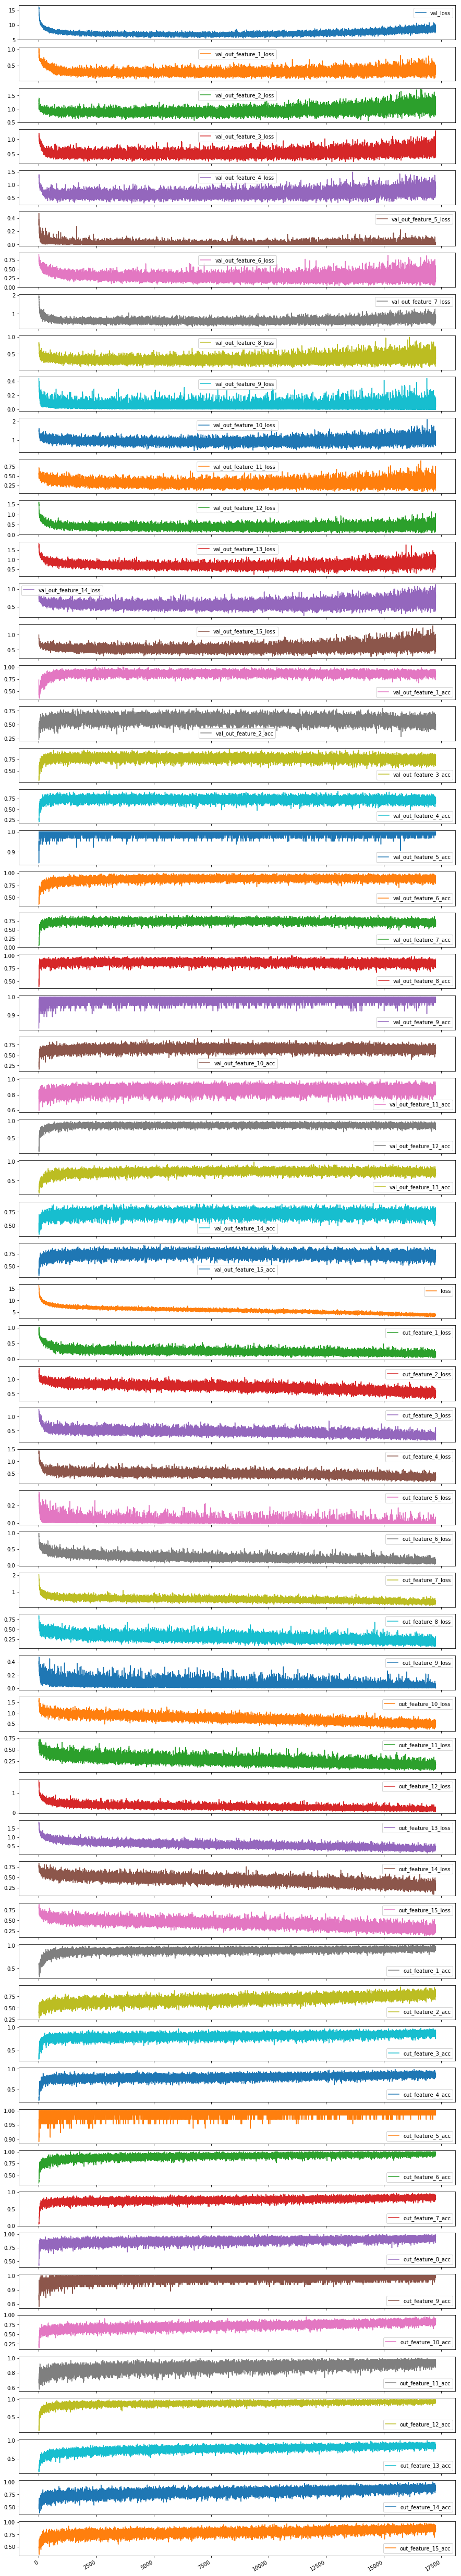

In [28]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(15,100))
print(df_hist['val_loss'].min())
df_hist[df_hist['val_loss']<5.93]

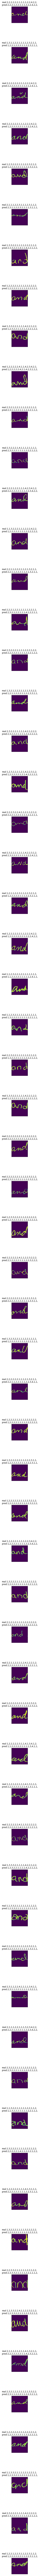

In [29]:
# human_features.load_weights('human_features_weights_v2.h5')
human_features.load_weights('weights/15-Multitask-TrainableEncoder-seen_v2.h5')
vx,vo=next(vg)
# print(len(vo))
fig = plt.figure(figsize=(80,200))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=1.51, wspace=0.05)
for i in range(64):
#     print(i, '\nPredicted:')
    
    real=''
    for f in range(15):
#         print(vo[i][f])
        real+=str(np.argmax(vo[f][i])+1)+','
    
    f_probs = human_features.predict(np.expand_dims(vx[i],0))
#     print(f_probs)
    pred=''
    for prob in f_probs:
#         print(prob)
        pred+=str(np.argmax(prob[0])+1)+','
    
    ax = fig.add_subplot(64, 1, i + 1, xticks=[], yticks=[])
    ax.imshow(vx[i].reshape((64,64)))
    ax.set_title('real:'+real+'\n pred:'+pred)
#     print('\n----------')
#     print('True:')
#     for op in o:
#         print(np.argmax(op[i]),end=',')
        
#     print('\n++++++',i,'++++++')

In [30]:
# print(df_hist.columns)
total = 0
for i in range(1,16):
    print(df_hist.iloc[5699]['val_out_feature_{0}_acc'.format(i)].max())
    total+=df_hist.iloc[5699]['val_out_feature_{0}_acc'.format(i)]
print('total_acc:',total/15)
# print(np.mean([df_hist['val_out_feature_1_acc'].max(), df_hist['val_out_feature_2_acc'].max(),
#        df_hist['val_out_feature_3_acc'].max(), df_hist['val_out_feature_4_acc'].max(),
#        df_hist['val_out_feature_5_acc'].max(), df_hist['val_out_feature_6_acc'].max(),
#        df_hist['val_out_feature_7_acc'].max(), df_hist['val_out_feature_8_acc'].max()]))
# df_hist[df_hist['val_acc']>10.2]

0.84375
0.5625
0.75
0.8125
0.96875
0.90625
0.734375
0.84375
1.0
0.671875
0.828125
0.859375
0.71875
0.796875
0.765625
total_acc: 0.8041666666666667


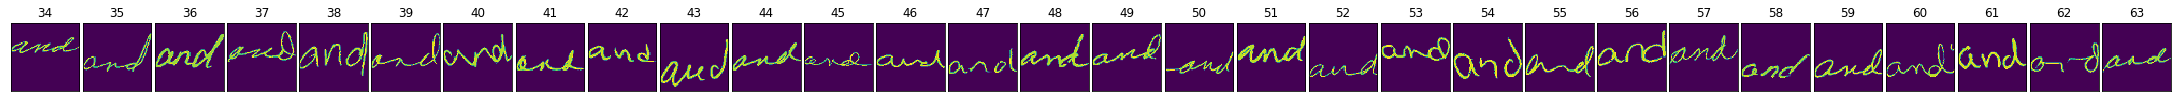

In [31]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(30):
    ax = fig.add_subplot(1, 30, i + 1, xticks=[], yticks=[])
    ax.imshow(inputs[64-30:64][i].reshape((64,64)))
    ax.set_title(i+34)

In [32]:
# plt.imshow(inputs[10].reshape((64,64)))
# plt.subplots_adjust(hspace = 0.1)
# for i in range(1,9):
#     visualize_model = Model(human_features.input, human_features.get_layer('dense_layer_'+str(i)).output)
#     vis_out = visualize_model.predict(np.expand_dims(inputs[10],0))[0]
#     vis_out = np.rollaxis(a=vis_out, start=0, axis=2)
#     f,ax = plt.subplots(8,8)
#     f.subplots_adjust(hspace = .00, wspace=.02, top=0.95)
#     f.set_size_inches(15,15)
#     f.suptitle('dense_layer_'+str(i), fontsize=15)
# #     f.subplots_adjust(hspace = 0.1)
# #     plt.title('dense_layer_'+str(i))
#     print(vis_out.shape)
#     for r in range(8):
#         for c in range (8):
#             ax[r,c].imshow(vis_out[c+r*8])
#             ax[r,c].axis('off')
# #     break

In [33]:
csv_data.var()

pen_pressure      0.241190
letter_spacing    0.481638
size              0.475689
dimension         0.464579
is_lowercase      0.014808
is_continuous     0.222378
slantness         0.866958
tilt              0.152430
entry_stroke_a    0.053592
staff_of_a        0.862689
formation_n       0.176950
staff_of_d        0.409782
exit_stroke_d     1.054210
word_formation    0.245240
constancy         0.239313
dtype: float64

# Evaluation

In [42]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
from tqdm import tqdm_notebook

In [34]:
pred_flat = []
for i in range(1,len(feature_lengths)+1):
    pred_flat.append(human_features.get_layer('dense_layer_'+str(i)).output)
human_features_eval = Model(inputs=human_features.input, outputs=pred_flat)
human_features_encoder = Model(human_features.input,human_features.get_layer('encoded').output)

In [35]:
test_g = datagen(len(val_images)*5,val_path,val_images, vshift = (-10,10), vis=True)
testx,testy = next(test_g)

In [36]:
feature_wise_pred_y=human_features_eval.predict(testx)
latent_pred_y=human_features_encoder.predict(testx)

In [37]:
feature_wise_pred_y=np.array(feature_wise_pred_y)
latent_pred_y=np.array(latent_pred_y).reshape((-1,512))

In [38]:
latent_pred_y.shape,feature_wise_pred_y.shape

((4760, 512), (15, 4760, 128))

In [39]:
testy[0].shape,testy[1].shape

((4760,), (4760,))

In [40]:
ids = testy[0].reshape(-1,1)
imagenames = testy[1].reshape(-1,1)
data=[]
for i in range(len(testx)):
    data.append([ids[i][0],imagenames[i][0],latent_pred_y[i]])
df_data = pd.DataFrame(data=data, columns=['identity','imagename','latent'])
# df_outs['ids'] = ids
# df_outs['preds'] = preds 
df_data=df_data.sort_values(by='identity').reset_index()
df_data.head(10)

,index,identity,imagename,latent
0,3715,0001,0001a_num2.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.59534395, 0.845876..."
1,897,0001,0001a_num2.png,"[0.0, 0.6269461, 0.0, 0.0, 0.0, 0.0, 0.3866365..."
2,3414,0001,0001a_num1.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0950717, 0.1887798..."
3,3379,0001,0001a_num2.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.62149924, 0.694616..."
4,674,0001,0001a_num1.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.4592589, 0.2288419..."
5,1435,0001,0001a_num2.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.48791075, 0.693194..."
6,644,0001,0001a_num1.png,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0350852, 0.0, 0.0,..."
7,4472,0002,0002a_num2.png,"[0.0, 0.3263373, 0.0, 0.0, 0.0, 2.2661698, 0.0..."
8,3182,0002,0002a_num2.png,"[0.0, 0.4351375, 0.25571075, 0.0, 0.0, 1.89525..."
9,4417,0002,0002a_num2.png,"[0.0, 0.58890754, 0.44406846, 0.0, 0.0, 2.2102..."


In [43]:
cos_dist_out = cosine_similarity(list(df_data['latent'].values))

In [56]:
queried_count, idx_count, tp, tn, fp, fn = 0,0,0,0,0,0
cos_thresh = 0.8
data_result = []
fp_list = []
fn_list = []
r_counter = 0
stop_at = 20
prev_query = ''
prev_given = ''
given_count = 0
# total = cos_dist_out.shape[0]
for row in tqdm_notebook(cos_dist_out):
    c_counter = 0
    given_idx = df_data.iloc[r_counter]['identity']
    given_img = df_data.iloc[r_counter]['imagename']
    for col in row:
        queried_idx = df_data.iloc[c_counter]['identity']
        queried_img = df_data.iloc[c_counter]['imagename']
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            tp += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            tn += 1
        if int(given_idx) != int(queried_idx) and cos_dist_out[r_counter][c_counter]>cos_thresh:
            fp += 1
            fp_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx) and cos_dist_out[r_counter][c_counter]<cos_thresh:
            fn += 1
            fn_list.append(os.path.join(queried_idx,queried_img))
        if int(given_idx) == int(queried_idx):
            idx_count += 1
#             print('--i--',idx_count,'--i--')
#             print(given_idx,queried_idx)
        if prev_query != queried_idx:
#             print('--q--',queried_count,'--q--')
            queried_count += 1
        c_counter += 1
        prev_query = queried_idx
#         if queried_count == stop_at:
#             break
    precision = tp/(fp+tp)
    recall = tp/(tp+fn)
    f1 = 2*(precision*recall)/(precision+recall)
    total = np.sum((tp,tn,fp,fn))
    accuracy = (tp+tn)/total
    data_result.append([given_idx,given_img, idx_count, tp, tn, fp, fn,precision,recall,f1,accuracy, total, fp_list, fn_list])
    if prev_given != given_idx:
#         print('----',given_count,'-----')
        given_count+=1
    r_counter += 1
    prev_given = given_idx
    queried_count, idx_count, tp, tn, fp, fn = 0, 0, 0, 0, 0, 0
    fp_list = []
    fn_list = []
#     if given_count == stop_at:
#         break

In [57]:
df_cos_dist_out = pd.DataFrame(data_result, columns=['identity','imagename','total_images_identity','TP','TN','FP','FN','precision','recall','f1','accuracy','total_images', 'FP_List','FN_List'])
df_cos_dist_out=df_cos_dist_out.sort_values(by='identity',ascending=True).reset_index().drop(columns=['index'])
df_cos_dist_out.head()

,identity,imagename,total_images_identity,TP,TN,FP,FN,precision,recall,f1,accuracy,total_images,FP_List,FN_List
0,0001,0001a_num2.png,7,7,4618,135,0,0.049296,1.0,0.093960,0.971639,4760,"[0011/0011a_num1.png, 0011/0011a_num1.png, 001...",[]
1,0001,0001a_num2.png,7,7,4664,89,0,0.072917,1.0,0.135922,0.981303,4760,"[0011/0011a_num1.png, 0011/0011a_num1.png, 001...",[]
2,0001,0001a_num1.png,7,7,4605,148,0,0.045161,1.0,0.086420,0.968908,4760,"[0011/0011a_num1.png, 0011/0011a_num1.png, 001...",[]
3,0001,0001a_num2.png,7,7,4630,123,0,0.053846,1.0,0.102190,0.974160,4760,"[0011/0011a_num1.png, 0011/0011a_num1.png, 001...",[]
4,0001,0001a_num1.png,7,7,4649,104,0,0.063063,1.0,0.118644,0.978151,4760,"[0011/0011a_num1.png, 0011/0011a_num1.png, 001...",[]


In [58]:
# print(df_cos_dist_out.keys())
total = df_cos_dist_out.shape[0]
total_images_identity = df_cos_dist_out['total_images_identity']
tps = df_cos_dist_out['TP'].sum()
fps = df_cos_dist_out['FP'].sum()
tns = df_cos_dist_out['TN'].sum()
fns = df_cos_dist_out['FN'].sum()
precision = tps/(fps+tps)
recall = tps/(tps+fns)
f1 = 2*(precision*recall)/(precision+recall)
print('precision:',precision,'\nrecall:',recall,'\nf1:',f1)
acc = df_cos_dist_out['accuracy'].mean()
print('Intra Writer Accuracy (Type 1):',np.mean(df_cos_dist_out['TP']/total_images_identity))
print('Inter Writer Accuracy (Type 2)::',tns/total/total)
print('acc:',acc)

precision: 0.04547539347903055 
recall: 0.8773918105957694 
f1: 0.08646907734059583
Intra Writer Accuracy (Type 1): 0.8812640422995353
Inter Writer Accuracy (Type 2):: 0.9558414836522845
acc: 0.9578369288892028


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
from tqdm import tqdm_notebook

In [ ]:
l = pred_y[:,0,:]
r = pred_y[:,1,:]

In [ ]:
# df_feat_sim_score.style.bar(subset=['feature similarity score'], color='lightblue', align='mid')

In [ ]:
class_preds = human_features.predict(test_x[:2])

In [ ]:
for i in range(len(test_x[:2])):
    for f in range(15):
        print(np.argmax(class_preds[f][i]),end=',')
    print('')

In [ ]:
# df_cos_dist_out.to_csv('results-DL_AE_Maxpool_1x1x512_seen.csv')
# left_image = '0103b_num1.png'
# right_image = '0012c_num3.png' #0 similarity
left_image = '0124a_num5.png'
right_image = '0049a_num1.png' #0 similarity

test_im_normal = (255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/'+left_image,0))/255.0
test_im_shifted = (255.0-cv2.imread('../Handwriting/cleaned_AND_data_64x64/'+right_image,0))/255.0
py1 = human_features_encoder.predict(test_im_normal.reshape((1,64,64,1)))
py2 = human_features_encoder.predict(test_im_shifted.reshape((1,64,64,1)))
l = np.array(human_features_eval.predict(test_im_normal.reshape((1,64,64,1))))
r = np.array(human_features_eval.predict(test_im_shifted.reshape((1,64,64,1))))
l = l.reshape(15,-1)
r = r.reshape(15,-1)
print(py1[py1==0].shape,py2[py2==0].shape)
py1 = py1.reshape((-1,512))
py2 = py2.reshape((-1,512))
print(py1.shape,py2.shape)

cosine_similarity(py1,py2), cosine_distances(py1,py2), euclidean_distances(py1,py2)

In [ ]:


# print(test_im_normal.max())
f,ax = plt.subplots(1,2)
f.subplots_adjust(hspace = .00, wspace=.05)
f.set_size_inches(5,1*3)
f.suptitle('Similarity Score: '+str(np.round(cosine_similarity(py1,py2)[0][0],4)), fontsize=16)
ax[0].imshow(255.0-test_im_normal.reshape((64,64)),cmap="gray")
ax[0].axis('on')
ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[1].imshow(255.0-test_im_shifted.reshape((64,64)),cmap="gray")
ax[1].axis('on')
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])
ax[0].set_title(left_image)
ax[1].set_title(right_image)

In [ ]:
features = csv_data.keys()[1:]
feature_similarity_score=cosine_similarity(l,r).diagonal()
df_feat_sim_score = pd.DataFrame(columns=['features','feature similarity score'])
df_feat_sim_score['features']=features
df_feat_sim_score['feature similarity score']=feature_similarity_score
ax = df_feat_sim_score.plot.barh(width=0.85
                                 , rot=0
                                 , x='features'
                                 , color='lightblue'
                                 , fontsize=14
                                 , figsize=(5,8)
                                 , grid=True)
df_feat_sim_score['feature similarity score'].mean()
counter=-1
ax.legend(bbox_to_anchor=(0.75,-0.05)
          , fontsize=14)
ax.grid(color='#bebebe'
        , linestyle='-.'
        , linewidth=0.5)
plt.ylabel('features',fontsize=14)
for p in ax.patches:
    counter+=1
    ax.annotate(str(p.get_width()), (0.25, counter*0.99))
feature_similarity_score.sum()/15.0